In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import sklearn.metrics as mtr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pytz

# Exploração e Tratamento dos dados

In [2]:
df = pd.read_csv('dados_floripa.csv')
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\2996573664.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados_floripa.csv')


,DataIni,HoraIni,DataFim,HoraFim,Sentido,Linha,NoVeículo,DuraçãoViagem,TotalGiros,KmPerc
0,2019-04-14,02:29:00,2019-04-14,02:30:00,Ida,100,271,00:01:00,0,0.000
1,2019-04-14,03:30:00,2019-04-14,03:30:00,Ida,100,271,00:00:00,0,0.000
2,2019-04-13,01:28:00,2019-04-13,01:28:00,Ida,100,276,00:00:00,0,0.000
3,2019-04-12,03:28:00,2019-04-12,03:28:00,Ida,100,279,00:00:00,0,0.000
4,2019-04-07,00:31:00,2019-04-07,00:31:00,Ida,100,273,00:00:00,0,0.000
...,...,...,...,...,...,...,...,...,...,...
2694355,2019-10-01,04:00:00,2019-10-01,04:34:00,Volta,477,50404,00:34:00,5,17.294
2694356,2019-10-01,04:29:00,2019-10-01,05:12:00,Volta,477,50359,00:43:00,7,17.294
2694357,2019-10-01,05:15:00,2019-10-01,05:47:00,Volta,477,50404,00:32:00,7,17.294
2694358,2019-10-01,05:47:00,2019-10-01,05:47:00,Volta,477,50404,00:00:00,0,17.294


In [3]:
# Checar o tipos dos dados
df.dtypes

DataIni           object
HoraIni           object
DataFim           object
HoraFim           object
Sentido           object
Linha             object
NoVeículo         object
DuraçãoViagem     object
TotalGiros         int64
KmPerc           float64
dtype: object

In [4]:
# Checkup geral das colunas
# Podemos ver num primeiro momento que:
# Sentido está de certa forma balanceado no geral, verificar se para todas as rotas também está próximo
# Existem 229 linhas que podem ser trabalhadas (objeto do estudo)
# Existem 1295 veículos, pode existir alguma relação do veículo com a eficiência/velocidade da rota, porém como não sabemos quem dirige o ônibus ou informações do mesmo como estado de manutenção e etc, provavelmente será um dado descartado
# Algumas rotas estão com KmPerc zerados, podem ser falhas de medição e serão descartados
# Algumas rotas estão com o tempo de viagem zerados, podem ser falhas de medição e serão descartados
# TotalGiros são o número de pessoas que passaram pela roleta podem influenciar na DuraçãoViagem das rotas, algumas estão zeradas podendo ser falha de medição
for colum in df:
    print(f'{df[colum].describe()}\n--------------------------')

count        2694360
unique           366
top       2019-10-25
freq            9276
Name: DataIni, dtype: object
--------------------------
count      2694360
unique        1440
top       07:00:00
freq          4366
Name: HoraIni, dtype: object
--------------------------
count        2694360
unique           366
top       2019-10-25
freq            9275
Name: DataFim, dtype: object
--------------------------
count      2694360
unique        1440
top       07:15:00
freq          3969
Name: HoraFim, dtype: object
--------------------------
count     2694360
unique          2
top         Volta
freq      1394073
Name: Sentido, dtype: object
--------------------------
count     2694360
unique        230
top           410
freq        68613
Name: Linha, dtype: object
--------------------------
count     2694360
unique       1301
top         11637
freq         8487
Name: NoVeículo, dtype: int64
--------------------------
count      2694360
unique         454
top       00:21:00
freq         819

In [5]:
# Id do veículos consideramos que é um informação desnecessária, visto que não temos dados dos veículos em si como modelo, motor e etc. Assim acreditamos ser um dados desnecessário para a predição
df.drop(columns='NoVeículo',inplace=True)

In [6]:
# Unindo data e hora e removendo as antigas (Visto que as datas e horas atuais estão em colunas separadas e são objetos, queremos elas como datetimes)
df['Ini'] = pd.to_datetime(df['DataIni'] + ' ' + df['HoraIni'])
df['Fim'] = pd.to_datetime(df['DataFim'] + ' ' + df['HoraFim'])
df.drop(columns=['DataIni','HoraIni','DataFim','HoraFim'],inplace=True)

In [7]:
# Transformando a DuraçãoViagem em segundos, visto que é um objeto também
def time_to_seconds(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_seconds = (hours * 3600) + (minutes * 60) + seconds
    return total_seconds
df['DuraçãoViagem'] = df['DuraçãoViagem'].apply(time_to_seconds)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
0,Ida,100,60,0,0.000,2019-04-14 02:29:00,2019-04-14 02:30:00
1,Ida,100,0,0,0.000,2019-04-14 03:30:00,2019-04-14 03:30:00
2,Ida,100,0,0,0.000,2019-04-13 01:28:00,2019-04-13 01:28:00
3,Ida,100,0,0,0.000,2019-04-12 03:28:00,2019-04-12 03:28:00
4,Ida,100,0,0,0.000,2019-04-07 00:31:00,2019-04-07 00:31:00
...,...,...,...,...,...,...,...
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00
2694358,Volta,477,0,0,17.294,2019-10-01 05:47:00,2019-10-01 05:47:00


In [8]:
# Removendo linhas com Duração e Distância percorridas iguais a 0
df = df.loc[(df['DuraçãoViagem'] != 0) & (df['KmPerc'] != 0)]

In [9]:
# Criando uma coluna de Velocidade para identificar outliers
df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)
# Removendo valores muito baixos e altos de velocidade
df = df.loc[(df['Km/H'] > 3) & (df['Km/H'] < 80)]
df.drop(columns='Km/H', inplace=True)
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\629631639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Km/H'] = df['KmPerc']/(df['DuraçãoViagem']/3600)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00
...,...,...,...,...,...,...,...
2694352,Volta,477,1500,1,17.294,2019-10-01 03:30:00,2019-10-01 03:55:00
2694355,Volta,477,2040,5,17.294,2019-10-01 04:00:00,2019-10-01 04:34:00
2694356,Volta,477,2580,7,17.294,2019-10-01 04:29:00,2019-10-01 05:12:00
2694357,Volta,477,1920,7,17.294,2019-10-01 05:15:00,2019-10-01 05:47:00


In [10]:
# Criando novos atributos a partir da data
df['dia_semana'] = df['Ini'].dt.dayofweek + 1
df['hora_dia'] = df['Ini'].dt.hour
df['dia_ano'] = df['Ini'].dt.dayofyear
df['mes_ano'] = df['Ini'].dt.month
df['turno_dia'] = df['hora_dia'].apply(lambda x: 1 if x < 6 else 4 if x > 17 else 2 if (x > 5 & x < 12) else 3 if (x > 11 & x < 18) else None)

In [11]:
# Analisando e removendo Linhas que não tem observações nos 12 meses do ano
meses_linha = df.groupby('Linha')['mes_ano'].unique().reset_index(name='meses')
meses_linha['contagem'] = meses_linha['meses'].apply(lambda x: len(x))
linhas_com_12_meses = meses_linha.loc[meses_linha['contagem']==12]['Linha'].values
df = df.loc[df['Linha'].isin(linhas_com_12_meses)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [12]:
# Analisando se alguma rota tem uma discrepancia muito grande entre as observações em cada Mês. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha = df.groupby(['Linha','mes_ano'])['dia_ano'].unique().reset_index(name='dias')
dias_mes_linha['contagem'] = dias_mes_linha['dias'].apply(lambda x: len(x))
dias_mes_linha_std = dias_mes_linha.groupby('Linha')['contagem'].agg(media='mean',desvio='std').reset_index()

In [13]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha_std.sort_values(by='desvio')

,Linha,media,desvio
0,100,30.416667,0.900337
34,164,30.416667,0.900337
35,165,30.416667,0.900337
37,168,30.416667,0.900337
77,270,30.416667,0.900337
...,...,...,...
8,1120,26.166667,2.124889
10,1122,26.333333,2.188122
9,1121,26.333333,2.188122
134,601V,20.000000,3.567530


In [14]:
# Analisando na mão os resultados acima. Resolvemos remover apenas os dois maiores desvio e a media abaixo de 20
dias_mes_linha.loc[dias_mes_linha['Linha']=='601V']

,Linha,mes_ano,dias,contagem
1608,601V,1,"[31, 30, 29, 28, 25, 24, 23, 22, 21, 18, 17, 1...",22
1609,601V,2,"[59, 58, 57, 56, 53, 52, 51, 50, 49, 46, 45, 4...",20
1610,601V,3,"[88, 87, 86, 85, 84, 67, 66, 65, 63, 60]",10
1611,601V,4,"[120, 119, 116, 115, 114, 113, 112, 108, 107, ...",21
1612,601V,5,"[151, 150, 149, 148, 147, 144, 143, 142, 141, ...",22
1613,601V,6,"[179, 178, 177, 176, 175, 172, 170, 169, 168, ...",18
1614,601V,7,"[212, 211, 210, 207, 206, 205, 204, 203, 200, ...",23
1615,601V,8,"[242, 241, 240, 239, 238, 235, 234, 233, 232, ...",22
1616,601V,9,"[273, 270, 269, 268, 267, 266, 263, 262, 261, ...",21
1617,601V,10,"[304, 303, 302, 301, 298, 297, 296, 295, 294, ...",23


In [15]:
# Removendo as linhas com maior desvio padrão entre os meses
df = df.loc[~df['Linha'].isin(['601V','296','500V'])]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
6,Volta,100,3780,3,16.308,2019-05-01 00:31:00,2019-05-01 01:34:00,3,0,121,5,1
7,Volta,100,3660,10,16.308,2019-05-01 01:35:00,2019-05-01 02:36:00,3,1,121,5,1
8,Volta,100,1800,8,16.308,2019-05-01 02:36:00,2019-05-01 03:06:00,3,2,121,5,1
9,Volta,100,3600,7,16.308,2019-05-01 03:30:00,2019-05-01 04:30:00,3,3,121,5,1
10,Volta,100,1680,7,16.308,2019-05-01 04:30:00,2019-05-01 04:58:00,3,4,121,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


count      185.000000
mean     13839.216216
std      13599.364304
min        247.000000
25%       3990.000000
50%      10699.000000
75%      16809.000000
max      67327.000000
Name: Sentido, dtype: float64


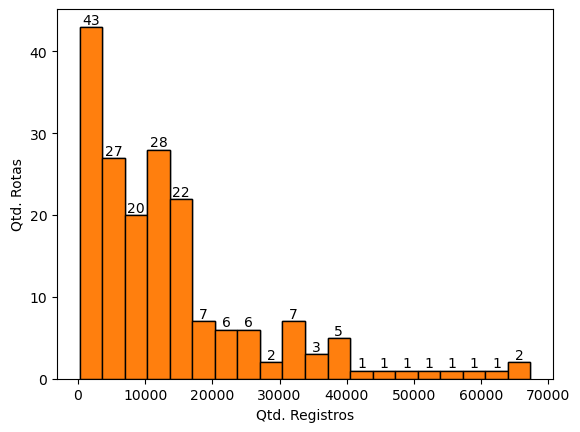

In [16]:
# Verificando a quantidade de rotas em cada Linha para removermos linhas com poucas observações ou muitas observações
qtd_rotas_p_linha = pd.DataFrame(df.groupby('Linha')['Sentido'].count())
print(qtd_rotas_p_linha['Sentido'].describe())
# Plotar o histograma
plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')  # 'data' são os dados, 'bins' é o número de intervalos
# Adicionar rótulos com o número de itens em cada bin
hist, bins, _ = plt.hist(qtd_rotas_p_linha['Sentido'], bins=20, edgecolor='black')
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i], str(int(hist[i])),ha='center', va='bottom')
plt.xlabel('Qtd. Registros')  # Rótulo do eixo x
plt.ylabel('Qtd. Rotas')  # Rótulo do eixo y
# Exibir o histograma
plt.show()

In [17]:
# Removendo as linhas com quantidade de rotas fora do primeiro e terceiro quartil
rotas_entre_primeiro_terceiro_qaurtil = qtd_rotas_p_linha.loc[(qtd_rotas_p_linha['Sentido'] > 3900)&(qtd_rotas_p_linha['Sentido']<16900)].index.values
df = df.loc[df['Linha'].isin(rotas_entre_primeiro_terceiro_qaurtil)]
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia
179,Volta,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2
180,Volta,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2
181,Volta,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2
182,Volta,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2
183,Volta,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2694235,Volta,M940,780,0,8.622,2019-09-01 17:47:00,2019-09-01 18:00:00,7,17,244,9,2
2694236,Volta,M940,660,0,8.622,2019-09-01 18:32:00,2019-09-01 18:43:00,7,18,244,9,4
2694237,Volta,M940,660,2,8.622,2019-09-01 21:20:00,2019-09-01 21:31:00,7,21,244,9,4
2694238,Volta,M940,660,0,8.622,2019-09-01 22:15:00,2019-09-01 22:26:00,7,22,244,9,4


In [18]:
# Analisando se a quantidade de idas e voltas de cada linha está Ok. Concluimos que está ok e não removemos nenhum linha
ida_voltas_linhas = df.groupby('Linha')['Sentido'].value_counts().unstack(fill_value=0)
ida_voltas_linhas['Diferenca'] = ida_voltas_linhas['Ida'] - ida_voltas_linhas['Volta']
ida_voltas_linhas.sort_values(by='Diferenca')

Sentido,Ida,Volta,Diferenca
Linha,,,
138,0,16346,-16346
136,0,16296,-16296
137,0,15949,-15949
135,0,15936,-15936
772,0,10950,-10950
...,...,...,...
274,2790,2202,588
281,8657,7953,704
330V,6235,5511,724


In [19]:
# Fazendo um encoding da coluna Sentido, pois o modelo XGB não aceita informações categoricas.
df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\2206277558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentido'] = df['Sentido'].map({'Ida': 0, 'Volta': 1})


In [20]:
# Analisando número de Giros por linhas. Tem valores estranhos e que não fazem sentido, porém de decidimos deixar para rodar nos modelos, retimos apenas a linha 110 que estava toda zerada
df.groupby(['Linha'])['TotalGiros'].mean().reset_index().sort_values(by='TotalGiros')

,Linha,TotalGiros
2,110,0.003722
58,362,4.119939
40,180,4.325447
38,178,5.977037
91,943,6.096262
...,...,...
17,136,44.577320
54,294,46.153422
19,138,48.245626
16,135,50.508471


In [21]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"TotalGiros": "mean"}).reset_index(drop=True)
df_mean.rename({"TotalGiros": "TotalGirosMean"}, axis=1, inplace=True)
df_mean

,Linha,data,hora_dia,TotalGirosMean
0,101,2018-11-01,6,5.0
1,101,2018-11-01,7,7.0
2,101,2018-11-01,8,6.0
3,101,2018-11-01,9,7.0
4,101,2018-11-01,10,1.0
...,...,...,...,...
440175,M940,2019-10-31,19,8.0
440176,M940,2019-10-31,20,4.5
440177,M940,2019-10-31,21,2.5
440178,M940,2019-10-31,22,4.0


In [22]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\4244930809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835345,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
835346,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
835347,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
835348,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


In [23]:
# Olhando na mão linha a linha
df.loc[df['Linha']=='110']#.groupby('turno_dia').size()

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
710,0,110,1140,0,7.629,2019-04-30 08:34:00,2019-04-30 08:53:00,2,8,120,4,2,0.0
711,0,110,1680,0,7.629,2019-04-30 08:04:00,2019-04-30 08:32:00,2,8,120,4,2,0.0
712,1,110,1080,0,7.713,2019-04-30 08:16:00,2019-04-30 08:34:00,2,8,120,4,2,0.0
713,1,110,1080,0,7.713,2019-04-30 08:32:00,2019-04-30 08:50:00,2,8,120,4,2,0.0
714,0,110,1200,0,7.629,2019-04-30 12:25:00,2019-04-30 12:45:00,2,12,120,4,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768798,1,110,2040,0,7.713,2019-09-05 19:13:00,2019-09-05 19:47:00,4,19,248,9,4,0.0
768799,1,110,900,0,7.713,2019-09-04 19:08:00,2019-09-04 19:23:00,3,19,247,9,4,0.0
768800,1,110,1740,0,7.713,2019-09-04 19:12:00,2019-09-04 19:41:00,3,19,247,9,4,0.0
768801,1,110,1020,0,7.713,2019-09-03 19:04:00,2019-09-03 19:21:00,2,19,246,9,4,0.0


In [24]:
# Remoção da linha 110
df = df.loc[df['Linha'] != '110']
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835345,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
835346,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
835347,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
835348,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


   Linha  DuraçãoViagem
51   282     296.364647
83   769     299.876240
25   162     306.562234
57   362     315.378457
80   762     324.562481
..   ...            ...
7   1122     997.593026
16   136    1031.680272
18   138    1054.397896
85   840    1113.281266
41  2120    1121.693846

[94 rows x 2 columns]


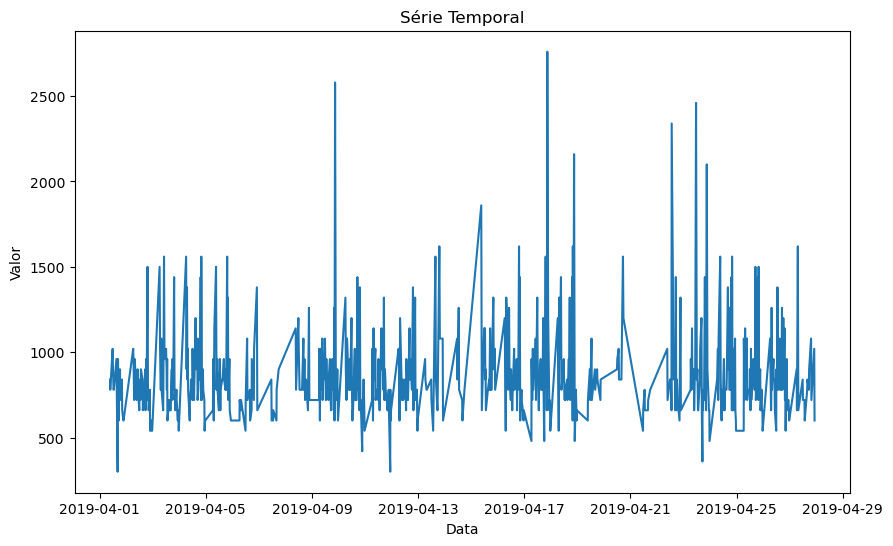

In [25]:
# Analisando o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico
print(df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem'))
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [26]:
#Remoção dos outliers de cada Linha
# IQR Method (Interquartile Range):
def remove_outlier(valores):
    Q1 = np.percentile(valores,25)
    Q3 = np.percentile(valores,75)
    intervalo = Q3-Q1
    limite_superior = Q3+intervalo*1.5
    limite_inferior = Q1-intervalo*1.5
    return limite_superior,limite_inferior

linhas = df['Linha'].unique()
outliers_indexs = []
for linha in linhas:
    aux = df.loc[df['Linha'] == linha]['DuraçãoViagem']
    limite_superior,limite_inferior = remove_outlier(aux)
    aux = aux.loc[(aux.values > limite_superior) | (aux.values < limite_inferior)]
    outliers_indexs.extend(aux.index)
df.drop(outliers_indexs,inplace=True)
df.reset_index(drop=True,inplace=True)
df

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\2474428967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outliers_indexs,inplace=True)


,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
0,1,101,1320,2,5.418,2019-04-30 06:30:00,2019-04-30 06:52:00,2,6,120,4,2,3.000000
1,1,101,1200,12,5.418,2019-04-30 07:10:00,2019-04-30 07:30:00,2,7,120,4,2,7.000000
2,1,101,1200,4,5.418,2019-04-30 07:50:00,2019-04-30 08:10:00,2,7,120,4,2,7.000000
3,1,101,2340,10,5.418,2019-04-30 08:25:00,2019-04-30 09:04:00,2,8,120,4,2,7.000000
4,1,101,1440,3,5.418,2019-04-30 09:30:00,2019-04-30 09:54:00,2,9,120,4,2,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797202,1,M940,2280,10,8.622,2019-09-29 05:24:00,2019-09-29 06:02:00,7,5,272,9,1,12.000000
797203,1,M940,1020,0,8.622,2019-09-28 10:59:00,2019-09-28 11:16:00,6,10,271,9,2,12.000000
797204,1,M940,1080,2,8.622,2019-09-22 16:59:00,2019-09-22 17:17:00,7,16,265,9,2,3.666667
797205,1,M940,2700,18,8.622,2019-09-16 13:17:00,2019-09-16 14:02:00,1,13,259,9,2,4.000000


   Linha  DuraçãoViagem
0    362     178.799001
1    162     200.062211
2    271     200.500940
3    169     203.888001
4    168     211.184265
..   ...            ...
89   136     768.143369
90   135     788.268836
91   138     808.558630
92   235     848.243518
93  4122     864.089809

[94 rows x 2 columns]


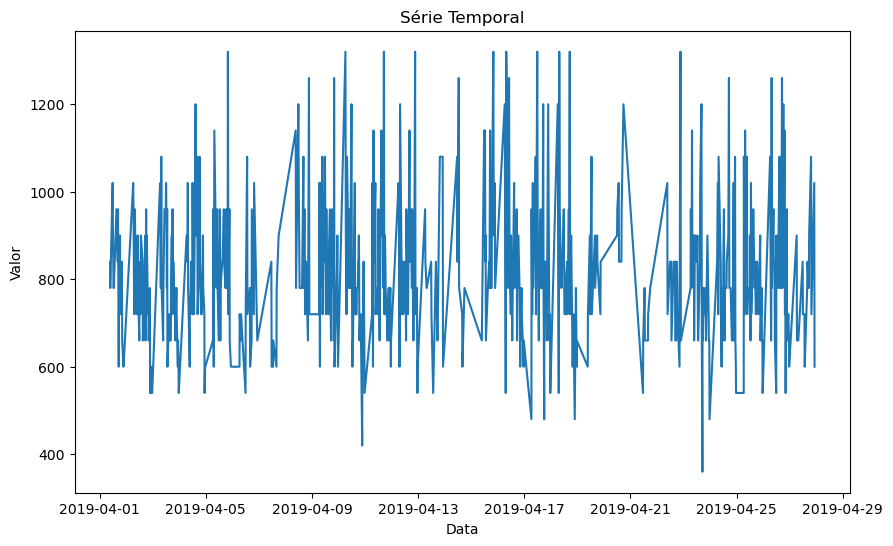

In [27]:
# Voltando a analisar o desvio padrão das durações de viagem de cada rota e plotando os valores de uma no gáfico após a remoçao dos outliers
a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == '362'][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-04-01") & (df_plot["Ini"] < "2019-04-28")]
df_plot.set_index('Ini', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Série Temporal')
plt.show()

In [28]:
#Selecionando as rotas que serão usadas nos teste
a.iloc[[0,1,64,65,92,93]]

,Linha,DuraçãoViagem
0,362,178.799001
1,162,200.062211
64,605,518.593351
65,1123,530.362203
92,235,848.243518
93,4122,864.089809


In [29]:
# Deixando o dataframe apenas com as rotas que serão utilizadas
df = df.loc[df['Linha'].isin(['362','271','605','1120','235','4122'])].reset_index(drop=True).sort_values(by=['Linha','Ini'],ascending=[True,True])
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
29315,0,1120,3420,21,31.218,2018-11-06 06:10:00,2018-11-06 07:07:00,2,6,310,11,2,22.0
29316,0,1120,4560,26,31.218,2018-11-06 06:44:00,2018-11-06 08:00:00,2,6,310,11,2,22.0
29394,1,1120,3720,6,30.640,2018-11-06 07:08:00,2018-11-06 08:10:00,2,7,310,11,2,8.0
29317,0,1120,4320,30,31.218,2018-11-06 08:10:00,2018-11-06 09:22:00,2,8,310,11,2,11.0
29318,1,1120,3060,4,30.640,2018-11-06 08:14:00,2018-11-06 09:05:00,2,8,310,11,2,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35277,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0
35278,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0
35279,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5
35280,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0


In [30]:
# Dados gerais das rotas usadas
df.groupby('Linha').agg({'KmPerc':'max', 'Sentido':'count'})

,KmPerc,Sentido
Linha,,
1120,31.218,4582
235,24.110,4673
271,13.903,14001
362,4.240,8565
4122,25.244,4041
605,19.437,2864


In [31]:
print(df.shape)
len(df['Linha'].unique())

(38726, 13)


6

In [32]:
# Exportando o Dataframe
df.to_csv('dados_floripa_tratado.csv',index=False)

# Criação dos Modelos e Testes

## Teste Inicial

### Função que cria os 3 modelos e salva seus resultados

In [33]:
predictions = []
metrics = []


def cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome):

    #Treino do Modelo XGB e salvamento do tempo
    inicio_tempo_treino_xgb = datetime.now()
    modelo_xgb = xgb.XGBRegressor(
        # gamma = 0.0,
        # learning_rate = 0.01,
        # max_depth = 4,
        # min_child_weight = 8,
        # n_estimators = 500
    )
    modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

    fim_tempo_treino_xgb = datetime.now()
    tempo_treino_xgb = fim_tempo_treino_xgb - inicio_tempo_treino_xgb
    tempo_treino_xgb = float(f"{str(tempo_treino_xgb.seconds)}.{str(tempo_treino_xgb.microseconds)}")

    #Treino do Modelo RF e salvamento do tempo
    inicio_tempo_treino_rf = datetime.now()
    modelo_rf = RandomForestRegressor(
        # bootstrap = True,
        # max_depth = 11,
        # max_features = 'log2',
        # min_samples_leaf = 7,
        # min_samples_split = 6,
        # n_estimators = 500
    )
    modelo_rf.fit(x_treino, y_treino)

    fim_tempo_treino_rf = datetime.now()
    tempo_treino_rf = fim_tempo_treino_rf - inicio_tempo_treino_rf
    tempo_treino_rf = float(f"{str(tempo_treino_rf.seconds)}.{str(tempo_treino_rf.microseconds)}")

    #Treino do Modelo LR e salvamento do tempo
    inicio_tempo_treino_lr = datetime.now()
    modelo_lr = LinearRegression()
    modelo_lr.fit(x_treino, y_treino)

    fim_tempo_treino_lr = datetime.now()
    tempo_treino_lr = fim_tempo_treino_lr - inicio_tempo_treino_lr
    tempo_treino_lr = float(f"{str(tempo_treino_lr.seconds)}.{str(tempo_treino_lr.microseconds)}")

    #Nomeando a coluna que receberá as previsões
    TesteNomeXGB = f"XGB - {teste_nome}"
    TesteNomeRF = f"RF - {teste_nome}"
    TesteNomeLR = f"LR - {teste_nome}"

    #Predição do XGB e salvamento do tempo
    inicio_tempo_previsao_xgb = datetime.now()
    df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
    fim_tempo_previsao_xgb = datetime.now()
    tempo_previsao_xgb = fim_tempo_previsao_xgb - inicio_tempo_previsao_xgb
    tempo_previsao_xgb = float(f"{str(tempo_previsao_xgb.seconds)}.{str(tempo_previsao_xgb.microseconds)}")

    #Predição do RF e salvamento do tempo
    inicio_tempo_previsao_rf = datetime.now()
    df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
    fim_tempo_previsao_rf = datetime.now()
    tempo_previsao_rf = fim_tempo_previsao_rf - inicio_tempo_previsao_rf
    tempo_previsao_rf = float(f"{str(tempo_previsao_rf.seconds)}.{str(tempo_previsao_rf.microseconds)}")

    #Predição do LR e salvamento do tempo
    inicio_tempo_previsao_lr = datetime.now()
    df_teste[f'{TesteNomeLR}'] = modelo_lr.predict(x_teste)
    fim_tempo_previsao_lr = datetime.now()
    tempo_previsao_lr = fim_tempo_previsao_lr - inicio_tempo_previsao_lr
    tempo_previsao_lr = float(f"{str(tempo_previsao_lr.seconds)}.{str(tempo_previsao_lr.microseconds)}")

    #Métricas do XGB
    RMSE_xgb = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"]))
    MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeXGB}"])

    #Métricas do RF
    RMSE_rf = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"]))
    MAPE_rf = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeRF}"])

    #Métricas do LR
    RMSE_lr = np.sqrt(mtr.mean_squared_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"]))
    MAPE_lr = mtr.mean_absolute_percentage_error(df_teste["DuraçãoViagem"], df_teste[f"{TesteNomeLR}"])

    #Salvando as métricas num DataFrame Bonitinho
    metrics.append([f'{teste_nome}', rota,'XGBoost','RMSE',RMSE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'XGBoost','MAPE',MAPE_xgb, tempo_treino_xgb, tempo_previsao_xgb])
    metrics.append([f'{teste_nome}', rota,'Random Forest','RMSE',RMSE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Random Forest','MAPE',MAPE_rf, tempo_treino_rf, tempo_previsao_rf])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','RMSE',RMSE_lr, tempo_treino_lr, tempo_previsao_lr])
    metrics.append([f'{teste_nome}', rota,'Linear Regression','MAPE',MAPE_lr, tempo_treino_lr, tempo_previsao_lr])

    #Salvando as predições num DataFrame Bonitinho
    for i in range(df_teste.shape[0]):
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'XGBoost',df_teste[f"{TesteNomeXGB}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Random Forest',df_teste[f"{TesteNomeRF}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Linear Regression',df_teste[f"{TesteNomeLR}"].iloc[i]])
        predictions.append([f'{teste_nome}', df_teste['Ini'].iloc[i], rota,'Tempo real',df_teste["DuraçãoViagem"].iloc[i]])


    fi_xgb = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
    fi_xgb["Teste"] = teste_nome
    fi_xgb = fi_xgb.reset_index().pivot(index="Teste", columns="index", values="importance")
    # fi_xgb.sort_values("importance").plot(kind="barh", title=f"Importância Dados XGB {rota}")
    # plt.savefig(f"Images/FI_XGB_{rota}_{teste_nome}.jpg")
    
    fi_rf = pd.DataFrame(data=modelo_rf.feature_importances_, index=x_treino.columns, columns=["importance"])
    fi_rf["Teste"] = teste_nome
    fi_rf = fi_rf.reset_index().pivot(index="Teste", columns="index", values="importance")
    # fi_rf.sort_values("importance").plot(kind="barh", title=f"Importância Dados RF {rota}")
    # plt.savefig(f"Images/FI_RF_{rota}_{teste_nome}.jpg")

    return fi_xgb, fi_rf

### Execuções por rotas

In [34]:
Colunas = [
    ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']
]
TestesNome = [
    "0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']"

]
importance = pd.DataFrame(columns=["KmPerc", "Sentido", "dia_ano", "dia_semana", "hora_dia", "mes_ano", "turno_dia", "TotalGirosMean"])

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.68083
[3]	validation_0-rmse:1024.18370
[4]	validation_0-rmse:768.71614
[5]	validation_0-rmse:601.40748
[6]	validation_0-rmse:496.68425
[7]	validation_0-rmse:432.87627
[8]	validation_0-rmse:394.61285
[9]	validation_0-rmse:370.44435
[10]	validation_0-rmse:357.12341
[11]	validation_0-rmse:347.86716
[12]	validation_0-rmse:342.78816
[13]	validation_0-rmse:339.77326
[14]	validation_0-rmse:336.65660
[15]	validation_0-rmse:334.14750
[16]	validation_0-rmse:331.30526
[17]	validation_0-rmse:329.13079
[18]	validation_0-rmse:323.01812
[19]	validation_0-rmse:320.56431
[20]	validation_0-rmse:319.20777


[21]	validation_0-rmse:317.28602
[22]	validation_0-rmse:315.55828
[23]	validation_0-rmse:312.62790
[24]	validation_0-rmse:311.91820
[25]	validation_0-rmse:310.79285
[26]	validation_0-rmse:306.81700
[27]	validation_0-rmse:303.73995
[28]	validation_0-rmse:302.14782
[29]	validation_0-rmse:300.27992
[30]	validation_0-rmse:297.53246
[31]	validation_0-rmse:295.99842
[32]	validation_0-rmse:295.16338
[33]	validation_0-rmse:292.42029
[34]	validation_0-rmse:290.90007
[35]	validation_0-rmse:288.10611
[36]	validation_0-rmse:284.78499
[37]	validation_0-rmse:284.37231
[38]	validation_0-rmse:280.96463
[39]	validation_0-rmse:280.48910
[40]	validation_0-rmse:279.43020
[41]	validation_0-rmse:276.81194
[42]	validation_0-rmse:276.26428
[43]	validation_0-rmse:270.37128
[44]	validation_0-rmse:268.76630
[45]	validation_0-rmse:267.64240
[46]	validation_0-rmse:265.99228
[47]	validation_0-rmse:261.48687
[48]	validation_0-rmse:260.16426
[49]	validation_0-rmse:258.69251
[50]	validation_0-rmse:258.25757
[51]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:300.54854
[12]	validation_0-rmse:295.19055
[13]	validation_0-rmse:289.79707
[14]	validation_0-rmse:285.18907
[15]	validation_0-rmse:280.60777
[16]	validation_0-rmse:278.47147
[17]	validation_0-rmse:274.46901
[18]	validation_0-rmse:273.22146
[19]	validation_0-rmse:272.20484
[20]	validation_0-rmse:269.17100
[21]	validation_0-rmse:267.96191
[22]	validation_0-rmse:264.34986
[23]	validation_0-rmse:263.56489
[24]	validation_0-rmse:261.36051
[25]	validation_0-rmse:260.15530
[26]	validation_0-rmse:258.20973
[27]	validation_0-rmse:255.75595
[28]	validation_0-rmse:254.30276
[29]	validation_0-rmse:253.83325
[30]	validation_0-rmse:252.08988
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:721.30449
[2]	validation_0-rmse:520.01768
[3]	validation_0-rmse:383.69737
[4]	validation_0-rmse:292.86982
[5]	validation_0-rmse:236.04899
[6]	validation_0-rmse:201.69334
[7]	validation_0-rmse:182.51564
[8]	validation_0-rmse:172.02823
[9]	validation_0-rmse:166.16801
[10]	validation_0-rmse:162.40734
[11]	validation_0-rmse:159.53501
[12]	validation_0-rmse:156.98306
[13]	validation_0-rmse:155.81482
[14]	validation_0-rmse:155.24720
[15]	validation_0-rmse:154.82973
[16]	validation_0-rmse:153.41932
[17]	validation_0-rmse:152.18165
[18]	validation_0-rmse:151.68424
[19]	validation_0-rmse:150.75104
[20]	validation_0-rmse:149.33459
[21]	validation_0-rmse:149.06063
[22]	validation_0-rmse:148.05673
[23]	validation_0-rmse:147.59353
[24]	validation_0-rmse:147.12460
[25]	validation_0-rmse:146.06885
[26]	validation_0-rmse:145.88036
[27]	validation_0-rmse:145.33102
[28]	validation_0-rmse:144.44346
[29]	validation_0-rmse:144.33721
[30]	validation_0-rmse:143.90877
[31]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.73921
[1]	validation_0-rmse:437.18497
[2]	validation_0-rmse:324.56813
[3]	validation_0-rmse:250.55170
[4]	validation_0-rmse:204.05507
[5]	validation_0-rmse:175.79365
[6]	validation_0-rmse:159.27288
[7]	validation_0-rmse:150.01033
[8]	validation_0-rmse:144.55710
[9]	validation_0-rmse:141.47444
[10]	validation_0-rmse:138.69459
[11]	validation_0-rmse:136.18277
[12]	validation_0-rmse:135.43487
[13]	validation_0-rmse:135.00958
[14]	validation_0-rmse:134.21333
[15]	validation_0-rmse:133.11017
[16]	validation_0-rmse:131.95821
[17]	validation_0-rmse:131.64292
[18]	validation_0-rmse:131.37758
[19]	validation_0-rmse:130.90655
[20]	validation_0-rmse:130.16379
[21]	validation_0-rmse:129.20634
[22]	validation_0-rmse:128.52396
[23]	validation_0-rmse:128.25757
[24]	validation_0-rmse:127.44741
[25]	validation_0-rmse:126.95012
[26]	validation_0-rmse:126.43814
[27]	validation_0-rmse:125.70047
[28]	validation_0-rmse:125.47579
[29]	validation_0-rmse:124.92169
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2259.62983
[1]	validation_0-rmse:1621.20862
[2]	validation_0-rmse:1183.72499
[3]	validation_0-rmse:888.87951
[4]	validation_0-rmse:695.56787
[5]	validation_0-rmse:570.77886
[6]	validation_0-rmse:496.75807
[7]	validation_0-rmse:450.73670
[8]	validation_0-rmse:425.68055
[9]	validation_0-rmse:407.03411
[10]	validation_0-rmse:398.12362
[11]	validation_0-rmse:389.65748
[12]	validation_0-rmse:385.42991
[13]	validation_0-rmse:381.35636
[14]	validation_0-rmse:376.21088
[15]	validation_0-rmse:372.62739
[16]	validation_0-rmse:369.29024
[17]	validation_0-rmse:363.55499
[18]	validation_0-rmse:360.84073
[19]	validation_0-rmse:360.13643
[20]	validation_0-rmse:357.42087
[21]	validation_0-rmse:353.83128
[22]	validation_0-rmse:352.84695
[23]	validation_0-rmse:350.25943
[24]	validation_0-rmse:346.22833
[25]	validation_0-rmse:345.75525
[26]	validation_0-rmse:342.05751
[27]	validation_0-rmse:339.23835
[28]	validation_0-rmse:335.75313
[29]	validation_0-rmse:333.27042
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1665.20358
[2]	validation_0-rmse:1194.39764
[3]	validation_0-rmse:872.83237
[4]	validation_0-rmse:657.28979
[5]	validation_0-rmse:516.80842
[6]	validation_0-rmse:424.87663
[7]	validation_0-rmse:368.89580
[8]	validation_0-rmse:335.72714
[9]	validation_0-rmse:316.42870
[10]	validation_0-rmse:306.99668
[11]	validation_0-rmse:297.89105
[12]	validation_0-rmse:291.29342
[13]	validation_0-rmse:289.20639
[14]	validation_0-rmse:288.11829
[15]	validation_0-rmse:287.17685
[16]	validation_0-rmse:282.05776
[17]	validation_0-rmse:276.67583
[18]	validation_0-rmse:274.20855
[19]	validation_0-rmse:270.60730
[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [35]:
importance

,KmPerc,Sentido,dia_ano,dia_semana,hora_dia,mes_ano,turno_dia,TotalGirosMean,rota,modelo
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.231423,0.114384,0.318465,0.252746,0.000000,0.000000,0.082983,1120,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.053274,0.045231,0.261282,0.163457,0.283688,0.028910,0.008735,0.155422,1120,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.936995,0.004383,0.009428,0.003337,0.041605,0.000000,0.000000,0.004253,235,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.632917,0.006463,0.106956,0.014721,0.166694,0.008311,0.003237,0.060701,235,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.234569,0.168082,0.156911,0.319956,0.000000,0.000000,0.120482,271,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.036165,0.028387,0.309255,0.112566,0.261609,0.032057,0.008049,0.211913,271,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.289705,0.206855,0.149460,0.231473,0.000000,0.000000,0.122507,362,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.039552,0.036004,0.390007,0.102116,0.216659,0.042230,0.005920,0.167511,362,RF
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.000000,0.599654,0.055685,0.026251,0.281176,0.000000,0.000000,0.037233,4122,XGB
"0 Teste de Colunas - ['Sentido','KmPerc','dia_semana','hora_dia','dia_ano','mes_ano','turno_dia','TotalGirosMean']",0.164311,0.158094,0.160623,0.032502,0.226247,0.021217,0.148122,0.088885,4122,RF


In [36]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'MAPE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
3,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",1120,Random Forest,MAPE,0.082463,0.764375,0.20267
1,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",1120,XGBoost,MAPE,0.086519,0.241194,0.29940
17,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,Linear Regression,MAPE,0.095755,0.254900,0.15060
13,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,XGBoost,MAPE,0.097957,0.324252,0.40160
15,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",271,Random Forest,MAPE,0.099692,2.142762,0.50264
5,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",1120,Linear Regression,MAPE,0.102608,0.400600,0.19950
35,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",605,Linear Regression,MAPE,0.104231,0.327300,0.19940
33,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",605,Random Forest,MAPE,0.106246,0.487199,0.17508
31,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",605,XGBoost,MAPE,0.106932,0.206465,0.30420
7,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",235,XGBoost,MAPE,0.123449,0.236230,0.19890


In [37]:
corr = df.corr()
corr

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,Sentido,DuraçãoViagem,TotalGiros,KmPerc,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
Sentido,1.000000,-0.038344,-0.130788,-0.078349,-0.004656,0.071973,-0.000195,-0.000030,0.066639,0.012892
DuraçãoViagem,-0.038344,1.000000,0.378288,0.859106,-0.004924,-0.104892,-0.043986,-0.044402,-0.140044,0.391133
TotalGiros,-0.130788,0.378288,1.000000,0.328887,-0.055781,0.061999,-0.012069,-0.011626,-0.046107,0.554278
KmPerc,-0.078349,0.859106,0.328887,1.000000,0.020420,-0.072912,-0.037748,-0.038264,-0.078560,0.450928
dia_semana,-0.004656,-0.004924,-0.055781,0.020420,1.000000,-0.015228,-0.006944,-0.006878,-0.007397,0.010385
hora_dia,0.071973,-0.104892,0.061999,-0.072912,-0.015228,1.000000,0.002601,0.002476,0.727504,0.079882
dia_ano,-0.000195,-0.043986,-0.012069,-0.037748,-0.006944,0.002601,1.000000,0.996500,0.003367,-0.020454
mes_ano,-0.000030,-0.044402,-0.011626,-0.038264,-0.006878,0.002476,0.996500,1.000000,0.003486,-0.019513
turno_dia,0.066639,-0.140044,-0.046107,-0.078560,-0.007397,0.727504,0.003367,0.003486,1.000000,-0.057598
TotalGirosMean,0.012892,0.391133,0.554278,0.450928,0.010385,0.079882,-0.020454,-0.019513,-0.057598,1.000000


In [38]:
# a.to_excel("Teste0.xlsx", index=False)
importance.to_excel("Results/Teste_0_importance.xlsx")
corr.to_excel("Results/Correlacao_Atributos.xlsx")

  Linha  DuraçãoViagem
0   362     178.799001
1   271     200.500940
2   605     518.593351
3  1120     538.178775
4   235     848.243518
5  4122     864.089809


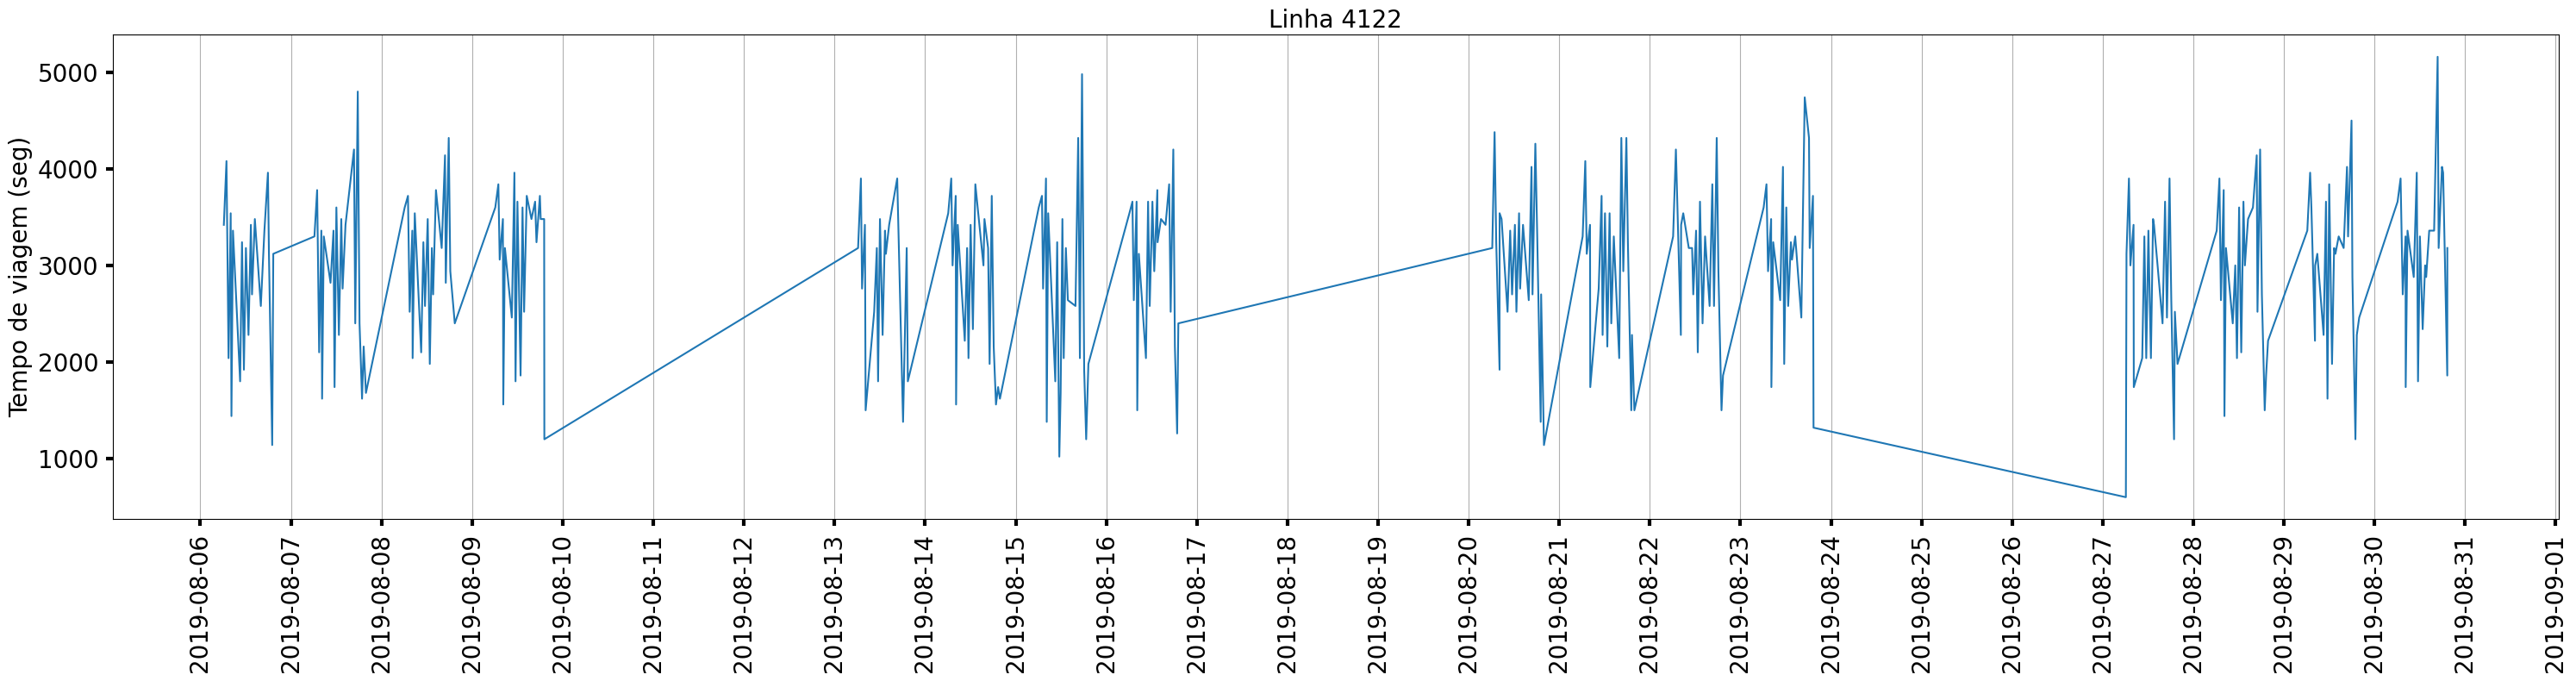

In [39]:
rota = "4122"

a = df.groupby('Linha')['DuraçãoViagem'].std().reset_index().sort_values(by='DuraçãoViagem').reset_index(drop=True)
print(a)
df_plot = df.loc[df['Linha'] == rota][['Ini','DuraçãoViagem']].sort_values(by='Ini')
df_plot = df_plot[(df_plot["Ini"] > "2019-08-04") & (df_plot["Ini"] < "2019-08-31")]
df_plot.set_index('Ini', inplace=True)

import matplotlib.dates as mdates

plt.figure(figsize=(30, 8))
plt.plot(df_plot.index, df_plot['DuraçãoViagem'])
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylabel('Tempo de viagem (seg)', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.tick_params(axis='both', which='both', width=3, length=6, pad=6)
plt.grid(axis="x")
plt.title(f'Linha {rota}', fontsize=20)
plt.tight_layout()
# plt.savefig(f"Images/rota_{rota}.svg")
plt.show()


In [40]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b

,Teste,Data,Rota,Modelo,Valor
0,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,XGBoost,4184.473145
1,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,Random Forest,3987.600000
2,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,Linear Regression,4011.229328
3,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 19:44:00,1120,Tempo real,3600.000000
4,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-10-31 18:26:00,1120,XGBoost,4471.656250
...,...,...,...,...,...
46455,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 17:02:00,605,Tempo real,2880.000000
46456,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 16:08:00,605,XGBoost,3677.500244
46457,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 16:08:00,605,Random Forest,3477.280000
46458,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",2019-07-18 16:08:00,605,Linear Regression,3311.376363


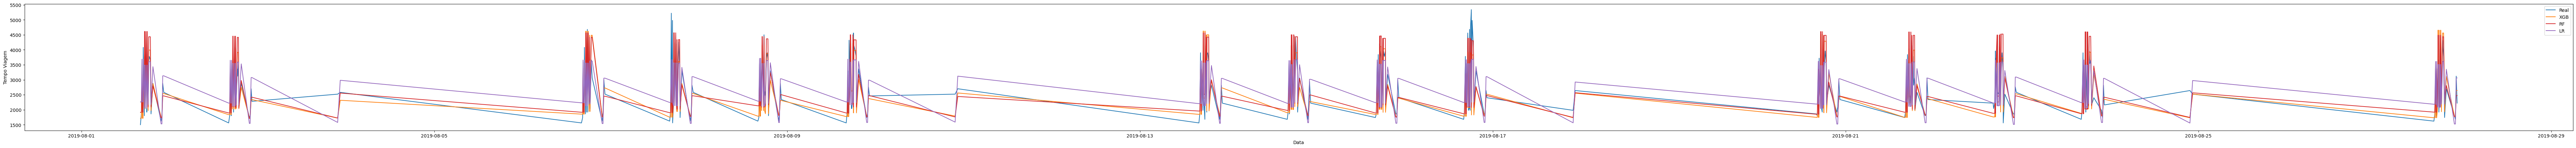

In [41]:
b = pd.DataFrame(predictions, columns=['Teste','Data','Rota','Modelo','Valor'])
b["Data"] = pd.to_datetime(b["Data"]) 
b = b.sort_values(by=["Data"], ascending=False)

plt.figure(figsize=(100, 5))

plt.xlabel("Data")
plt.ylabel("Tempo Viagem")

b = b.loc[(b["Data"] > "2019-08-01") & (b["Data"] < "2019-08-28") & (b['Rota'] == '235')]

real_plor = b.loc[b['Modelo'] == 'Tempo real']
plt.plot(real_plor["Data"], real_plor["Valor"], color="#1f77b4", label="Real")

xgb_plot = b.loc[b['Modelo'] == 'XGBoost']
plt.plot(xgb_plot["Data"], xgb_plot["Valor"], color="#ff7f0e", label="XGB")

rf_plot = b.loc[b['Modelo'] == 'Random Forest']
plt.plot(rf_plot["Data"], rf_plot["Valor"], color="#d62728", label="RF")

lr_plot = b.loc[b['Modelo'] == 'Linear Regression']
plt.plot(lr_plot["Data"], lr_plot["Valor"], color="#9467bd", label="LR")

plt.legend()
plt.show()
#plt.savefig(f"Images/previsao_235.jpg")

In [42]:
df.loc[df["Linha"] == "4122"].groupby(["KmPerc", "Sentido"]).size()

KmPerc  Sentido
11.960  1          1897
25.244  0          2144
dtype: int64

In [43]:
df.corr()

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Sentido,DuraçãoViagem,TotalGiros,KmPerc,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean
Sentido,1.000000,-0.038344,-0.130788,-0.078349,-0.004656,0.071973,-0.000195,-0.000030,0.066639,0.012892
DuraçãoViagem,-0.038344,1.000000,0.378288,0.859106,-0.004924,-0.104892,-0.043986,-0.044402,-0.140044,0.391133
TotalGiros,-0.130788,0.378288,1.000000,0.328887,-0.055781,0.061999,-0.012069,-0.011626,-0.046107,0.554278
KmPerc,-0.078349,0.859106,0.328887,1.000000,0.020420,-0.072912,-0.037748,-0.038264,-0.078560,0.450928
dia_semana,-0.004656,-0.004924,-0.055781,0.020420,1.000000,-0.015228,-0.006944,-0.006878,-0.007397,0.010385
hora_dia,0.071973,-0.104892,0.061999,-0.072912,-0.015228,1.000000,0.002601,0.002476,0.727504,0.079882
dia_ano,-0.000195,-0.043986,-0.012069,-0.037748,-0.006944,0.002601,1.000000,0.996500,0.003367,-0.020454
mes_ano,-0.000030,-0.044402,-0.011626,-0.038264,-0.006878,0.002476,0.996500,1.000000,0.003486,-0.019513
turno_dia,0.066639,-0.140044,-0.046107,-0.078560,-0.007397,0.727504,0.003367,0.003486,1.000000,-0.057598
TotalGirosMean,0.012892,0.391133,0.554278,0.450928,0.010385,0.079882,-0.020454,-0.019513,-0.057598,1.000000


# Permuta

In [44]:
Colunas = [
    [
        ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','hora_dia','dia_ano'],
        ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['dia_semana','hora_dia','dia_ano']
    ],
    [
        ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','hora_dia','dia_ano'],
        ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
        ['dia_semana','hora_dia','dia_ano'],
        ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
        ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano'],
        ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
        ['KmPerc','dia_semana','hora_dia','dia_ano'],
    ]
]
TestesNome = [
    [
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']"
    ],
    [
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
        "1 Teste de Colunas - ['KmPerc','dia_semana','hora_dia','dia_ano']"
    ]
]

# Colunas235 = [
#     ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano'],
#     ['Sentido','dia_semana','hora_dia','dia_ano'],
#     ['TotalGirosMean','dia_semana','hora_dia','dia_ano'],
#     ['dia_semana','hora_dia','dia_ano']
#     ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
#     ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano'],
#     ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano'],
#     ['KmPerc','dia_semana','hora_dia','dia_ano'],
# ]
# TestesNome235 = [
#     "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['Sentido','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['TotalGirosMean','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['dia_semana','hora_dia','dia_ano']"
#     "1 Teste de Colunas - ['Sentido','TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['Sentido','dia_semana','KmPerc','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['TotalGirosMean','KmPerc','dia_semana','hora_dia','dia_ano']",
#     "1 Teste de Colunas - ['KmPerc','dia_semana','hora_dia','dia_ano']"
# ]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]

    teste_atual = 0 if rota != "235" else 1

    for i in range(len(TestesNome[teste_atual])):
        teste_nome = TestesNome[teste_atual][i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[teste_atual][i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[teste_atual][i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.68083
[3]	validation_0-rmse:1024.18370
[4]	validation_0-rmse:768.71614
[5]	validation_0-rmse:601.40748
[6]	validation_0-rmse:496.68425
[7]	validation_0-rmse:432.87627
[8]	validation_0-rmse:394.61285
[9]	validation_0-rmse:370.44435
[10]	validation_0-rmse:357.12341
[11]	validation_0-rmse:347.86716
[12]	validation_0-rmse:342.78816
[13]	validation_0-rmse:339.77326
[14]	validation_0-rmse:336.65660
[15]	validation_0-rmse:334.14750
[16]	validation_0-rmse:331.30526
[17]	validation_0-rmse:329.13079
[18]	validation_0-rmse:323.01812
[19]	validation_0-rmse:320.56431
[20]	validation_0-rmse:319.20777
[21]	validation_0-rmse:317.28602
[22]	validation_0-rmse:315.55828
[23]	validation_0-rmse:312.62790
[24]	validation_0-rmse:311.91820
[25]	validation_0-rmse:310.79285
[26]	validation_0-rmse:306.81700
[27]	validation_0-rmse:303.73995
[28]	validation_0-rmse:302.14782
[29]	validation_0-rmse:300.27992
[30]	validation_

[50]	validation_0-rmse:258.25757
[51]	validation_0-rmse:256.04916
[52]	validation_0-rmse:254.36316
[53]	validation_0-rmse:252.64446
[54]	validation_0-rmse:249.78629
[55]	validation_0-rmse:249.31348
[56]	validation_0-rmse:248.38741
[57]	validation_0-rmse:246.86232
[58]	validation_0-rmse:244.80901
[59]	validation_0-rmse:243.35875
[60]	validation_0-rmse:241.92582
[61]	validation_0-rmse:241.09986
[62]	validation_0-rmse:238.92956
[63]	validation_0-rmse:238.03047
[64]	validation_0-rmse:237.08203
[65]	validation_0-rmse:235.22758
[66]	validation_0-rmse:234.67247
[67]	validation_0-rmse:232.07660
[68]	validation_0-rmse:230.86665
[69]	validation_0-rmse:229.74376
[70]	validation_0-rmse:229.55730
[71]	validation_0-rmse:228.80992
[72]	validation_0-rmse:227.68158
[73]	validation_0-rmse:226.58360
[74]	validation_0-rmse:225.37085
[75]	validation_0-rmse:224.36432
[76]	validation_0-rmse:223.89547
[77]	validation_0-rmse:223.05767
[78]	validation_0-rmse:222.67042
[79]	validation_0-rmse:220.97310
[80]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2761.67779
[1]	validation_0-rmse:1958.67208
[2]	validation_0-rmse:1403.70822
[3]	validation_0-rmse:1024.25842
[4]	validation_0-rmse:769.27525
[5]	validation_0-rmse:601.62521
[6]	validation_0-rmse:495.74784
[7]	validation_0-rmse:431.10795
[8]	validation_0-rmse:393.28974
[9]	validation_0-rmse:368.93159
[10]	validation_0-rmse:355.94972
[11]	validation_0-rmse:348.26118
[12]	validation_0-rmse:340.75395
[13]	validation_0-rmse:336.83992
[14]	validation_0-rmse:331.77629
[15]	validation_0-rmse:329.56415
[16]	validation_0-rmse:324.70476
[17]	validation_0-rmse:320.66385
[18]	validation_0-rmse:318.85474
[19]	validation_0-rmse:315.97978
[20]	validation_0-rmse:313.64703
[21]	validation_0-rmse:311.57236
[22]	validation_0-rmse:310.12285
[23]	validation_0-rmse:307.25160
[24]	validation_0-rmse:305.74644
[25]	validation_0-rmse:304.62724
[26]	validation_0-rmse:302.78519
[27]	validation_0-rmse:300.15243
[28]	validation_0-rmse:297.91988
[29]	validation_0-rmse:295.91563
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2765.15584
[1]	validation_0-rmse:1966.48574
[2]	validation_0-rmse:1417.30257
[3]	validation_0-rmse:1045.43948
[4]	validation_0-rmse:798.89207
[5]	validation_0-rmse:642.02716
[6]	validation_0-rmse:547.41115
[7]	validation_0-rmse:489.83772
[8]	validation_0-rmse:457.32275
[9]	validation_0-rmse:439.15274
[10]	validation_0-rmse:426.94171
[11]	validation_0-rmse:420.58301
[12]	validation_0-rmse:416.09126
[13]	validation_0-rmse:411.70555
[14]	validation_0-rmse:407.93010
[15]	validation_0-rmse:406.50272
[16]	validation_0-rmse:404.50448
[17]	validation_0-rmse:402.49981
[18]	validation_0-rmse:401.04070
[19]	validation_0-rmse:399.18226
[20]	validation_0-rmse:398.65726
[21]	validation_0-rmse:396.39256
[22]	validation_0-rmse:395.15294
[23]	validation_0-rmse:393.81133
[24]	validation_0-rmse:392.86418
[25]	validation_0-rmse:390.48672
[26]	validation_0-rmse:389.35260
[27]	validation_0-rmse:388.44079
[28]	validation_0-rmse:388.20665
[29]	validation_0-rmse:386.56746
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2765.35389
[1]	validation_0-rmse:1967.62953
[2]	validation_0-rmse:1420.07491
[3]	validation_0-rmse:1046.59038
[4]	validation_0-rmse:801.32759
[5]	validation_0-rmse:645.18656
[6]	validation_0-rmse:547.94268
[7]	validation_0-rmse:491.35011
[8]	validation_0-rmse:460.11258
[9]	validation_0-rmse:441.06926
[10]	validation_0-rmse:430.48681
[11]	validation_0-rmse:423.55475
[12]	validation_0-rmse:419.10157
[13]	validation_0-rmse:417.40549
[14]	validation_0-rmse:414.30434
[15]	validation_0-rmse:411.68147
[16]	validation_0-rmse:408.52617
[17]	validation_0-rmse:405.80027
[18]	validation_0-rmse:404.89515
[19]	validation_0-rmse:402.31800
[20]	validation_0-rmse:401.32609
[21]	validation_0-rmse:399.92857
[22]	validation_0-rmse:399.16675
[23]	validation_0-rmse:397.50690
[24]	validation_0-rmse:396.82299
[25]	validation_0-rmse:395.40515
[26]	validation_0-rmse:394.56919
[27]	validation_0-rmse:393.18978
[28]	validation_0-rmse:390.52023
[29]	validation_0-rmse:389.13833
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.92089
[2]	validation_0-rmse:1007.22562
[3]	validation_0-rmse:748.85870
[4]	validation_0-rmse:574.14905
[5]	validation_0-rmse:462.33104
[6]	validation_0-rmse:393.35703
[7]	validation_0-rmse:353.16455
[8]	validation_0-rmse:327.90987
[9]	validation_0-rmse:311.49236
[10]	validation_0-rmse:300.47711
[11]	validation_0-rmse:295.09310
[12]	validation_0-rmse:289.83082
[13]	validation_0-rmse:285.71574
[14]	validation_0-rmse:281.68704
[15]	validation_0-rmse:279.32180
[16]	validation_0-rmse:276.46162
[17]	validation_0-rmse:274.60451
[18]	validation_0-rmse:272.54790
[19]	validation_0-rmse:270.96056
[20]	validation_0-rmse:269.04897
[21]	validation_0-rmse:266.25871
[22]	validation_0-rmse:265.05888
[23]	validation_0-rmse:263.83921
[24]	validation_0-rmse:263.03021
[25]	validation_0-rmse:261.66532
[26]	validation_0-rmse:259.85632
[27]	validation_0-rmse:258.64231
[28]	validation_0-rmse:257.56088
[29]	validation_0-rmse:256.98769
[30]	validation_0-rmse:256.22327
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1386.59793
[2]	validation_0-rmse:1006.76111
[3]	validation_0-rmse:750.32720
[4]	validation_0-rmse:579.66985
[5]	validation_0-rmse:473.09113
[6]	validation_0-rmse:403.68452
[7]	validation_0-rmse:363.20617
[8]	validation_0-rmse:338.34727
[9]	validation_0-rmse:321.77823
[10]	validation_0-rmse:312.33654
[11]	validation_0-rmse:305.89420
[12]	validation_0-rmse:300.28425
[13]	validation_0-rmse:296.59024
[14]	validation_0-rmse:293.66058
[15]	validation_0-rmse:291.37031
[16]	validation_0-rmse:288.28671
[17]	validation_0-rmse:287.24047
[18]	validation_0-rmse:285.59877
[19]	validation_0-rmse:282.80931
[20]	validation_0-rmse:282.07023
[21]	validation_0-rmse:278.33268
[22]	validation_0-rmse:275.45560
[23]	validation_0-rmse:272.23720
[24]	validation_0-rmse:270.90730
[25]	validation_0-rmse:270.31656
[26]	validation_0-rmse:269.81228
[27]	validation_0-rmse:268.26540
[28]	validation_0-rmse:266.10246
[29]	validation_0-rmse:264.82648
[30]	validation_0-rmse:264.31333
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1989.85359
[1]	validation_0-rmse:1488.24339
[2]	validation_0-rmse:1163.88906
[3]	validation_0-rmse:963.41479
[4]	validation_0-rmse:845.82361
[5]	validation_0-rmse:780.34992
[6]	validation_0-rmse:744.47761
[7]	validation_0-rmse:724.11228
[8]	validation_0-rmse:713.05771
[9]	validation_0-rmse:705.91330
[10]	validation_0-rmse:702.34303
[11]	validation_0-rmse:700.19109
[12]	validation_0-rmse:698.18395
[13]	validation_0-rmse:697.13111
[14]	validation_0-rmse:695.65354
[15]	validation_0-rmse:694.42094
[16]	validation_0-rmse:693.68565
[17]	validation_0-rmse:692.79872
[18]	validation_0-rmse:692.52827
[19]	validation_0-rmse:691.99902
[20]	validation_0-rmse:691.57399
[21]	validation_0-rmse:691.20474
[22]	validation_0-rmse:690.86079
[23]	validation_0-rmse:690.57233
[24]	validation_0-rmse:690.18522
[25]	validation_0-rmse:689.75919
[26]	validation_0-rmse:688.87229
[27]	validation_0-rmse:688.50388
[28]	validation_0-rmse:688.31300
[29]	validation_0-rmse:688.17790
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1487.84254
[2]	validation_0-rmse:1163.79515
[3]	validation_0-rmse:963.22230
[4]	validation_0-rmse:846.23172
[5]	validation_0-rmse:779.65430
[6]	validation_0-rmse:743.81047
[7]	validation_0-rmse:725.06489
[8]	validation_0-rmse:714.27222
[9]	validation_0-rmse:708.19343
[10]	validation_0-rmse:704.38229
[11]	validation_0-rmse:702.28078
[12]	validation_0-rmse:699.32789
[13]	validation_0-rmse:697.95665
[14]	validation_0-rmse:697.29901
[15]	validation_0-rmse:696.24558
[16]	validation_0-rmse:695.66714
[17]	validation_0-rmse:695.13479
[18]	validation_0-rmse:694.55942
[19]	validation_0-rmse:694.21864
[20]	validation_0-rmse:693.51041
[21]	validation_0-rmse:692.96513
[22]	validation_0-rmse:692.50374
[23]	validation_0-rmse:691.99631
[24]	validation_0-rmse:691.92355
[25]	validation_0-rmse:691.57954
[26]	validation_0-rmse:691.12779
[27]	validation_0-rmse:690.52662
[28]	validation_0-rmse:690.30718
[29]	validation_0-rmse:690.00033
[30]	validation_0-rmse:689.76848
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:300.54646
[12]	validation_0-rmse:295.18842
[13]	validation_0-rmse:289.80066
[14]	validation_0-rmse:285.18822
[15]	validation_0-rmse:280.43766
[16]	validation_0-rmse:278.37057
[17]	validation_0-rmse:274.45454
[18]	validation_0-rmse:273.20588
[19]	validation_0-rmse:270.51891
[20]	validation_0-rmse:269.22954
[21]	validation_0-rmse:266.22832
[22]	validation_0-rmse:264.67541
[23]	validation_0-rmse:263.21329
[24]	validation_0-rmse:262.03386
[25]	validation_0-rmse:260.13057
[26]	validation_0-rmse:258.07684
[27]	validation_0-rmse:257.30452
[28]	validation_0-rmse:256.11055
[29]	validation_0-rmse:255.75512
[30]	validation_0-rmse:253.63215
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1386.52954
[2]	validation_0-rmse:1006.41755
[3]	validation_0-rmse:749.86590
[4]	validation_0-rmse:578.41495
[5]	validation_0-rmse:470.68751
[6]	validation_0-rmse:403.72524
[7]	validation_0-rmse:363.68079
[8]	validation_0-rmse:336.75132
[9]	validation_0-rmse:319.24172
[10]	validation_0-rmse:309.77411
[11]	validation_0-rmse:304.07829
[12]	validation_0-rmse:299.34739
[13]	validation_0-rmse:294.29440
[14]	validation_0-rmse:288.92259
[15]	validation_0-rmse:284.24171
[16]	validation_0-rmse:281.53627
[17]	validation_0-rmse:278.81148
[18]	validation_0-rmse:277.60190
[19]	validation_0-rmse:275.97137
[20]	validation_0-rmse:273.15433
[21]	validation_0-rmse:272.61487
[22]	validation_0-rmse:270.86359
[23]	validation_0-rmse:269.97471
[24]	validation_0-rmse:269.13025
[25]	validation_0-rmse:267.26495
[26]	validation_0-rmse:266.33071
[27]	validation_0-rmse:263.57038
[28]	validation_0-rmse:263.16726
[29]	validation_0-rmse:263.06219
[30]	validation_0-rmse:261.96830
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1387.73944
[2]	validation_0-rmse:1006.96975
[3]	validation_0-rmse:750.47421
[4]	validation_0-rmse:577.09250
[5]	validation_0-rmse:468.71314
[6]	validation_0-rmse:402.60223
[7]	validation_0-rmse:364.23219
[8]	validation_0-rmse:337.27774
[9]	validation_0-rmse:318.88808
[10]	validation_0-rmse:307.86984
[11]	validation_0-rmse:298.05476
[12]	validation_0-rmse:294.08783
[13]	validation_0-rmse:289.74135
[14]	validation_0-rmse:285.31825
[15]	validation_0-rmse:281.24445
[16]	validation_0-rmse:279.88015
[17]	validation_0-rmse:275.86879
[18]	validation_0-rmse:271.72845
[19]	validation_0-rmse:270.67988
[20]	validation_0-rmse:267.04190
[21]	validation_0-rmse:266.10947
[22]	validation_0-rmse:264.63115
[23]	validation_0-rmse:262.94467
[24]	validation_0-rmse:261.74402
[25]	validation_0-rmse:259.91451
[26]	validation_0-rmse:257.94960
[27]	validation_0-rmse:256.91641
[28]	validation_0-rmse:255.52939
[29]	validation_0-rmse:254.75153
[30]	validation_0-rmse:254.11165
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1386.52954
[2]	validation_0-rmse:1006.41755
[3]	validation_0-rmse:749.86590
[4]	validation_0-rmse:578.41495
[5]	validation_0-rmse:470.68751
[6]	validation_0-rmse:403.72524
[7]	validation_0-rmse:363.68079
[8]	validation_0-rmse:336.75132
[9]	validation_0-rmse:321.80838
[10]	validation_0-rmse:312.19539
[11]	validation_0-rmse:302.95139
[12]	validation_0-rmse:300.05639
[13]	validation_0-rmse:296.04777
[14]	validation_0-rmse:291.73860
[15]	validation_0-rmse:288.66679
[16]	validation_0-rmse:284.10246
[17]	validation_0-rmse:281.97982
[18]	validation_0-rmse:278.35795
[19]	validation_0-rmse:277.26693
[20]	validation_0-rmse:276.00777
[21]	validation_0-rmse:273.11481
[22]	validation_0-rmse:271.99689
[23]	validation_0-rmse:270.61945
[24]	validation_0-rmse:269.96911
[25]	validation_0-rmse:269.01268
[26]	validation_0-rmse:266.83584
[27]	validation_0-rmse:265.92854
[28]	validation_0-rmse:265.31984
[29]	validation_0-rmse:263.63666
[30]	validation_0-rmse:261.62704
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1014.32796
[1]	validation_0-rmse:721.30449
[2]	validation_0-rmse:520.01768
[3]	validation_0-rmse:383.69737
[4]	validation_0-rmse:292.86982
[5]	validation_0-rmse:236.04899
[6]	validation_0-rmse:201.69334
[7]	validation_0-rmse:182.51564
[8]	validation_0-rmse:172.02823
[9]	validation_0-rmse:166.16801
[10]	validation_0-rmse:162.40734
[11]	validation_0-rmse:159.53501
[12]	validation_0-rmse:156.98306
[13]	validation_0-rmse:155.81482
[14]	validation_0-rmse:155.24720
[15]	validation_0-rmse:154.82973
[16]	validation_0-rmse:153.41932
[17]	validation_0-rmse:152.18165
[18]	validation_0-rmse:151.68424
[19]	validation_0-rmse:150.75104
[20]	validation_0-rmse:149.33459
[21]	validation_0-rmse:149.06063
[22]	validation_0-rmse:148.05673
[23]	validation_0-rmse:147.59353
[24]	validation_0-rmse:147.12460
[25]	validation_0-rmse:146.06885
[26]	validation_0-rmse:145.88036
[27]	validation_0-rmse:145.33102
[28]	validation_0-rmse:144.44346
[29]	validation_0-rmse:144.33721
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1014.32796
[1]	validation_0-rmse:721.16421
[2]	validation_0-rmse:519.28682
[3]	validation_0-rmse:382.41437
[4]	validation_0-rmse:291.55778
[5]	validation_0-rmse:233.80337
[6]	validation_0-rmse:199.33397
[7]	validation_0-rmse:178.61533
[8]	validation_0-rmse:167.88672
[9]	validation_0-rmse:161.28809
[10]	validation_0-rmse:157.82883
[11]	validation_0-rmse:155.88967
[12]	validation_0-rmse:154.78114
[13]	validation_0-rmse:154.11768
[14]	validation_0-rmse:152.76028
[15]	validation_0-rmse:152.35427
[16]	validation_0-rmse:151.92464
[17]	validation_0-rmse:150.43409
[18]	validation_0-rmse:149.67140
[19]	validation_0-rmse:149.46836
[20]	validation_0-rmse:148.51480
[21]	validation_0-rmse:148.11635
[22]	validation_0-rmse:147.50787
[23]	validation_0-rmse:146.12927
[24]	validation_0-rmse:145.67500
[25]	validation_0-rmse:144.90317
[26]	validation_0-rmse:144.32824
[27]	validation_0-rmse:143.46554
[28]	validation_0-rmse:142.79620
[29]	validation_0-rmse:142.35678
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1015.52213
[1]	validation_0-rmse:723.69595
[2]	validation_0-rmse:523.99652
[3]	validation_0-rmse:389.91880
[4]	validation_0-rmse:302.56013
[5]	validation_0-rmse:248.02547
[6]	validation_0-rmse:215.03565
[7]	validation_0-rmse:196.60533
[8]	validation_0-rmse:186.98859
[9]	validation_0-rmse:181.20154
[10]	validation_0-rmse:178.39108
[11]	validation_0-rmse:175.77540
[12]	validation_0-rmse:174.42738
[13]	validation_0-rmse:173.55140
[14]	validation_0-rmse:172.89770
[15]	validation_0-rmse:172.31379
[16]	validation_0-rmse:172.00711
[17]	validation_0-rmse:171.37668
[18]	validation_0-rmse:170.85147
[19]	validation_0-rmse:170.72030
[20]	validation_0-rmse:170.19850
[21]	validation_0-rmse:169.59694
[22]	validation_0-rmse:168.94915
[23]	validation_0-rmse:168.84800
[24]	validation_0-rmse:168.45009
[25]	validation_0-rmse:168.32315
[26]	validation_0-rmse:167.80210
[27]	validation_0-rmse:167.62681
[28]	validation_0-rmse:167.34214
[29]	validation_0-rmse:167.04988
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1015.50283
[1]	validation_0-rmse:723.55308
[2]	validation_0-rmse:523.48205
[3]	validation_0-rmse:389.04094
[4]	validation_0-rmse:301.37043
[5]	validation_0-rmse:246.75793
[6]	validation_0-rmse:214.68727
[7]	validation_0-rmse:197.05245
[8]	validation_0-rmse:187.05245
[9]	validation_0-rmse:181.61492
[10]	validation_0-rmse:178.56048
[11]	validation_0-rmse:176.10488
[12]	validation_0-rmse:175.26623
[13]	validation_0-rmse:174.32670
[14]	validation_0-rmse:173.65759
[15]	validation_0-rmse:172.90858
[16]	validation_0-rmse:172.03663
[17]	validation_0-rmse:171.56820
[18]	validation_0-rmse:171.35962
[19]	validation_0-rmse:170.63070
[20]	validation_0-rmse:170.27794
[21]	validation_0-rmse:169.69107
[22]	validation_0-rmse:169.46605
[23]	validation_0-rmse:168.88606
[24]	validation_0-rmse:168.79116
[25]	validation_0-rmse:168.62989
[26]	validation_0-rmse:168.31456
[27]	validation_0-rmse:168.04886
[28]	validation_0-rmse:167.60865
[29]	validation_0-rmse:166.99935
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.73921
[1]	validation_0-rmse:437.18497
[2]	validation_0-rmse:324.56813
[3]	validation_0-rmse:250.55170
[4]	validation_0-rmse:204.05507
[5]	validation_0-rmse:175.79365
[6]	validation_0-rmse:159.27288
[7]	validation_0-rmse:150.01033
[8]	validation_0-rmse:144.55710
[9]	validation_0-rmse:141.47444
[10]	validation_0-rmse:138.69459
[11]	validation_0-rmse:136.18277
[12]	validation_0-rmse:135.43487
[13]	validation_0-rmse:135.00958
[14]	validation_0-rmse:134.21333
[15]	validation_0-rmse:133.11017
[16]	validation_0-rmse:131.95821
[17]	validation_0-rmse:131.64292
[18]	validation_0-rmse:131.37758
[19]	validation_0-rmse:130.90655
[20]	validation_0-rmse:130.16379
[21]	validation_0-rmse:129.20634
[22]	validation_0-rmse:128.52396
[23]	validation_0-rmse:128.25757
[24]	validation_0-rmse:127.44741
[25]	validation_0-rmse:126.95012
[26]	validation_0-rmse:126.43814
[27]	validation_0-rmse:125.70047
[28]	validation_0-rmse:125.47579
[29]	validation_0-rmse:124.92169
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.74450
[1]	validation_0-rmse:437.19848
[2]	validation_0-rmse:324.83050
[3]	validation_0-rmse:250.75008
[4]	validation_0-rmse:204.39606
[5]	validation_0-rmse:176.22571
[6]	validation_0-rmse:159.71031
[7]	validation_0-rmse:150.81722
[8]	validation_0-rmse:145.73327
[9]	validation_0-rmse:142.57521
[10]	validation_0-rmse:140.77934
[11]	validation_0-rmse:139.52371
[12]	validation_0-rmse:137.91941
[13]	validation_0-rmse:136.10696
[14]	validation_0-rmse:135.32478
[15]	validation_0-rmse:134.62542
[16]	validation_0-rmse:133.49382
[17]	validation_0-rmse:132.43161
[18]	validation_0-rmse:132.10315
[19]	validation_0-rmse:131.33572
[20]	validation_0-rmse:130.94089
[21]	validation_0-rmse:130.19724
[22]	validation_0-rmse:129.78588
[23]	validation_0-rmse:129.50608
[24]	validation_0-rmse:128.66098
[25]	validation_0-rmse:128.18759
[26]	validation_0-rmse:127.51231
[27]	validation_0-rmse:126.92444
[28]	validation_0-rmse:126.13194
[29]	validation_0-rmse:125.48209
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.76555
[1]	validation_0-rmse:439.61598
[2]	validation_0-rmse:328.55715
[3]	validation_0-rmse:256.27353
[4]	validation_0-rmse:211.69078
[5]	validation_0-rmse:185.01225
[6]	validation_0-rmse:169.64581
[7]	validation_0-rmse:161.49474
[8]	validation_0-rmse:156.77122
[9]	validation_0-rmse:154.38972
[10]	validation_0-rmse:152.54070
[11]	validation_0-rmse:151.45768
[12]	validation_0-rmse:150.91490
[13]	validation_0-rmse:150.15952
[14]	validation_0-rmse:148.82709
[15]	validation_0-rmse:148.22693
[16]	validation_0-rmse:147.33356
[17]	validation_0-rmse:146.72575
[18]	validation_0-rmse:146.15972
[19]	validation_0-rmse:145.67145
[20]	validation_0-rmse:145.12513
[21]	validation_0-rmse:144.45179
[22]	validation_0-rmse:143.93247
[23]	validation_0-rmse:143.81846
[24]	validation_0-rmse:143.25947
[25]	validation_0-rmse:142.96396
[26]	validation_0-rmse:142.67651
[27]	validation_0-rmse:142.54278
[28]	validation_0-rmse:142.29760
[29]	validation_0-rmse:141.91455
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.76555
[1]	validation_0-rmse:439.61598
[2]	validation_0-rmse:328.57887
[3]	validation_0-rmse:256.39670
[4]	validation_0-rmse:211.65758
[5]	validation_0-rmse:185.07485
[6]	validation_0-rmse:170.33395
[7]	validation_0-rmse:162.24786
[8]	validation_0-rmse:157.98436
[9]	validation_0-rmse:155.25555
[10]	validation_0-rmse:153.10657
[11]	validation_0-rmse:152.27058
[12]	validation_0-rmse:151.54962
[13]	validation_0-rmse:151.13481
[14]	validation_0-rmse:150.37270
[15]	validation_0-rmse:149.75556
[16]	validation_0-rmse:148.83733
[17]	validation_0-rmse:148.33425
[18]	validation_0-rmse:147.67228
[19]	validation_0-rmse:147.47659
[20]	validation_0-rmse:147.08548
[21]	validation_0-rmse:146.65939
[22]	validation_0-rmse:146.62627
[23]	validation_0-rmse:146.36401
[24]	validation_0-rmse:145.91713
[25]	validation_0-rmse:145.61588
[26]	validation_0-rmse:145.18612
[27]	validation_0-rmse:144.79877
[28]	validation_0-rmse:144.32055
[29]	validation_0-rmse:144.08088
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2259.62983
[1]	validation_0-rmse:1621.20862
[2]	validation_0-rmse:1183.72499
[3]	validation_0-rmse:888.87951
[4]	validation_0-rmse:695.56787
[5]	validation_0-rmse:570.77886
[6]	validation_0-rmse:496.75807
[7]	validation_0-rmse:450.73670
[8]	validation_0-rmse:425.68055
[9]	validation_0-rmse:407.03411
[10]	validation_0-rmse:398.12362
[11]	validation_0-rmse:389.65748
[12]	validation_0-rmse:385.42991
[13]	validation_0-rmse:381.35636
[14]	validation_0-rmse:376.21088
[15]	validation_0-rmse:372.62739
[16]	validation_0-rmse:369.29024
[17]	validation_0-rmse:363.55499
[18]	validation_0-rmse:360.84073
[19]	validation_0-rmse:360.13643
[20]	validation_0-rmse:357.42087
[21]	validation_0-rmse:353.83128
[22]	validation_0-rmse:352.84695
[23]	validation_0-rmse:350.25943
[24]	validation_0-rmse:346.22833
[25]	validation_0-rmse:345.75525
[26]	validation_0-rmse:342.05751
[27]	validation_0-rmse:339.23835
[28]	validation_0-rmse:335.75313
[29]	validation_0-rmse:333.27042
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2259.53730
[1]	validation_0-rmse:1622.28403
[2]	validation_0-rmse:1185.60139
[3]	validation_0-rmse:890.80426
[4]	validation_0-rmse:697.88651
[5]	validation_0-rmse:573.47921
[6]	validation_0-rmse:497.63562
[7]	validation_0-rmse:453.83040
[8]	validation_0-rmse:427.57966
[9]	validation_0-rmse:411.52165
[10]	validation_0-rmse:401.64728
[11]	validation_0-rmse:393.45269
[12]	validation_0-rmse:386.67395
[13]	validation_0-rmse:381.33080
[14]	validation_0-rmse:376.69398
[15]	validation_0-rmse:372.17760
[16]	validation_0-rmse:367.08151
[17]	validation_0-rmse:364.48331
[18]	validation_0-rmse:362.49771
[19]	validation_0-rmse:357.33110
[20]	validation_0-rmse:354.64414
[21]	validation_0-rmse:352.28166
[22]	validation_0-rmse:350.58560
[23]	validation_0-rmse:348.82448
[24]	validation_0-rmse:345.38112
[25]	validation_0-rmse:343.35663
[26]	validation_0-rmse:340.28342
[27]	validation_0-rmse:338.63999
[28]	validation_0-rmse:337.52521
[29]	validation_0-rmse:336.66328
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1694.36256
[2]	validation_0-rmse:1299.10808
[3]	validation_0-rmse:1048.16737
[4]	validation_0-rmse:896.33848
[5]	validation_0-rmse:809.29166
[6]	validation_0-rmse:760.73517
[7]	validation_0-rmse:734.07273
[8]	validation_0-rmse:719.04447
[9]	validation_0-rmse:710.66716
[10]	validation_0-rmse:704.13139
[11]	validation_0-rmse:700.19562
[12]	validation_0-rmse:695.64931
[13]	validation_0-rmse:694.45956
[14]	validation_0-rmse:693.26429
[15]	validation_0-rmse:690.48815
[16]	validation_0-rmse:689.29339
[17]	validation_0-rmse:688.11573
[18]	validation_0-rmse:685.79261
[19]	validation_0-rmse:684.97820
[20]	validation_0-rmse:683.44088
[21]	validation_0-rmse:680.90066
[22]	validation_0-rmse:679.42522
[23]	validation_0-rmse:677.46239
[24]	validation_0-rmse:675.63321
[25]	validation_0-rmse:674.10429
[26]	validation_0-rmse:672.90781
[27]	validation_0-rmse:671.45569
[28]	validation_0-rmse:670.35453
[29]	validation_0-rmse:668.73456
[30]	validation_0-rmse:666.91192
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1694.35646
[2]	validation_0-rmse:1299.44123
[3]	validation_0-rmse:1048.65986
[4]	validation_0-rmse:898.28203
[5]	validation_0-rmse:810.06370
[6]	validation_0-rmse:760.48287
[7]	validation_0-rmse:734.07416
[8]	validation_0-rmse:719.22872
[9]	validation_0-rmse:710.78023
[10]	validation_0-rmse:704.42111
[11]	validation_0-rmse:700.34745
[12]	validation_0-rmse:697.59970
[13]	validation_0-rmse:695.51400
[14]	validation_0-rmse:693.13215
[15]	validation_0-rmse:692.12191
[16]	validation_0-rmse:690.75790
[17]	validation_0-rmse:688.32476
[18]	validation_0-rmse:686.54652
[19]	validation_0-rmse:685.97597
[20]	validation_0-rmse:684.70437
[21]	validation_0-rmse:683.65160
[22]	validation_0-rmse:682.42529
[23]	validation_0-rmse:681.03213
[24]	validation_0-rmse:680.12471
[25]	validation_0-rmse:679.00185
[26]	validation_0-rmse:677.39437
[27]	validation_0-rmse:676.36320
[28]	validation_0-rmse:675.52379
[29]	validation_0-rmse:674.27051
[30]	validation_0-rmse:673.24457
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1665.20358
[2]	validation_0-rmse:1194.39764
[3]	validation_0-rmse:872.83237
[4]	validation_0-rmse:657.28979
[5]	validation_0-rmse:516.80842
[6]	validation_0-rmse:424.87663
[7]	validation_0-rmse:368.89580
[8]	validation_0-rmse:335.72714
[9]	validation_0-rmse:316.42870
[10]	validation_0-rmse:306.99668
[11]	validation_0-rmse:297.89105
[12]	validation_0-rmse:291.29342
[13]	validation_0-rmse:289.20639
[14]	validation_0-rmse:288.11829
[15]	validation_0-rmse:287.17685
[16]	validation_0-rmse:282.05776
[17]	validation_0-rmse:276.67583
[18]	validation_0-rmse:274.20855
[19]	validation_0-rmse:270.60730
[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[23]	validation_0-rmse:261.96930
[24]	validation_0-rmse:260.08751
[25]	validation_0-rmse:258.92099
[26]	validation_0-rmse:256.77628
[27]	validation_0-rmse:255.47161
[28]	validation_0-rmse:254.66803
[29]	validation_0-rmse:253.27148
[30]	validation_0-rmse:251.95424
[31]	validation_0-rmse:249.17580
[32]	validation_0-rmse:248.10609
[33]	validation_0-rmse:247.24029
[34]	validation_0-rmse:245.48479
[35]	validation_0-rmse:244.58873
[36]	validation_0-rmse:244.35923
[37]	validation_0-rmse:243.79389
[38]	validation_0-rmse:243.63887
[39]	validation_0-rmse:243.53570
[40]	validation_0-rmse:242.32011
[41]	validation_0-rmse:240.83812
[42]	validation_0-rmse:239.46109
[43]	validation_0-rmse:237.84461
[44]	validation_0-rmse:236.83209
[45]	validation_0-rmse:236.76148
[46]	validation_0-rmse:235.52127
[47]	validation_0-rmse:234.64647
[48]	validation_0-rmse:233.80967
[49]	validation_0-rmse:231.92447
[50]	validation_0-rmse:231.34918
[51]	validation_0-rmse:230.85176
[52]	validation_0-rmse:228.93047
[53]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:268.34374
[21]	validation_0-rmse:265.90007
[22]	validation_0-rmse:265.01493
[23]	validation_0-rmse:264.71525
[24]	validation_0-rmse:261.66999
[25]	validation_0-rmse:261.12028
[26]	validation_0-rmse:257.62880
[27]	validation_0-rmse:256.85554
[28]	validation_0-rmse:254.49427
[29]	validation_0-rmse:254.25428
[30]	validation_0-rmse:253.58614
[31]	validation_0-rmse:251.81177
[32]	validation_0-rmse:250.13980
[33]	validation_0-rmse:249.04613
[34]	validation_0-rmse:246.65784
[35]	validation_0-rmse:244.51258
[36]	validation_0-rmse:241.28958
[37]	validation_0-rmse:239.82810
[38]	validation_0-rmse:237.97511
[39]	validation_0-rmse:236.75798
[40]	validation_0-rmse:236.12926
[41]	validation_0-rmse:235.41544
[42]	validation_0-rmse:232.13861
[43]	validation_0-rmse:231.37348
[44]	validation_0-rmse:230.50820
[45]	validation_0-rmse:229.35029
[46]	validation_0-rmse:228.36228
[47]	validation_0-rmse:226.87312
[48]	validation_0-rmse:226.57493
[49]	validation_0-rmse:226.18480
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[21]	validation_0-rmse:267.05107
[22]	validation_0-rmse:263.93697
[23]	validation_0-rmse:261.96930
[24]	validation_0-rmse:260.08751
[25]	validation_0-rmse:258.92099
[26]	validation_0-rmse:256.77628
[27]	validation_0-rmse:255.47161
[28]	validation_0-rmse:254.66803
[29]	validation_0-rmse:253.27148
[30]	validation_0-rmse:251.95424
[31]	validation_0-rmse:249.17580
[32]	validation_0-rmse:248.10609
[33]	validation_0-rmse:247.24029
[34]	validation_0-rmse:245.48479
[35]	validation_0-rmse:244.58873
[36]	validation_0-rmse:244.35923
[37]	validation_0-rmse:243.79389
[38]	validation_0-rmse:243.63887
[39]	validation_0-rmse:243.53570
[40]	validation_0-rmse:242.32011
[41]	validation_0-rmse:240.83812
[42]	validation_0-rmse:239.46109
[43]	validation_0-rmse:237.84461
[44]	validation_0-rmse:236.83209
[45]	validation_0-rmse:236.76148
[46]	validation_0-rmse:235.52127
[47]	validation_0-rmse:234.64647
[48]	validation_0-rmse:233.80967
[49]	validation_0-rmse:231.92447
[50]	validation_0-rmse:231.34918
[51]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [45]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
142,"1 Teste de Colunas - ['Sentido','dia_semana','...",362,Linear Regression,RMSE,165.419098,0.238600,0.15030
136,"1 Teste de Colunas - ['Sentido','TotalGirosMea...",362,Linear Regression,RMSE,165.722145,0.259500,0.99700
22,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",362,Linear Regression,RMSE,166.532178,0.250800,0.99900
132,"1 Teste de Colunas - ['Sentido','TotalGirosMea...",362,XGBoost,RMSE,173.961327,0.226014,0.30010
18,"0 Teste de Colunas - ['Sentido','KmPerc','dia_...",362,XGBoost,RMSE,175.910101,0.254205,0.29910
...,...,...,...,...,...,...,...
82,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Linear Regression,RMSE,861.481548,0.998000,0.99800
78,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,XGBoost,RMSE,866.977726,0.211752,0.30650
80,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Random Forest,RMSE,881.858613,0.357091,0.12681
74,"1 Teste de Colunas - ['TotalGirosMean','dia_se...",235,Random Forest,RMSE,916.753553,0.469882,0.14755


In [53]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost") & (a["Rota"] != "235")]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "Teste 0\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_index()
df

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_xgb.svg")


C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1684063468.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Valor"] = b["Valor"] * 100


AttributeError: 'Index' object has no attribute 'apply'

C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1482546751.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Valor"] = b["Valor"] * 100
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1482546751.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Teste"] = b["Teste"].apply(extrair_valores)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1482546751.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

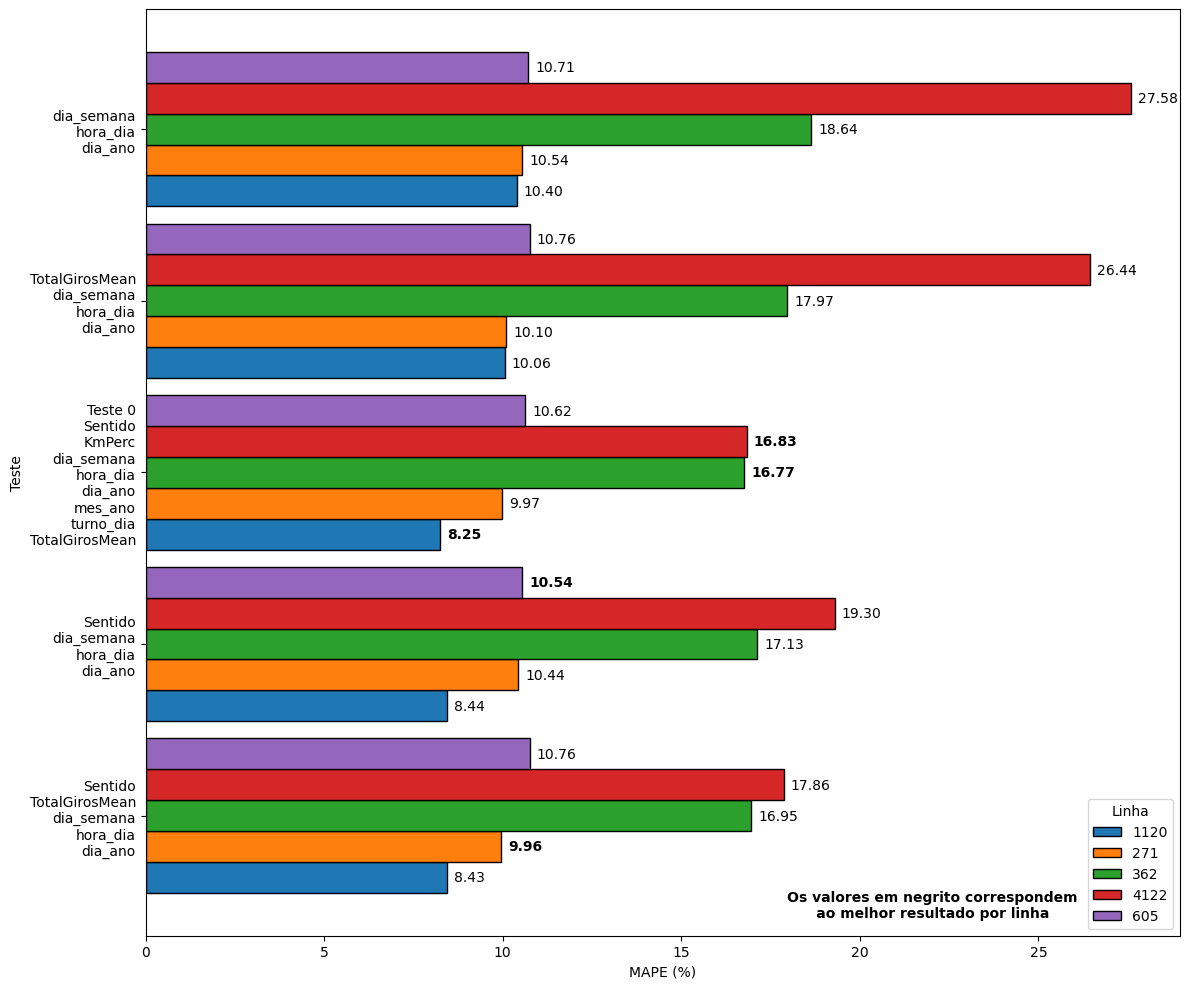

In [47]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest") & (a["Rota"] != "235")]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "Teste 0\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor')

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_rf.svg")


C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1232631565.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Valor"] = b["Valor"] * 100
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1232631565.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Teste"] = b["Teste"].apply(extrair_valores)
C:\Users\leovi\AppData\Local\Temp\ipykernel_25492\1232631565.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

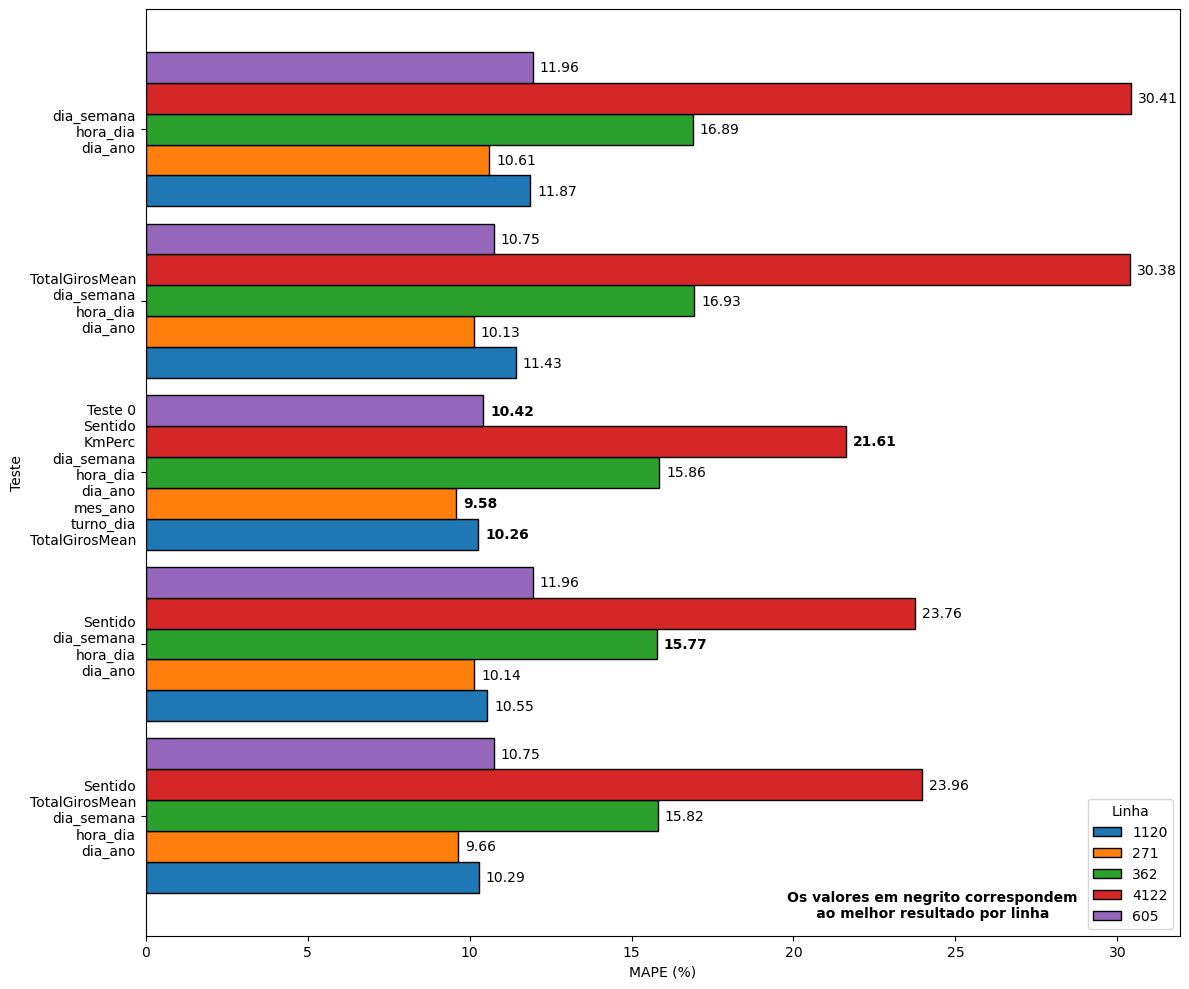

In [48]:
import re

def extrair_valores(text):
    match = re.search(r"\[([^]]+)\]", text)
    if match:
        return match.group(1)
    return ''

b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression") & (a["Rota"] != "235")]
b["Valor"] = b["Valor"] * 100
b["Teste"] = b["Teste"].apply(extrair_valores)
b["Teste"] = b["Teste"].str.replace(",", "\n").str.replace("'", "")
b["Teste"] = b["Teste"].replace({"Sentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean": "Teste 0\nSentido\nKmPerc\ndia_semana\nhora_dia\ndia_ano\nmes_ano\nturno_dia\nTotalGirosMean"})

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor')

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")

ax.legend(title="Linha")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_permutacao_lr.svg")


# Testes tempos anteriores

In [47]:
df["DuraçãoViagem_1"] = df["DuraçãoViagem"]
df["DuraçãoViagem_2"] = df["DuraçãoViagem"]
df["DuraçãoViagem_3"] = df["DuraçãoViagem"]
df["DuraçãoViagem_4"] = df["DuraçãoViagem"]
df["DuraçãoViagem_5"] = df["DuraçãoViagem"]

df['DuraçãoViagem_1'] = df.groupby('Linha')['DuraçãoViagem'].shift(1)
df['DuraçãoViagem_2'] = df.groupby('Linha')['DuraçãoViagem'].shift(2)
df['DuraçãoViagem_3'] = df.groupby('Linha')['DuraçãoViagem'].shift(3)
df['DuraçãoViagem_4'] = df.groupby('Linha')['DuraçãoViagem'].shift(4)
df['DuraçãoViagem_5'] = df.groupby('Linha')['DuraçãoViagem'].shift(5)

df.dropna(subset=['DuraçãoViagem_5'] ,inplace=True)

df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5
29319,0,1120,3960,18,31.218,2018-11-06 09:05:00,2018-11-06 10:11:00,2,9,310,11,2,24.0,3060.0,4320.0,3720.0,4560.0,3420.0
29395,1,1120,3660,16,30.640,2018-11-06 10:20:00,2018-11-06 11:21:00,2,10,310,11,2,5.0,3960.0,3060.0,4320.0,3720.0,4560.0
29320,0,1120,4260,22,31.218,2018-11-06 11:21:00,2018-11-06 12:32:00,2,11,310,11,2,11.0,3660.0,3960.0,3060.0,4320.0,3720.0
29321,1,1120,4080,17,30.640,2018-11-06 11:26:00,2018-11-06 12:34:00,2,11,310,11,2,11.0,4260.0,3660.0,3960.0,3060.0,4320.0
29322,0,1120,4620,10,31.218,2018-11-06 12:34:00,2018-11-06 13:51:00,2,12,310,11,2,15.0,4080.0,4260.0,3660.0,3960.0,3060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35277,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0,3420.0,3360.0,3180.0,3300.0,4620.0
35278,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0,3900.0,3420.0,3360.0,3180.0,3300.0
35279,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5,3780.0,3900.0,3420.0,3360.0,3180.0
35280,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0,3780.0,3780.0,3900.0,3420.0,3360.0


In [48]:
df_mean = df.copy()
df_mean["data"] = df_mean["Ini"].dt.date
df_mean = df_mean.groupby(["Linha", "data", "hora_dia"], as_index=False).agg({"DuraçãoViagem": "mean"}).reset_index(drop=True)
df_mean.rename({"DuraçãoViagem": "DuraçãoViagemMean"}, axis=1, inplace=True)
df_mean

,Linha,data,hora_dia,DuraçãoViagemMean
0,1120,2018-11-06,9,3960.0
1,1120,2018-11-06,10,3660.0
2,1120,2018-11-06,11,4170.0
3,1120,2018-11-06,12,4140.0
4,1120,2018-11-06,13,3990.0
...,...,...,...,...
20160,605,2019-10-31,12,3900.0
20161,605,2019-10-31,13,3780.0
20162,605,2019-10-31,15,3780.0
20163,605,2019-10-31,16,4440.0


In [49]:
df["d-1"] = df["Ini"].dt.date - pd.Timedelta(days=1)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-1", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-1", "data"], axis=1, inplace=True)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean
0,0,1120,4500,17,31.218,2018-11-07 09:08:00,2018-11-07 10:23:00,3,9,311,11,2,18.0,3240.0,5100.0,3720.0,4620.0,3480.0,3960.0
1,1,1120,3360,13,30.640,2018-11-07 10:22:00,2018-11-07 11:18:00,3,10,311,11,2,16.0,4500.0,3240.0,5100.0,3720.0,4620.0,3660.0
2,0,1120,4560,33,31.218,2018-11-07 11:19:00,2018-11-07 12:35:00,3,11,311,11,2,19.5,3360.0,4500.0,3240.0,5100.0,3720.0,4170.0
3,1,1120,4260,19,30.640,2018-11-07 11:20:00,2018-11-07 12:31:00,3,11,311,11,2,19.5,4560.0,3360.0,4500.0,3240.0,5100.0,4170.0
4,0,1120,4320,13,31.218,2018-11-07 12:31:00,2018-11-07 13:43:00,3,12,311,11,2,17.5,4260.0,4560.0,3360.0,4500.0,3240.0,4140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0
32764,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0
32765,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0
32766,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0


In [50]:
df["d-7"] = df["Ini"].dt.date - pd.Timedelta(days=7)
df = pd.merge(left=df, right=df_mean, left_on=["Linha", "d-7", "hora_dia"], right_on=["Linha", "data", "hora_dia"])
df.drop(["d-7", "data"], axis=1, inplace=True)
df.rename(columns={"DuraçãoViagemMean_x": "DuraçãoViagemMean_d-1", "DuraçãoViagemMean_y": "DuraçãoViagemMean_d-7"}, inplace=True)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,mes_ano,turno_dia,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7
0,0,1120,3840,19,31.218,2018-11-14 06:11:00,2018-11-14 07:15:00,3,6,318,11,2,26.0,4260.0,4140.0,4740.0,5040.0,4380.0,4290.0,4050.0
1,0,1120,4560,33,31.218,2018-11-14 06:44:00,2018-11-14 08:00:00,3,6,318,11,2,26.0,3840.0,4260.0,4140.0,4740.0,5040.0,4290.0,4050.0
2,1,1120,3240,1,30.640,2018-11-14 07:18:00,2018-11-14 08:12:00,3,7,318,11,2,4.0,4560.0,3840.0,4260.0,4140.0,4740.0,3480.0,3720.0
3,0,1120,4200,17,31.218,2018-11-14 08:12:00,2018-11-14 09:22:00,3,8,318,11,2,8.5,3240.0,4560.0,3840.0,4260.0,4140.0,3930.0,4170.0
4,1,1120,3300,7,30.640,2018-11-14 08:13:00,2018-11-14 09:08:00,3,8,318,11,2,8.5,4200.0,3240.0,4560.0,3840.0,4260.0,3930.0,4170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30460,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,10,2,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0,3780.0
30461,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,10,2,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0,3840.0
30462,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,10,2,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0,3720.0
30463,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,10,2,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0,3960.0


In [51]:
Colunas = [
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4"],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano',"DuraçãoViagem_1","DuraçãoViagem_2","DuraçãoViagem_3","DuraçãoViagem_4","DuraçãoViagem_5"]
]
TestesNome = [
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1]",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4']",
    "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagem_2','DuraçãoViagem_3','DuraçãoViagem_4','DuraçãoViagem_5']"

]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])

[0]	validation_0-rmse:2755.42712
[1]	validation_0-rmse:1954.17543
[2]	validation_0-rmse:1400.49984
[3]	validation_0-rmse:1022.75366
[4]	validation_0-rmse:768.64393
[5]	validation_0-rmse:599.89014
[6]	validation_0-rmse:492.21605
[7]	validation_0-rmse:424.44818


[8]	validation_0-rmse:379.47844
[9]	validation_0-rmse:355.04422
[10]	validation_0-rmse:340.48573
[11]	validation_0-rmse:330.98086
[12]	validation_0-rmse:322.08957
[13]	validation_0-rmse:317.98744
[14]	validation_0-rmse:315.94235
[15]	validation_0-rmse:314.25338
[16]	validation_0-rmse:308.23236
[17]	validation_0-rmse:305.46502
[18]	validation_0-rmse:303.74112
[19]	validation_0-rmse:299.71001
[20]	validation_0-rmse:293.05015
[21]	validation_0-rmse:292.26043
[22]	validation_0-rmse:289.13890
[23]	validation_0-rmse:283.18423
[24]	validation_0-rmse:276.19684
[25]	validation_0-rmse:274.17528
[26]	validation_0-rmse:267.90513
[27]	validation_0-rmse:262.04329
[28]	validation_0-rmse:256.39773
[29]	validation_0-rmse:251.81612
[30]	validation_0-rmse:248.87726
[31]	validation_0-rmse:248.06774
[32]	validation_0-rmse:243.42407
[33]	validation_0-rmse:241.05569
[34]	validation_0-rmse:238.00948
[35]	validation_0-rmse:232.37133
[36]	validation_0-rmse:227.77581
[37]	validation_0-rmse:225.48793
[38]	validat

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[7]	validation_0-rmse:421.20762
[8]	validation_0-rmse:380.43801
[9]	validation_0-rmse:358.36325
[10]	validation_0-rmse:340.87491
[11]	validation_0-rmse:332.08425
[12]	validation_0-rmse:325.36234
[13]	validation_0-rmse:317.55725
[14]	validation_0-rmse:311.14346
[15]	validation_0-rmse:309.19525
[16]	validation_0-rmse:305.16713
[17]	validation_0-rmse:301.09215
[18]	validation_0-rmse:297.89120
[19]	validation_0-rmse:288.63063
[20]	validation_0-rmse:284.60166
[21]	validation_0-rmse:281.63427
[22]	validation_0-rmse:276.96433
[23]	validation_0-rmse:274.01020
[24]	validation_0-rmse:268.67595
[25]	validation_0-rmse:266.23821
[26]	validation_0-rmse:264.15923
[27]	validation_0-rmse:260.63589
[28]	validation_0-rmse:258.35969
[29]	validation_0-rmse:255.73798
[30]	validation_0-rmse:250.89152
[31]	validation_0-rmse:249.42317
[32]	validation_0-rmse:247.40840
[33]	validation_0-rmse:245.53371
[34]	validation_0-rmse:242.24233
[35]	validation_0-rmse:240.49344
[36]	validation_0-rmse:236.27531
[37]	validati

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[13]	validation_0-rmse:317.05373
[14]	validation_0-rmse:312.35271
[15]	validation_0-rmse:309.40048
[16]	validation_0-rmse:305.09016
[17]	validation_0-rmse:300.36627
[18]	validation_0-rmse:297.16069
[19]	validation_0-rmse:293.77407
[20]	validation_0-rmse:290.99439
[21]	validation_0-rmse:285.30842
[22]	validation_0-rmse:281.20440
[23]	validation_0-rmse:277.16615
[24]	validation_0-rmse:274.93938
[25]	validation_0-rmse:273.14707
[26]	validation_0-rmse:267.30155
[27]	validation_0-rmse:262.95623
[28]	validation_0-rmse:261.03618
[29]	validation_0-rmse:255.63618
[30]	validation_0-rmse:249.39152
[31]	validation_0-rmse:247.57634
[32]	validation_0-rmse:243.19741
[33]	validation_0-rmse:240.49875
[34]	validation_0-rmse:238.21224
[35]	validation_0-rmse:237.28376
[36]	validation_0-rmse:234.01318
[37]	validation_0-rmse:232.93886
[38]	validation_0-rmse:230.55738
[39]	validation_0-rmse:227.79947
[40]	validation_0-rmse:224.95828
[41]	validation_0-rmse:223.01764
[42]	validation_0-rmse:218.47738
[43]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[18]	validation_0-rmse:297.24027
[19]	validation_0-rmse:289.94287
[20]	validation_0-rmse:288.17862
[21]	validation_0-rmse:282.69290
[22]	validation_0-rmse:280.95213
[23]	validation_0-rmse:275.56874
[24]	validation_0-rmse:268.96466
[25]	validation_0-rmse:265.84396
[26]	validation_0-rmse:262.56859
[27]	validation_0-rmse:261.26209
[28]	validation_0-rmse:256.90520
[29]	validation_0-rmse:252.38068
[30]	validation_0-rmse:250.00768
[31]	validation_0-rmse:248.72644
[32]	validation_0-rmse:247.40444
[33]	validation_0-rmse:244.23562
[34]	validation_0-rmse:241.48435
[35]	validation_0-rmse:237.82944
[36]	validation_0-rmse:235.43707
[37]	validation_0-rmse:228.62323
[38]	validation_0-rmse:226.14210
[39]	validation_0-rmse:223.85405
[40]	validation_0-rmse:221.45366
[41]	validation_0-rmse:218.55363
[42]	validation_0-rmse:213.58051
[43]	validation_0-rmse:213.10907
[44]	validation_0-rmse:212.34814
[45]	validation_0-rmse:211.52896
[46]	validation_0-rmse:206.96000
[47]	validation_0-rmse:202.94125
[48]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[22]	validation_0-rmse:271.16345
[23]	validation_0-rmse:267.93457
[24]	validation_0-rmse:264.00682
[25]	validation_0-rmse:259.70069
[26]	validation_0-rmse:256.46054
[27]	validation_0-rmse:250.22038
[28]	validation_0-rmse:246.43214
[29]	validation_0-rmse:240.75587
[30]	validation_0-rmse:236.99985
[31]	validation_0-rmse:234.62454
[32]	validation_0-rmse:232.85780
[33]	validation_0-rmse:230.49593
[34]	validation_0-rmse:226.39151
[35]	validation_0-rmse:222.12713
[36]	validation_0-rmse:218.82251
[37]	validation_0-rmse:217.39539
[38]	validation_0-rmse:216.02544
[39]	validation_0-rmse:211.75279
[40]	validation_0-rmse:207.53335
[41]	validation_0-rmse:205.82760
[42]	validation_0-rmse:204.98722
[43]	validation_0-rmse:202.86769
[44]	validation_0-rmse:198.33875
[45]	validation_0-rmse:197.18003
[46]	validation_0-rmse:194.44673
[47]	validation_0-rmse:193.06885
[48]	validation_0-rmse:190.07718
[49]	validation_0-rmse:185.52359
[50]	validation_0-rmse:181.55579
[51]	validation_0-rmse:177.84840
[52]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1953.25042
[2]	validation_0-rmse:1402.25373
[3]	validation_0-rmse:1022.69852
[4]	validation_0-rmse:767.01805
[5]	validation_0-rmse:596.30349
[6]	validation_0-rmse:487.78407
[7]	validation_0-rmse:417.62833
[8]	validation_0-rmse:375.46258
[9]	validation_0-rmse:349.83198
[10]	validation_0-rmse:333.62926
[11]	validation_0-rmse:319.70008
[12]	validation_0-rmse:311.04423
[13]	validation_0-rmse:304.65184
[14]	validation_0-rmse:297.86323
[15]	validation_0-rmse:295.28602
[16]	validation_0-rmse:287.67884
[17]	validation_0-rmse:283.24513
[18]	validation_0-rmse:281.18913
[19]	validation_0-rmse:275.39084
[20]	validation_0-rmse:268.26573
[21]	validation_0-rmse:263.80793
[22]	validation_0-rmse:261.87805
[23]	validation_0-rmse:255.19065
[24]	validation_0-rmse:252.24069
[25]	validation_0-rmse:251.67194
[26]	validation_0-rmse:242.84731
[27]	validation_0-rmse:241.97869
[28]	validation_0-rmse:239.37146
[29]	validation_0-rmse:236.98129
[30]	validation_0-rmse:231.59795
[31]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1389.52105
[2]	validation_0-rmse:1006.08213
[3]	validation_0-rmse:743.51458
[4]	validation_0-rmse:569.04910
[5]	validation_0-rmse:455.08000
[6]	validation_0-rmse:381.73869
[7]	validation_0-rmse:335.86284
[8]	validation_0-rmse:307.90354
[9]	validation_0-rmse:286.23037
[10]	validation_0-rmse:273.63108
[11]	validation_0-rmse:266.87031
[12]	validation_0-rmse:259.27831
[13]	validation_0-rmse:254.38193
[14]	validation_0-rmse:250.66995
[15]	validation_0-rmse:247.91919
[16]	validation_0-rmse:243.85110
[17]	validation_0-rmse:241.19995
[18]	validation_0-rmse:240.30271
[19]	validation_0-rmse:237.13139
[20]	validation_0-rmse:234.96579
[21]	validation_0-rmse:233.52212
[22]	validation_0-rmse:232.22037
[23]	validation_0-rmse:226.25792
[24]	validation_0-rmse:222.01603
[25]	validation_0-rmse:220.99404
[26]	validation_0-rmse:220.10714
[27]	validation_0-rmse:216.41491
[28]	validation_0-rmse:215.70042
[29]	validation_0-rmse:215.24788
[30]	validation_0-rmse:211.93380
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:230.84583
[21]	validation_0-rmse:227.78363
[22]	validation_0-rmse:225.87053
[23]	validation_0-rmse:224.30362
[24]	validation_0-rmse:223.12931
[25]	validation_0-rmse:220.21041
[26]	validation_0-rmse:219.23996
[27]	validation_0-rmse:216.89369
[28]	validation_0-rmse:213.61840
[29]	validation_0-rmse:212.54194
[30]	validation_0-rmse:212.04096
[31]	validation_0-rmse:211.44064
[32]	validation_0-rmse:210.35951
[33]	validation_0-rmse:210.19646
[34]	validation_0-rmse:208.83044
[35]	validation_0-rmse:206.12717
[36]	validation_0-rmse:204.58655
[37]	validation_0-rmse:202.91287
[38]	validation_0-rmse:201.12395
[39]	validation_0-rmse:198.62410
[40]	validation_0-rmse:196.23365
[41]	validation_0-rmse:194.69977
[42]	validation_0-rmse:192.83622
[43]	validation_0-rmse:191.66929
[44]	validation_0-rmse:189.73024
[45]	validation_0-rmse:187.95635
[46]	validation_0-rmse:187.62035
[47]	validation_0-rmse:187.27295
[48]	validation_0-rmse:185.73261
[49]	validation_0-rmse:185.00052
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[8]	validation_0-rmse:297.06340
[9]	validation_0-rmse:278.43697
[10]	validation_0-rmse:267.37531
[11]	validation_0-rmse:260.70674
[12]	validation_0-rmse:251.68078
[13]	validation_0-rmse:247.02672
[14]	validation_0-rmse:242.19278
[15]	validation_0-rmse:237.73089
[16]	validation_0-rmse:233.66939
[17]	validation_0-rmse:227.28962
[18]	validation_0-rmse:224.97269
[19]	validation_0-rmse:222.36867
[20]	validation_0-rmse:218.04525
[21]	validation_0-rmse:215.73086
[22]	validation_0-rmse:211.42735
[23]	validation_0-rmse:210.51654
[24]	validation_0-rmse:209.29476
[25]	validation_0-rmse:206.10482
[26]	validation_0-rmse:202.92115
[27]	validation_0-rmse:200.83499
[28]	validation_0-rmse:199.12088
[29]	validation_0-rmse:196.38906
[30]	validation_0-rmse:194.15283
[31]	validation_0-rmse:191.62870
[32]	validation_0-rmse:190.97792
[33]	validation_0-rmse:189.87646
[34]	validation_0-rmse:189.50360
[35]	validation_0-rmse:186.64212
[36]	validation_0-rmse:185.24876
[37]	validation_0-rmse:182.50637
[38]	validat

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[17]	validation_0-rmse:220.49170
[18]	validation_0-rmse:217.42086
[19]	validation_0-rmse:214.08994
[20]	validation_0-rmse:210.78756
[21]	validation_0-rmse:209.70519
[22]	validation_0-rmse:204.29550
[23]	validation_0-rmse:202.84318
[24]	validation_0-rmse:197.78623
[25]	validation_0-rmse:194.78118
[26]	validation_0-rmse:192.53250
[27]	validation_0-rmse:190.90217
[28]	validation_0-rmse:189.13730
[29]	validation_0-rmse:187.45895
[30]	validation_0-rmse:185.50548
[31]	validation_0-rmse:184.61185
[32]	validation_0-rmse:184.21552
[33]	validation_0-rmse:182.89777
[34]	validation_0-rmse:181.38969
[35]	validation_0-rmse:181.18025
[36]	validation_0-rmse:178.70161
[37]	validation_0-rmse:175.02875
[38]	validation_0-rmse:171.06065
[39]	validation_0-rmse:167.70184
[40]	validation_0-rmse:166.81789
[41]	validation_0-rmse:166.66016
[42]	validation_0-rmse:166.50368
[43]	validation_0-rmse:164.93131
[44]	validation_0-rmse:161.70077
[45]	validation_0-rmse:159.50908
[46]	validation_0-rmse:158.86328
[47]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[24]	validation_0-rmse:194.55713
[25]	validation_0-rmse:192.73041
[26]	validation_0-rmse:191.00955
[27]	validation_0-rmse:188.50033
[28]	validation_0-rmse:186.78454
[29]	validation_0-rmse:183.53408
[30]	validation_0-rmse:182.48478
[31]	validation_0-rmse:181.94955
[32]	validation_0-rmse:179.11189
[33]	validation_0-rmse:178.01883
[34]	validation_0-rmse:174.47264
[35]	validation_0-rmse:171.86904
[36]	validation_0-rmse:170.06445
[37]	validation_0-rmse:167.57568
[38]	validation_0-rmse:165.69037
[39]	validation_0-rmse:163.27150
[40]	validation_0-rmse:162.31378
[41]	validation_0-rmse:161.48079
[42]	validation_0-rmse:159.42008
[43]	validation_0-rmse:159.01497
[44]	validation_0-rmse:157.98980
[45]	validation_0-rmse:153.25844
[46]	validation_0-rmse:150.04688
[47]	validation_0-rmse:149.47734
[48]	validation_0-rmse:146.99631
[49]	validation_0-rmse:146.01823
[50]	validation_0-rmse:142.45003
[51]	validation_0-rmse:140.25386
[52]	validation_0-rmse:139.05192
[53]	validation_0-rmse:135.78977
[54]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:203.59449
[21]	validation_0-rmse:203.13185
[22]	validation_0-rmse:197.15672
[23]	validation_0-rmse:193.45553
[24]	validation_0-rmse:189.98665
[25]	validation_0-rmse:184.99966
[26]	validation_0-rmse:184.47219
[27]	validation_0-rmse:183.12819
[28]	validation_0-rmse:180.27661
[29]	validation_0-rmse:179.33122
[30]	validation_0-rmse:175.48267
[31]	validation_0-rmse:172.08151
[32]	validation_0-rmse:168.61795
[33]	validation_0-rmse:164.31039
[34]	validation_0-rmse:163.45049
[35]	validation_0-rmse:160.83808
[36]	validation_0-rmse:157.39225
[37]	validation_0-rmse:153.98156
[38]	validation_0-rmse:153.42237
[39]	validation_0-rmse:152.11676
[40]	validation_0-rmse:151.72130
[41]	validation_0-rmse:151.17218
[42]	validation_0-rmse:148.05393
[43]	validation_0-rmse:147.00629
[44]	validation_0-rmse:144.31737
[45]	validation_0-rmse:142.44152
[46]	validation_0-rmse:140.96569
[47]	validation_0-rmse:139.13888
[48]	validation_0-rmse:136.45689
[49]	validation_0-rmse:135.69416
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[6]	validation_0-rmse:199.47075
[7]	validation_0-rmse:179.33445
[8]	validation_0-rmse:166.51858
[9]	validation_0-rmse:160.42005
[10]	validation_0-rmse:156.62507
[11]	validation_0-rmse:152.17972
[12]	validation_0-rmse:150.32768
[13]	validation_0-rmse:149.23400
[14]	validation_0-rmse:147.54043
[15]	validation_0-rmse:146.51122
[16]	validation_0-rmse:146.05835
[17]	validation_0-rmse:143.86649
[18]	validation_0-rmse:142.91689
[19]	validation_0-rmse:142.04119
[20]	validation_0-rmse:141.43522
[21]	validation_0-rmse:140.92664
[22]	validation_0-rmse:139.69686
[23]	validation_0-rmse:138.89039
[24]	validation_0-rmse:138.60223
[25]	validation_0-rmse:137.50376
[26]	validation_0-rmse:137.17946
[27]	validation_0-rmse:136.90198
[28]	validation_0-rmse:136.43269
[29]	validation_0-rmse:135.69610
[30]	validation_0-rmse:134.80568
[31]	validation_0-rmse:133.88628
[32]	validation_0-rmse:133.00788
[33]	validation_0-rmse:132.51411
[34]	validation_0-rmse:131.90208
[35]	validation_0-rmse:131.44269
[36]	validatio

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.88237
[1]	validation_0-rmse:720.85230
[2]	validation_0-rmse:519.32159
[3]	validation_0-rmse:382.40379
[4]	validation_0-rmse:291.76193
[5]	validation_0-rmse:233.63283
[6]	validation_0-rmse:199.13411
[7]	validation_0-rmse:178.94808
[8]	validation_0-rmse:167.57341
[9]	validation_0-rmse:160.99884
[10]	validation_0-rmse:157.68578
[11]	validation_0-rmse:154.29341
[12]	validation_0-rmse:151.15128
[13]	validation_0-rmse:150.33671
[14]	validation_0-rmse:149.88886
[15]	validation_0-rmse:149.56002
[16]	validation_0-rmse:147.51674
[17]	validation_0-rmse:146.60525
[18]	validation_0-rmse:145.65860
[19]	validation_0-rmse:144.49940
[20]	validation_0-rmse:143.99441
[21]	validation_0-rmse:143.12566
[22]	validation_0-rmse:142.45719
[23]	validation_0-rmse:141.63599
[24]	validation_0-rmse:140.88854
[25]	validation_0-rmse:140.48748
[26]	validation_0-rmse:140.16060
[27]	validation_0-rmse:139.57670
[28]	validation_0-rmse:139.08879
[29]	validation_0-rmse:138.35904
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.37721
[3]	validation_0-rmse:381.67249
[4]	validation_0-rmse:291.29968
[5]	validation_0-rmse:233.13617
[6]	validation_0-rmse:197.88421
[7]	validation_0-rmse:178.04772
[8]	validation_0-rmse:166.83496
[9]	validation_0-rmse:159.90291
[10]	validation_0-rmse:156.58456
[11]	validation_0-rmse:154.25304
[12]	validation_0-rmse:153.07398
[13]	validation_0-rmse:152.02773
[14]	validation_0-rmse:150.41705
[15]	validation_0-rmse:149.29601
[16]	validation_0-rmse:148.51243
[17]	validation_0-rmse:148.12265
[18]	validation_0-rmse:147.54149
[19]	validation_0-rmse:146.19413
[20]	validation_0-rmse:145.22823
[21]	validation_0-rmse:144.38153
[22]	validation_0-rmse:143.60844
[23]	validation_0-rmse:142.80833
[24]	validation_0-rmse:142.50718
[25]	validation_0-rmse:141.73037
[26]	validation_0-rmse:141.32925
[27]	validation_0-rmse:140.39389
[28]	validation_0-rmse:139.54729
[29]	validation_0-rmse:139.29824
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.37721
[3]	validation_0-rmse:381.71987
[4]	validation_0-rmse:291.27620
[5]	validation_0-rmse:232.66508
[6]	validation_0-rmse:197.80609
[7]	validation_0-rmse:177.44299
[8]	validation_0-rmse:166.43745
[9]	validation_0-rmse:158.57133
[10]	validation_0-rmse:155.14973
[11]	validation_0-rmse:153.11363
[12]	validation_0-rmse:151.12097
[13]	validation_0-rmse:150.29688
[14]	validation_0-rmse:148.98445
[15]	validation_0-rmse:147.78829
[16]	validation_0-rmse:147.38131
[17]	validation_0-rmse:146.31354
[18]	validation_0-rmse:144.34225
[19]	validation_0-rmse:143.42937
[20]	validation_0-rmse:142.68169
[21]	validation_0-rmse:141.46420
[22]	validation_0-rmse:140.98306
[23]	validation_0-rmse:139.84599
[24]	validation_0-rmse:139.33847
[25]	validation_0-rmse:139.08498
[26]	validation_0-rmse:138.09439
[27]	validation_0-rmse:137.68743
[28]	validation_0-rmse:136.53962
[29]	validation_0-rmse:136.14393
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.30615
[3]	validation_0-rmse:382.13967
[4]	validation_0-rmse:291.82008
[5]	validation_0-rmse:233.55136
[6]	validation_0-rmse:199.18305
[7]	validation_0-rmse:179.17375
[8]	validation_0-rmse:165.80656
[9]	validation_0-rmse:159.84981
[10]	validation_0-rmse:156.12204
[11]	validation_0-rmse:153.93189
[12]	validation_0-rmse:152.90142
[13]	validation_0-rmse:150.74544
[14]	validation_0-rmse:150.18782
[15]	validation_0-rmse:148.27056
[16]	validation_0-rmse:147.34341
[17]	validation_0-rmse:145.80189
[18]	validation_0-rmse:145.34487
[19]	validation_0-rmse:143.93888
[20]	validation_0-rmse:143.33090
[21]	validation_0-rmse:141.83826
[22]	validation_0-rmse:141.40546
[23]	validation_0-rmse:140.42762
[24]	validation_0-rmse:139.55721
[25]	validation_0-rmse:138.64965
[26]	validation_0-rmse:138.39104
[27]	validation_0-rmse:138.09679
[28]	validation_0-rmse:137.42048
[29]	validation_0-rmse:137.26606
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1013.86729
[1]	validation_0-rmse:720.79444
[2]	validation_0-rmse:519.27475
[3]	validation_0-rmse:381.83002
[4]	validation_0-rmse:291.37762
[5]	validation_0-rmse:232.83165
[6]	validation_0-rmse:198.02120
[7]	validation_0-rmse:176.71164
[8]	validation_0-rmse:165.61002
[9]	validation_0-rmse:159.59392
[10]	validation_0-rmse:155.64183
[11]	validation_0-rmse:153.00673
[12]	validation_0-rmse:150.66072
[13]	validation_0-rmse:149.59862
[14]	validation_0-rmse:147.25102
[15]	validation_0-rmse:146.47956
[16]	validation_0-rmse:145.65138
[17]	validation_0-rmse:144.29076
[18]	validation_0-rmse:143.76805
[19]	validation_0-rmse:143.13888
[20]	validation_0-rmse:141.70884
[21]	validation_0-rmse:141.12609
[22]	validation_0-rmse:140.74663
[23]	validation_0-rmse:140.09498
[24]	validation_0-rmse:139.57254
[25]	validation_0-rmse:138.71503
[26]	validation_0-rmse:138.29200
[27]	validation_0-rmse:138.15194
[28]	validation_0-rmse:137.13676
[29]	validation_0-rmse:136.84039
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.09922
[2]	validation_0-rmse:322.83669
[3]	validation_0-rmse:247.78078
[4]	validation_0-rmse:200.11196
[5]	validation_0-rmse:170.17268
[6]	validation_0-rmse:152.68381
[7]	validation_0-rmse:142.58091
[8]	validation_0-rmse:136.95553
[9]	validation_0-rmse:133.18307
[10]	validation_0-rmse:131.01352
[11]	validation_0-rmse:128.11897
[12]	validation_0-rmse:126.93583
[13]	validation_0-rmse:126.47359
[14]	validation_0-rmse:125.87291
[15]	validation_0-rmse:124.67193
[16]	validation_0-rmse:123.86148
[17]	validation_0-rmse:122.50578
[18]	validation_0-rmse:121.36456
[19]	validation_0-rmse:120.45129
[20]	validation_0-rmse:119.08255
[21]	validation_0-rmse:118.39092
[22]	validation_0-rmse:117.48290
[23]	validation_0-rmse:117.14308
[24]	validation_0-rmse:116.42812
[25]	validation_0-rmse:116.26872
[26]	validation_0-rmse:115.36068
[27]	validation_0-rmse:114.57676
[28]	validation_0-rmse:113.30239
[29]	validation_0-rmse:112.48010
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02391
[1]	validation_0-rmse:436.94953
[2]	validation_0-rmse:323.80401
[3]	validation_0-rmse:249.17742
[4]	validation_0-rmse:201.41846
[5]	validation_0-rmse:171.66887
[6]	validation_0-rmse:155.08166
[7]	validation_0-rmse:145.58631
[8]	validation_0-rmse:140.06763
[9]	validation_0-rmse:136.10847
[10]	validation_0-rmse:134.33725
[11]	validation_0-rmse:133.25927
[12]	validation_0-rmse:132.16213
[13]	validation_0-rmse:130.50084
[14]	validation_0-rmse:129.42828
[15]	validation_0-rmse:128.03774
[16]	validation_0-rmse:126.91897
[17]	validation_0-rmse:126.03319
[18]	validation_0-rmse:125.02367
[19]	validation_0-rmse:124.05002
[20]	validation_0-rmse:122.06052
[21]	validation_0-rmse:121.55408
[22]	validation_0-rmse:120.19314
[23]	validation_0-rmse:119.51775
[24]	validation_0-rmse:119.28578
[25]	validation_0-rmse:118.82790
[26]	validation_0-rmse:117.89364
[27]	validation_0-rmse:116.60009
[28]	validation_0-rmse:116.00248
[29]	validation_0-rmse:115.64309
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02391
[1]	validation_0-rmse:436.80308
[2]	validation_0-rmse:323.56978
[3]	validation_0-rmse:248.97615
[4]	validation_0-rmse:201.56974
[5]	validation_0-rmse:172.17224
[6]	validation_0-rmse:155.29640
[7]	validation_0-rmse:145.16884
[8]	validation_0-rmse:139.01792
[9]	validation_0-rmse:135.24567
[10]	validation_0-rmse:132.24377
[11]	validation_0-rmse:129.86004
[12]	validation_0-rmse:129.04931
[13]	validation_0-rmse:128.31635
[14]	validation_0-rmse:127.15177
[15]	validation_0-rmse:125.33511
[16]	validation_0-rmse:124.57970
[17]	validation_0-rmse:123.20961
[18]	validation_0-rmse:122.97068
[19]	validation_0-rmse:121.62908
[20]	validation_0-rmse:120.40998
[21]	validation_0-rmse:120.03896
[22]	validation_0-rmse:119.13846
[23]	validation_0-rmse:117.55888
[24]	validation_0-rmse:117.00158
[25]	validation_0-rmse:115.67772
[26]	validation_0-rmse:114.73327
[27]	validation_0-rmse:113.72957
[28]	validation_0-rmse:112.61115
[29]	validation_0-rmse:111.95795
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02256
[1]	validation_0-rmse:436.79180
[2]	validation_0-rmse:323.55764
[3]	validation_0-rmse:248.66561
[4]	validation_0-rmse:201.33378
[5]	validation_0-rmse:172.51248
[6]	validation_0-rmse:155.17958
[7]	validation_0-rmse:145.51879
[8]	validation_0-rmse:138.83329
[9]	validation_0-rmse:135.33942
[10]	validation_0-rmse:132.80212
[11]	validation_0-rmse:130.57042
[12]	validation_0-rmse:129.37021
[13]	validation_0-rmse:128.69450
[14]	validation_0-rmse:126.90541
[15]	validation_0-rmse:125.55886
[16]	validation_0-rmse:123.62964
[17]	validation_0-rmse:122.12649
[18]	validation_0-rmse:121.81598
[19]	validation_0-rmse:120.68705
[20]	validation_0-rmse:120.03367
[21]	validation_0-rmse:119.67374
[22]	validation_0-rmse:118.54352
[23]	validation_0-rmse:118.08059
[24]	validation_0-rmse:117.06852
[25]	validation_0-rmse:116.14219
[26]	validation_0-rmse:114.76261
[27]	validation_0-rmse:113.94394
[28]	validation_0-rmse:113.49212
[29]	validation_0-rmse:113.15138
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.02256
[1]	validation_0-rmse:436.80675
[2]	validation_0-rmse:323.63610
[3]	validation_0-rmse:248.57459
[4]	validation_0-rmse:201.06089
[5]	validation_0-rmse:172.00402
[6]	validation_0-rmse:154.22184
[7]	validation_0-rmse:143.95895
[8]	validation_0-rmse:138.11260
[9]	validation_0-rmse:135.17758
[10]	validation_0-rmse:131.71995
[11]	validation_0-rmse:130.19729
[12]	validation_0-rmse:128.84814
[13]	validation_0-rmse:125.96755
[14]	validation_0-rmse:125.47220
[15]	validation_0-rmse:124.64512
[16]	validation_0-rmse:123.18077
[17]	validation_0-rmse:121.37836
[18]	validation_0-rmse:120.83739
[19]	validation_0-rmse:120.18298
[20]	validation_0-rmse:119.34539
[21]	validation_0-rmse:117.66645
[22]	validation_0-rmse:116.11036
[23]	validation_0-rmse:114.95983
[24]	validation_0-rmse:114.07547
[25]	validation_0-rmse:113.28401
[26]	validation_0-rmse:112.06145
[27]	validation_0-rmse:111.63932
[28]	validation_0-rmse:110.36815
[29]	validation_0-rmse:109.49442
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:604.01301
[1]	validation_0-rmse:436.75526
[2]	validation_0-rmse:323.47600
[3]	validation_0-rmse:248.48719
[4]	validation_0-rmse:200.60901
[5]	validation_0-rmse:171.84070
[6]	validation_0-rmse:154.28051
[7]	validation_0-rmse:144.20546
[8]	validation_0-rmse:137.74397
[9]	validation_0-rmse:133.50882
[10]	validation_0-rmse:131.39043
[11]	validation_0-rmse:129.42715
[12]	validation_0-rmse:127.80464
[13]	validation_0-rmse:127.08009
[14]	validation_0-rmse:126.38549
[15]	validation_0-rmse:124.61095
[16]	validation_0-rmse:123.46621
[17]	validation_0-rmse:122.17912
[18]	validation_0-rmse:120.05738
[19]	validation_0-rmse:118.48488
[20]	validation_0-rmse:117.25505
[21]	validation_0-rmse:116.55746
[22]	validation_0-rmse:115.84402
[23]	validation_0-rmse:115.36413
[24]	validation_0-rmse:114.50920
[25]	validation_0-rmse:113.55550
[26]	validation_0-rmse:111.77889
[27]	validation_0-rmse:110.69943
[28]	validation_0-rmse:110.11781
[29]	validation_0-rmse:109.67611
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2253.87520
[1]	validation_0-rmse:1620.24970
[2]	validation_0-rmse:1184.20823
[3]	validation_0-rmse:889.03848
[4]	validation_0-rmse:691.60123
[5]	validation_0-rmse:563.39877
[6]	validation_0-rmse:478.73238
[7]	validation_0-rmse:429.62094
[8]	validation_0-rmse:397.96348
[9]	validation_0-rmse:372.85380
[10]	validation_0-rmse:358.28350
[11]	validation_0-rmse:350.71670
[12]	validation_0-rmse:341.01874
[13]	validation_0-rmse:330.11939
[14]	validation_0-rmse:323.77942
[15]	validation_0-rmse:321.76869
[16]	validation_0-rmse:313.46095
[17]	validation_0-rmse:309.83275
[18]	validation_0-rmse:301.84562
[19]	validation_0-rmse:294.88595
[20]	validation_0-rmse:290.44840
[21]	validation_0-rmse:284.97995
[22]	validation_0-rmse:279.81682
[23]	validation_0-rmse:278.39566
[24]	validation_0-rmse:276.41312
[25]	validation_0-rmse:272.94258
[26]	validation_0-rmse:269.63474
[27]	validation_0-rmse:267.14924
[28]	validation_0-rmse:265.49772
[29]	validation_0-rmse:262.49824
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[25]	validation_0-rmse:275.57765
[26]	validation_0-rmse:268.02072
[27]	validation_0-rmse:265.44104
[28]	validation_0-rmse:263.38965
[29]	validation_0-rmse:256.82830
[30]	validation_0-rmse:254.45815
[31]	validation_0-rmse:251.40707
[32]	validation_0-rmse:246.87543
[33]	validation_0-rmse:243.62791
[34]	validation_0-rmse:241.34068
[35]	validation_0-rmse:236.77066
[36]	validation_0-rmse:235.00273
[37]	validation_0-rmse:233.33397
[38]	validation_0-rmse:230.92999
[39]	validation_0-rmse:227.44664
[40]	validation_0-rmse:225.91927
[41]	validation_0-rmse:224.12759
[42]	validation_0-rmse:219.02079
[43]	validation_0-rmse:217.22352
[44]	validation_0-rmse:215.49570
[45]	validation_0-rmse:213.30403
[46]	validation_0-rmse:210.58183
[47]	validation_0-rmse:205.22652
[48]	validation_0-rmse:203.59978
[49]	validation_0-rmse:200.10718
[50]	validation_0-rmse:198.01189
[51]	validation_0-rmse:195.51641
[52]	validation_0-rmse:193.48465
[53]	validation_0-rmse:191.70923
[54]	validation_0-rmse:190.75051
[55]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[39]	validation_0-rmse:224.26950
[40]	validation_0-rmse:220.81393
[41]	validation_0-rmse:217.44792
[42]	validation_0-rmse:217.03260
[43]	validation_0-rmse:216.55286
[44]	validation_0-rmse:211.85322
[45]	validation_0-rmse:208.39264
[46]	validation_0-rmse:206.71704
[47]	validation_0-rmse:200.26377
[48]	validation_0-rmse:198.64010
[49]	validation_0-rmse:196.67700
[50]	validation_0-rmse:195.64235
[51]	validation_0-rmse:191.39393
[52]	validation_0-rmse:188.51163
[53]	validation_0-rmse:185.96694
[54]	validation_0-rmse:184.63414
[55]	validation_0-rmse:182.76914
[56]	validation_0-rmse:182.47695
[57]	validation_0-rmse:179.08019
[58]	validation_0-rmse:176.88273
[59]	validation_0-rmse:174.29425
[60]	validation_0-rmse:171.06964
[61]	validation_0-rmse:169.31715
[62]	validation_0-rmse:167.72290
[63]	validation_0-rmse:164.06323
[64]	validation_0-rmse:162.87276
[65]	validation_0-rmse:161.59863
[66]	validation_0-rmse:158.11402
[67]	validation_0-rmse:156.36870
[68]	validation_0-rmse:152.89635
[69]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[27]	validation_0-rmse:255.76571
[28]	validation_0-rmse:253.61963
[29]	validation_0-rmse:249.47793
[30]	validation_0-rmse:246.46171
[31]	validation_0-rmse:244.37757
[32]	validation_0-rmse:242.89666
[33]	validation_0-rmse:236.99151
[34]	validation_0-rmse:235.93142
[35]	validation_0-rmse:230.11573
[36]	validation_0-rmse:226.11177
[37]	validation_0-rmse:220.09438
[38]	validation_0-rmse:214.98936
[39]	validation_0-rmse:214.42029
[40]	validation_0-rmse:210.35905
[41]	validation_0-rmse:207.02343
[42]	validation_0-rmse:205.80947
[43]	validation_0-rmse:201.87153
[44]	validation_0-rmse:195.91143
[45]	validation_0-rmse:193.63456
[46]	validation_0-rmse:191.86337
[47]	validation_0-rmse:191.00998
[48]	validation_0-rmse:190.59047
[49]	validation_0-rmse:189.89966
[50]	validation_0-rmse:189.38445
[51]	validation_0-rmse:188.13574
[52]	validation_0-rmse:184.81321
[53]	validation_0-rmse:180.81183
[54]	validation_0-rmse:177.28728
[55]	validation_0-rmse:174.78177
[56]	validation_0-rmse:172.99106
[57]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[29]	validation_0-rmse:244.79843
[30]	validation_0-rmse:238.41405
[31]	validation_0-rmse:236.70925
[32]	validation_0-rmse:235.30431
[33]	validation_0-rmse:230.36173
[34]	validation_0-rmse:228.16304
[35]	validation_0-rmse:223.00742
[36]	validation_0-rmse:217.55538
[37]	validation_0-rmse:213.04734
[38]	validation_0-rmse:208.80645
[39]	validation_0-rmse:206.99588
[40]	validation_0-rmse:204.25231
[41]	validation_0-rmse:201.81160
[42]	validation_0-rmse:198.79040
[43]	validation_0-rmse:194.33951
[44]	validation_0-rmse:189.80534
[45]	validation_0-rmse:188.04576
[46]	validation_0-rmse:183.35187
[47]	validation_0-rmse:179.27941
[48]	validation_0-rmse:178.89788
[49]	validation_0-rmse:178.09060
[50]	validation_0-rmse:176.86288
[51]	validation_0-rmse:173.27993
[52]	validation_0-rmse:172.17442
[53]	validation_0-rmse:170.67364
[54]	validation_0-rmse:169.69576
[55]	validation_0-rmse:168.80661
[56]	validation_0-rmse:167.28503
[57]	validation_0-rmse:163.31587
[58]	validation_0-rmse:158.22924
[59]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[24]	validation_0-rmse:258.46496
[25]	validation_0-rmse:254.93177
[26]	validation_0-rmse:250.31251
[27]	validation_0-rmse:246.19689
[28]	validation_0-rmse:245.38290
[29]	validation_0-rmse:240.44168
[30]	validation_0-rmse:237.51598
[31]	validation_0-rmse:234.13630
[32]	validation_0-rmse:227.84956
[33]	validation_0-rmse:225.48311
[34]	validation_0-rmse:220.72079
[35]	validation_0-rmse:215.28039
[36]	validation_0-rmse:214.51876
[37]	validation_0-rmse:211.12190
[38]	validation_0-rmse:206.08945
[39]	validation_0-rmse:199.75311
[40]	validation_0-rmse:195.00966
[41]	validation_0-rmse:193.06495
[42]	validation_0-rmse:191.23657
[43]	validation_0-rmse:188.91396
[44]	validation_0-rmse:184.85800
[45]	validation_0-rmse:183.95047
[46]	validation_0-rmse:182.15379
[47]	validation_0-rmse:177.83232
[48]	validation_0-rmse:172.49814
[49]	validation_0-rmse:170.32410
[50]	validation_0-rmse:167.30766
[51]	validation_0-rmse:164.80169
[52]	validation_0-rmse:162.32719
[53]	validation_0-rmse:158.90210
[54]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[39]	validation_0-rmse:153.76034
[40]	validation_0-rmse:150.62750
[41]	validation_0-rmse:147.83941
[42]	validation_0-rmse:146.59311
[43]	validation_0-rmse:145.78557
[44]	validation_0-rmse:143.19220
[45]	validation_0-rmse:140.24543
[46]	validation_0-rmse:136.57418
[47]	validation_0-rmse:132.28652
[48]	validation_0-rmse:131.19720
[49]	validation_0-rmse:127.41152
[50]	validation_0-rmse:124.62905
[51]	validation_0-rmse:122.65798
[52]	validation_0-rmse:120.14696
[53]	validation_0-rmse:118.54505
[54]	validation_0-rmse:117.49455
[55]	validation_0-rmse:115.14699
[56]	validation_0-rmse:112.76887
[57]	validation_0-rmse:110.54540
[58]	validation_0-rmse:107.62540
[59]	validation_0-rmse:106.64433
[60]	validation_0-rmse:105.83113
[61]	validation_0-rmse:104.93061
[62]	validation_0-rmse:102.82380
[63]	validation_0-rmse:102.23801
[64]	validation_0-rmse:101.45181
[65]	validation_0-rmse:99.25878
[66]	validation_0-rmse:96.34173
[67]	validation_0-rmse:94.17763
[68]	validation_0-rmse:93.52524
[69]	validatio

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2335.92245
[1]	validation_0-rmse:1658.89387
[2]	validation_0-rmse:1191.77782
[3]	validation_0-rmse:870.98346
[4]	validation_0-rmse:651.82061
[5]	validation_0-rmse:505.86773
[6]	validation_0-rmse:410.43450
[7]	validation_0-rmse:351.88919
[8]	validation_0-rmse:316.39608
[9]	validation_0-rmse:293.45584
[10]	validation_0-rmse:281.04638
[11]	validation_0-rmse:272.80830
[12]	validation_0-rmse:266.71192
[13]	validation_0-rmse:258.19394
[14]	validation_0-rmse:252.22629
[15]	validation_0-rmse:248.86966
[16]	validation_0-rmse:246.50277
[17]	validation_0-rmse:242.96156
[18]	validation_0-rmse:241.79404
[19]	validation_0-rmse:238.26912
[20]	validation_0-rmse:235.45704
[21]	validation_0-rmse:231.65326
[22]	validation_0-rmse:230.41334
[23]	validation_0-rmse:229.87651
[24]	validation_0-rmse:224.10554
[25]	validation_0-rmse:221.95554
[26]	validation_0-rmse:215.74303
[27]	validation_0-rmse:211.05359
[28]	validation_0-rmse:203.58765
[29]	validation_0-rmse:199.43822
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[63]	validation_0-rmse:100.35119
[64]	validation_0-rmse:97.95109
[65]	validation_0-rmse:96.93387
[66]	validation_0-rmse:94.84855
[67]	validation_0-rmse:93.31334
[68]	validation_0-rmse:90.17166
[69]	validation_0-rmse:89.54916
[70]	validation_0-rmse:88.89925
[71]	validation_0-rmse:87.88018
[72]	validation_0-rmse:87.11202
[73]	validation_0-rmse:85.83144
[74]	validation_0-rmse:85.36648
[75]	validation_0-rmse:84.89818
[76]	validation_0-rmse:84.76108
[77]	validation_0-rmse:84.55016
[78]	validation_0-rmse:83.13302
[79]	validation_0-rmse:82.18321
[80]	validation_0-rmse:82.06690
[81]	validation_0-rmse:80.31792
[82]	validation_0-rmse:77.65485
[83]	validation_0-rmse:75.42974
[84]	validation_0-rmse:73.72872
[85]	validation_0-rmse:70.53537
[86]	validation_0-rmse:69.82600
[87]	validation_0-rmse:67.95481
[88]	validation_0-rmse:67.36468
[89]	validation_0-rmse:66.17125
[90]	validation_0-rmse:65.00405
[91]	validation_0-rmse:63.51525
[92]	validation_0-rmse:62.39575
[93]	validation_0-rmse:61.02775
[94]	va

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[37]	validation_0-rmse:137.39419
[38]	validation_0-rmse:131.43906
[39]	validation_0-rmse:130.60849
[40]	validation_0-rmse:127.40236
[41]	validation_0-rmse:124.98470
[42]	validation_0-rmse:123.76813
[43]	validation_0-rmse:120.12200
[44]	validation_0-rmse:118.69662
[45]	validation_0-rmse:117.49675
[46]	validation_0-rmse:116.20671
[47]	validation_0-rmse:114.82633
[48]	validation_0-rmse:111.68655
[49]	validation_0-rmse:111.26052
[50]	validation_0-rmse:108.34655
[51]	validation_0-rmse:107.09878
[52]	validation_0-rmse:104.84684
[53]	validation_0-rmse:102.65529
[54]	validation_0-rmse:100.40105
[55]	validation_0-rmse:97.03244
[56]	validation_0-rmse:94.76077
[57]	validation_0-rmse:92.70015
[58]	validation_0-rmse:90.70420
[59]	validation_0-rmse:89.92263
[60]	validation_0-rmse:88.87349
[61]	validation_0-rmse:88.03663
[62]	validation_0-rmse:85.89349
[63]	validation_0-rmse:84.39415
[64]	validation_0-rmse:81.72152
[65]	validation_0-rmse:80.22444
[66]	validation_0-rmse:79.46831
[67]	validation_0-rmse

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[36]	validation_0-rmse:138.29969
[37]	validation_0-rmse:136.77692
[38]	validation_0-rmse:132.10957
[39]	validation_0-rmse:126.85627
[40]	validation_0-rmse:123.06721
[41]	validation_0-rmse:120.15118
[42]	validation_0-rmse:117.02077
[43]	validation_0-rmse:116.20786
[44]	validation_0-rmse:112.75952
[45]	validation_0-rmse:109.94237
[46]	validation_0-rmse:108.78365
[47]	validation_0-rmse:107.10973
[48]	validation_0-rmse:104.84977
[49]	validation_0-rmse:104.23014
[50]	validation_0-rmse:103.56792
[51]	validation_0-rmse:101.24706
[52]	validation_0-rmse:99.94989
[53]	validation_0-rmse:97.38999
[54]	validation_0-rmse:94.34820
[55]	validation_0-rmse:92.64276
[56]	validation_0-rmse:90.63415
[57]	validation_0-rmse:90.08213
[58]	validation_0-rmse:86.71998
[59]	validation_0-rmse:83.03641
[60]	validation_0-rmse:82.17945
[61]	validation_0-rmse:81.83987
[62]	validation_0-rmse:79.04763
[63]	validation_0-rmse:76.28458
[64]	validation_0-rmse:73.70572
[65]	validation_0-rmse:72.23372
[66]	validation_0-rmse:7

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[32]	validation_0-rmse:137.30791
[33]	validation_0-rmse:132.71768
[34]	validation_0-rmse:129.89660
[35]	validation_0-rmse:125.40734
[36]	validation_0-rmse:125.13999
[37]	validation_0-rmse:122.51473
[38]	validation_0-rmse:120.32378
[39]	validation_0-rmse:118.93586
[40]	validation_0-rmse:115.65292
[41]	validation_0-rmse:114.62163
[42]	validation_0-rmse:113.45885
[43]	validation_0-rmse:112.48220
[44]	validation_0-rmse:111.16668
[45]	validation_0-rmse:109.49071
[46]	validation_0-rmse:107.28600
[47]	validation_0-rmse:104.38727
[48]	validation_0-rmse:103.14903
[49]	validation_0-rmse:101.72651
[50]	validation_0-rmse:99.78145
[51]	validation_0-rmse:96.79826
[52]	validation_0-rmse:93.71285
[53]	validation_0-rmse:92.12520
[54]	validation_0-rmse:90.40069
[55]	validation_0-rmse:87.39114
[56]	validation_0-rmse:86.04805
[57]	validation_0-rmse:85.40003
[58]	validation_0-rmse:82.51547
[59]	validation_0-rmse:81.17438
[60]	validation_0-rmse:78.43600
[61]	validation_0-rmse:76.06475
[62]	validation_0-rmse

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [52]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[(a['Métrica'] == 'RMSE')].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
314,"3 Tempos Anterios - ['Sentido','TotalGirosMean...",362,Random Forest,RMSE,154.577030,1.443805,0.31579
316,"3 Tempos Anterios - ['Sentido','TotalGirosMean...",362,Linear Regression,RMSE,157.346720,0.272900,0.20160
326,"3 Tempos Anterios - ['Sentido','TotalGirosMean...",362,Random Forest,RMSE,158.952318,1.228034,0.31442
332,"3 Tempos Anterios - ['Sentido','TotalGirosMean...",362,Random Forest,RMSE,159.506472,1.364144,0.30082
320,"3 Tempos Anterios - ['Sentido','TotalGirosMean...",362,Random Forest,RMSE,161.548697,1.912510,0.29537
...,...,...,...,...,...,...,...
82,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Linear Regression,RMSE,861.481548,0.203600,0.20210
78,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,XGBoost,RMSE,866.977726,0.195787,0.17460
80,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Random Forest,RMSE,889.844841,0.374796,0.11485
74,"1 Teste de Colunas - ['TotalGirosMean','dia_se...",235,Random Forest,RMSE,895.468309,0.468638,0.14549


C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\1429175663.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]


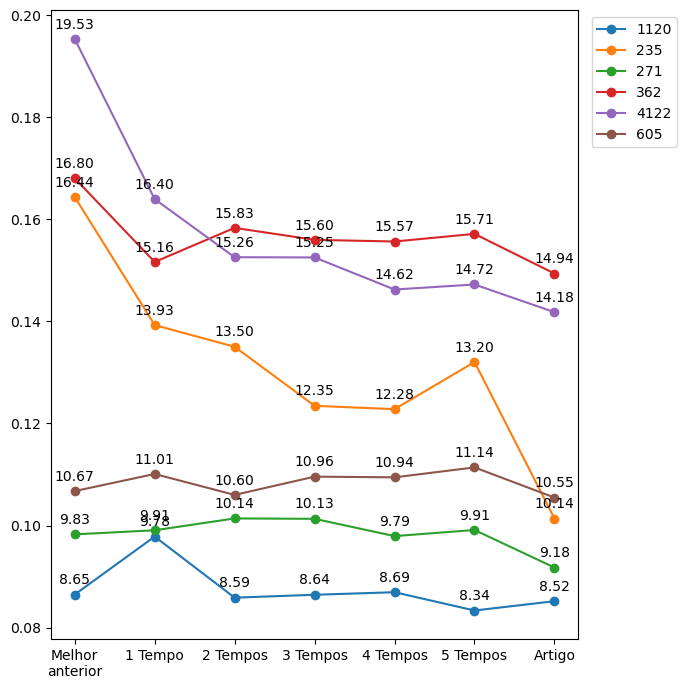

<Figure size 640x480 with 0 Axes>

In [80]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

plt.savefig("Results/resultados_tempos_anteriores_xgb.svg")

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3883985615.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]


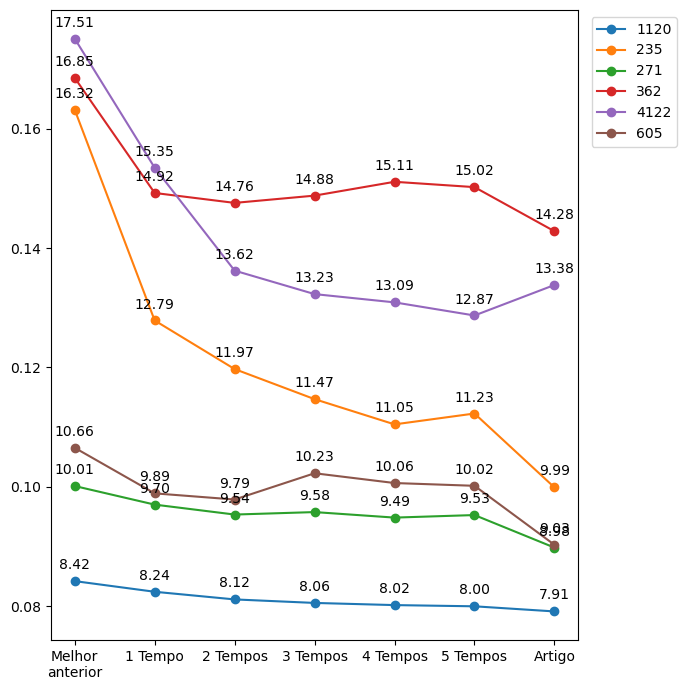

<Figure size 640x480 with 0 Axes>

In [81]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

plt.savefig("Results/resultados_tempos_anteriores_rf.svg")

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3733153103.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]


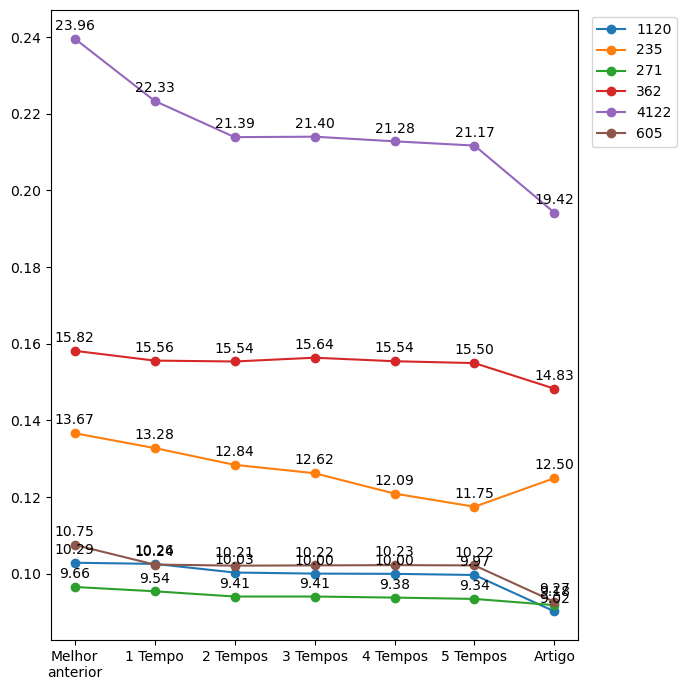

<Figure size 640x480 with 0 Axes>

In [82]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("3 Tempo"))].sort_values("Teste", ascending=False)
d = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"] == "1 Teste de Colunas - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano']")]

b = pd.concat([d, b], ignore_index=False)


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Melhor\nanterior", "1 Tempo", "2 Tempos", "3 Tempos", "4 Tempos", "5 Tempos", "Artigo"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

plt.savefig("Results/resultados_tempos_anteriores_lr.svg")

# Teste com clima

## Tratando dados de clima

In [54]:
# Lendo os csv do Inmet e juntando os dois anos
clima2019 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2019_A_31-12-2019.CSV', sep=';', header=8, encoding='utf-8')
clima2018 = pd.read_csv('INMET_S_SC_A806_FLORIANOPOLIS_01-01-2018_A_31-12-2018.CSV', sep=';', header=8, encoding='utf-8')
clima2018.rename(columns = {'DATA (YYYY-MM-DD)': 'Data', 'HORA (UTC)':'Hora UTC'} ,inplace=True)
clima = pd.concat([clima2018,clima2019])
clima

,Data,Hora UTC,"PRECIPITACAO TOTAL, HORARIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIRECAO HORARIA (gr) ((gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,2018-01-01,00:00,0,"1009,5","1009,5",1009,-9999,"24,7","19,9","24,9","24,7","20,1","19,6",75.0,73.0,75.0,111.0,3,"1,2",NaN
1,2018-01-01,01:00,0,"1010,2","1010,2","1009,5",-9999,"24,7","19,9","24,8","24,6",20,"19,8",75.0,74.0,75.0,93.0,"2,8",",9",NaN
2,2018-01-01,02:00,0,"1010,7","1010,7","1010,2",-9999,"24,4","20,1","24,7","24,2","20,2","19,8",78.0,74.0,77.0,347.0,"2,6",",5",NaN
3,2018-01-01,03:00,0,"1010,5","1010,7","1010,5",-9999,"23,9","20,5","24,5","23,8","20,5",20,81.0,77.0,81.0,298.0,"1,5",",2",NaN
4,2018-01-01,04:00,0,1010,"1010,5","1009,9",-9999,"23,8","20,3","24,3","23,8","20,6","20,3",82.0,79.0,81.0,278.0,"2,7",",7",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019/12/31,1900 UTC,0,"1005,8","1006,4","1005,8","2590,4","29,3","21,3","29,8",29,"21,6","20,7",63.0,59.0,62.0,31.0,"11,4",4,NaN
8756,2019/12/31,2000 UTC,0,"1005,7",1006,"1005,6","1864,7",28,"21,4","29,3","27,8","21,6",21,68.0,62.0,67.0,17.0,"11,4","3,8",NaN
8757,2019/12/31,2100 UTC,0,"1005,9","1005,9","1005,7","772,7","27,2","21,5","28,2","27,1","21,7",21,72.0,67.0,71.0,14.0,"9,5","2,9",NaN
8758,2019/12/31,2200 UTC,0,"1006,4","1006,4","1005,9","164,2","26,2","21,6","27,2","26,2","21,7","21,3",76.0,71.0,76.0,6.0,"10,3",3,NaN


In [55]:
#Convertendo a data e a hora em um datetime
clima['Datetime'] = pd.to_datetime(clima['Data']+' '+clima['Hora UTC'],utc=True)
clima['Datetime'] = clima['Datetime'].dt.tz_convert(pytz.timezone('America/Sao_Paulo'))
clima['Datetime'] = clima['Datetime'].dt.tz_localize(None)
clima

,Data,Hora UTC,"PRECIPITACAO TOTAL, HORARIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C),...,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIRECAO HORARIA (gr) ((gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,Datetime
0,2018-01-01,00:00,0,"1009,5","1009,5",1009,-9999,"24,7","19,9","24,9",...,"20,1","19,6",75.0,73.0,75.0,111.0,3,"1,2",NaN,2017-12-31 22:00:00
1,2018-01-01,01:00,0,"1010,2","1010,2","1009,5",-9999,"24,7","19,9","24,8",...,20,"19,8",75.0,74.0,75.0,93.0,"2,8",",9",NaN,2017-12-31 23:00:00
2,2018-01-01,02:00,0,"1010,7","1010,7","1010,2",-9999,"24,4","20,1","24,7",...,"20,2","19,8",78.0,74.0,77.0,347.0,"2,6",",5",NaN,2018-01-01 00:00:00
3,2018-01-01,03:00,0,"1010,5","1010,7","1010,5",-9999,"23,9","20,5","24,5",...,"20,5",20,81.0,77.0,81.0,298.0,"1,5",",2",NaN,2018-01-01 01:00:00
4,2018-01-01,04:00,0,1010,"1010,5","1009,9",-9999,"23,8","20,3","24,3",...,"20,6","20,3",82.0,79.0,81.0,278.0,"2,7",",7",NaN,2018-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019/12/31,1900 UTC,0,"1005,8","1006,4","1005,8","2590,4","29,3","21,3","29,8",...,"21,6","20,7",63.0,59.0,62.0,31.0,"11,4",4,NaN,2019-12-31 16:00:00
8756,2019/12/31,2000 UTC,0,"1005,7",1006,"1005,6","1864,7",28,"21,4","29,3",...,"21,6",21,68.0,62.0,67.0,17.0,"11,4","3,8",NaN,2019-12-31 17:00:00
8757,2019/12/31,2100 UTC,0,"1005,9","1005,9","1005,7","772,7","27,2","21,5","28,2",...,"21,7",21,72.0,67.0,71.0,14.0,"9,5","2,9",NaN,2019-12-31 18:00:00
8758,2019/12/31,2200 UTC,0,"1006,4","1006,4","1005,9","164,2","26,2","21,6","27,2",...,"21,7","21,3",76.0,71.0,76.0,6.0,"10,3",3,NaN,2019-12-31 19:00:00


In [56]:
#Pegando apenas colunas com informações de data, precipitação e temperatudo. E o intervalo de tempo apenas dos nossos dados
clima = clima[['Datetime','PRECIPITACAO TOTAL, HORARIO (mm)','TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)','TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)']]
clima = clima.loc[(clima['Datetime'] >= '2018-10-01') & (clima['Datetime'] <= '2019-11-30')].sort_values(by='Datetime')
clima

,Datetime,"PRECIPITACAO TOTAL, HORARIO (mm)",TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)
6555,2018-10-01 00:00:00,0,"23,3","23,2"
6556,2018-10-01 01:00:00,0,"23,3","22,6"
6557,2018-10-01 02:00:00,0,"22,9","22,5"
6558,2018-10-01 03:00:00,0,"22,9","22,7"
6559,2018-10-01 04:00:00,0,"22,7","22,4"
...,...,...,...,...
7991,2019-11-29 20:00:00,NaN,"22,8","22,4"
7992,2019-11-29 21:00:00,NaN,"22,5","21,9"
7993,2019-11-29 22:00:00,NaN,"21,9","20,6"
7994,2019-11-29 23:00:00,NaN,"20,8","20,6"


In [57]:
# Tirando a média das temperaturas mínima e máxima
clima["Temperatura Media"] = (clima["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float) + clima["TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(float))/2

In [58]:
#Transformando a precipitação em um valor categorico - Usamos apenas 3 Sem, Fraco e Forte pois com mais categorias algumas ficavam pouco representativas
clima["PRECIPITACAO TOTAL, HORARIO (mm)"] = clima["PRECIPITACAO TOTAL, HORARIO (mm)"].str.replace(",", ".").astype(float)
clima['Chuva'] = clima['PRECIPITACAO TOTAL, HORARIO (mm)'].apply(lambda x: 1 if (x > 0) & (x <= 2.5) else \
2 if (x > 2.5) & (x <= 10) else \
3 if (x > 10) else 0)

In [59]:
#Transformando a Temperatura em um valor categorico - Usamos apenas 2 Frio ou Quente pois com mais categorias algumas ficavam pouco representativas
clima['Calor'] = clima['Temperatura Media'].apply(lambda x: 1 if (x > 16) & (x <= 25) else \
2 if (x > 25) else 0)

In [60]:
#Dropando as colunas desnecessárias
clima.drop(["TEMPERATURA MAXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MINIMA NA HORA ANT. (AUT) (°C)", "PRECIPITACAO TOTAL, HORARIO (mm)", "Temperatura Media"], axis=1, inplace=True)

In [61]:
clima

,Datetime,Chuva,Calor
6555,2018-10-01 00:00:00,0,1
6556,2018-10-01 01:00:00,0,1
6557,2018-10-01 02:00:00,0,1
6558,2018-10-01 03:00:00,0,1
6559,2018-10-01 04:00:00,0,1
...,...,...,...
7991,2019-11-29 20:00:00,0,1
7992,2019-11-29 21:00:00,0,1
7993,2019-11-29 22:00:00,0,1
7994,2019-11-29 23:00:00,0,1


In [62]:
#Mudanças na data_partida para conseguir fazer o merge
df["Ini2"] = df["Ini"]
df["Ini2"] = df["Ini2"].dt.round("H")
#Merge dos dados e exclusão da coluna auxiliar
df = df.merge(clima, left_on="Ini2", right_on="Datetime", how="left")
df.drop(['Ini2','Datetime'],axis=1,inplace=True)
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,...,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7,Chuva,Calor
0,0,1120,3840,19,31.218,2018-11-14 06:11:00,2018-11-14 07:15:00,3,6,318,...,26.0,4260.0,4140.0,4740.0,5040.0,4380.0,4290.0,4050.0,0,1
1,0,1120,4560,33,31.218,2018-11-14 06:44:00,2018-11-14 08:00:00,3,6,318,...,26.0,3840.0,4260.0,4140.0,4740.0,5040.0,4290.0,4050.0,0,1
2,1,1120,3240,1,30.640,2018-11-14 07:18:00,2018-11-14 08:12:00,3,7,318,...,4.0,4560.0,3840.0,4260.0,4140.0,4740.0,3480.0,3720.0,0,1
3,0,1120,4200,17,31.218,2018-11-14 08:12:00,2018-11-14 09:22:00,3,8,318,...,8.5,3240.0,4560.0,3840.0,4260.0,4140.0,3930.0,4170.0,0,1
4,1,1120,3300,7,30.640,2018-11-14 08:13:00,2018-11-14 09:08:00,3,8,318,...,8.5,4200.0,3240.0,4560.0,3840.0,4260.0,3930.0,4170.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30463,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,...,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0,3780.0,0,2
30464,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,...,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0,3840.0,0,2
30465,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,...,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0,3720.0,0,2
30466,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,...,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0,3960.0,0,2


## Executando Testes

In [63]:
df

,Sentido,Linha,DuraçãoViagem,TotalGiros,KmPerc,Ini,Fim,dia_semana,hora_dia,dia_ano,...,TotalGirosMean,DuraçãoViagem_1,DuraçãoViagem_2,DuraçãoViagem_3,DuraçãoViagem_4,DuraçãoViagem_5,DuraçãoViagemMean_d-1,DuraçãoViagemMean_d-7,Chuva,Calor
0,0,1120,3840,19,31.218,2018-11-14 06:11:00,2018-11-14 07:15:00,3,6,318,...,26.0,4260.0,4140.0,4740.0,5040.0,4380.0,4290.0,4050.0,0,1
1,0,1120,4560,33,31.218,2018-11-14 06:44:00,2018-11-14 08:00:00,3,6,318,...,26.0,3840.0,4260.0,4140.0,4740.0,5040.0,4290.0,4050.0,0,1
2,1,1120,3240,1,30.640,2018-11-14 07:18:00,2018-11-14 08:12:00,3,7,318,...,4.0,4560.0,3840.0,4260.0,4140.0,4740.0,3480.0,3720.0,0,1
3,0,1120,4200,17,31.218,2018-11-14 08:12:00,2018-11-14 09:22:00,3,8,318,...,8.5,3240.0,4560.0,3840.0,4260.0,4140.0,3930.0,4170.0,0,1
4,1,1120,3300,7,30.640,2018-11-14 08:13:00,2018-11-14 09:08:00,3,8,318,...,8.5,4200.0,3240.0,4560.0,3840.0,4260.0,3930.0,4170.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30463,0,605,3900,16,19.437,2019-10-31 12:51:00,2019-10-31 13:56:00,4,12,304,...,17.0,3420.0,3360.0,3180.0,3300.0,4620.0,3780.0,3780.0,0,2
30464,0,605,3780,10,19.437,2019-10-31 13:39:00,2019-10-31 14:42:00,4,13,304,...,5.0,3900.0,3420.0,3360.0,3180.0,3300.0,3000.0,3840.0,0,2
30465,0,605,3780,18,19.437,2019-10-31 15:57:00,2019-10-31 17:00:00,4,15,304,...,10.5,3780.0,3900.0,3420.0,3360.0,3180.0,3330.0,3720.0,0,2
30466,0,605,4440,26,19.437,2019-10-31 16:58:00,2019-10-31 18:12:00,4,16,304,...,27.0,3780.0,3780.0,3900.0,3420.0,3360.0,3660.0,3960.0,0,2


In [64]:
Colunas = [
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva'],
    ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Calor'],
]
TestesNome = [
    "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']",
    "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva']",
    "2 - Teste clima - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Calor']",
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    shape = int(df_modelo.shape[0] * 0.3)
    df_teste = df_modelo[:shape]
    df_treino = df_modelo[shape:]
    for i in range(len(TestesNome)):
        teste_nome = TestesNome[i]
        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[Colunas[i]]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[Colunas[i]]
        y_treino = df_treino["DuraçãoViagem"]

        fi_xgb, fi_rf = cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)
        fi_xgb["rota"], fi_rf["rota"] = rota, rota
        fi_xgb["modelo"], fi_rf["modelo"] = "XGB", "RF"

        importance = pd.concat([importance, fi_xgb, fi_rf])


[0]	validation_0-rmse:2755.42712
[1]	validation_0-rmse:1954.17543
[2]	validation_0-rmse:1400.49984
[3]	validation_0-rmse:1022.62366
[4]	validation_0-rmse:768.37481
[5]	validation_0-rmse:597.79547
[6]	validation_0-rmse:488.10691
[7]	validation_0-rmse:421.65610
[8]	validation_0-rmse:376.86901
[9]	validation_0-rmse:354.32379
[10]	validation_0-rmse:332.88496
[11]	validation_0-rmse:322.91067
[12]	validation_0-rmse:316.58155
[13]	validation_0-rmse:313.81900
[14]	validation_0-rmse:307.00834
[15]	validation_0-rmse:299.98304
[16]	validation_0-rmse:295.02714
[17]	validation_0-rmse:285.84539
[18]	validation_0-rmse:283.26555
[19]	validation_0-rmse:278.56230
[20]	validation_0-rmse:277.03124
[21]	validation_0-rmse:268.76867
[22]	validation_0-rmse:264.37966
[23]	validation_0-rmse:258.70959
[24]	validation_0-rmse:254.76664
[25]	validation_0-rmse:251.12479
[26]	validation_0-rmse:246.36065
[27]	validation_0-rmse:245.22090
[28]	validation_0-rmse:240.69650
[29]	validation_0-rmse:237.82641
[30]	validation_

[92]	validation_0-rmse:114.23166
[93]	validation_0-rmse:112.42836
[94]	validation_0-rmse:111.83725
[95]	validation_0-rmse:110.36536
[96]	validation_0-rmse:110.07161
[97]	validation_0-rmse:108.32479
[98]	validation_0-rmse:107.05049
[99]	validation_0-rmse:106.53992
[0]	validation_0-rmse:2755.42712
[1]	validation_0-rmse:1954.17543
[2]	validation_0-rmse:1400.49984
[3]	validation_0-rmse:1022.69496
[4]	validation_0-rmse:768.54564
[5]	validation_0-rmse:599.67898
[6]	validation_0-rmse:491.51607
[7]	validation_0-rmse:421.76851
[8]	validation_0-rmse:378.10703
[9]	validation_0-rmse:354.80790
[10]	validation_0-rmse:339.18734
[11]	validation_0-rmse:328.49837
[12]	validation_0-rmse:318.46490
[13]	validation_0-rmse:315.01275
[14]	validation_0-rmse:312.57780
[15]	validation_0-rmse:308.46835
[16]	validation_0-rmse:307.21404


C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[17]	validation_0-rmse:299.92921
[18]	validation_0-rmse:297.42143
[19]	validation_0-rmse:289.53573
[20]	validation_0-rmse:286.91295
[21]	validation_0-rmse:281.64783
[22]	validation_0-rmse:278.43752
[23]	validation_0-rmse:274.01662
[24]	validation_0-rmse:273.02973
[25]	validation_0-rmse:269.82217
[26]	validation_0-rmse:266.39608
[27]	validation_0-rmse:262.06457
[28]	validation_0-rmse:257.56037
[29]	validation_0-rmse:253.77265
[30]	validation_0-rmse:251.65383
[31]	validation_0-rmse:250.04687
[32]	validation_0-rmse:249.12377
[33]	validation_0-rmse:244.74553
[34]	validation_0-rmse:240.80951
[35]	validation_0-rmse:236.59276
[36]	validation_0-rmse:231.91186
[37]	validation_0-rmse:228.85146
[38]	validation_0-rmse:225.37159
[39]	validation_0-rmse:221.41453
[40]	validation_0-rmse:219.48917
[41]	validation_0-rmse:215.42117
[42]	validation_0-rmse:213.26770
[43]	validation_0-rmse:211.50629
[44]	validation_0-rmse:208.46017
[45]	validation_0-rmse:206.40338
[46]	validation_0-rmse:204.62924
[47]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[14]	validation_0-rmse:302.27492
[15]	validation_0-rmse:300.01607
[16]	validation_0-rmse:297.02685
[17]	validation_0-rmse:296.09199
[18]	validation_0-rmse:292.45400
[19]	validation_0-rmse:287.79917
[20]	validation_0-rmse:287.16153
[21]	validation_0-rmse:279.34601
[22]	validation_0-rmse:274.46204
[23]	validation_0-rmse:267.14849
[24]	validation_0-rmse:264.21555
[25]	validation_0-rmse:258.66479
[26]	validation_0-rmse:256.75792
[27]	validation_0-rmse:254.38890
[28]	validation_0-rmse:253.54073
[29]	validation_0-rmse:252.52137
[30]	validation_0-rmse:249.15111
[31]	validation_0-rmse:241.47570
[32]	validation_0-rmse:239.81866
[33]	validation_0-rmse:236.49824
[34]	validation_0-rmse:230.02777
[35]	validation_0-rmse:226.87869
[36]	validation_0-rmse:224.81855
[37]	validation_0-rmse:221.42418
[38]	validation_0-rmse:220.14830
[39]	validation_0-rmse:216.58334
[40]	validation_0-rmse:212.96818
[41]	validation_0-rmse:210.76082
[42]	validation_0-rmse:208.70502
[43]	validation_0-rmse:205.32926
[44]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[11]	validation_0-rmse:253.69684
[12]	validation_0-rmse:244.53313
[13]	validation_0-rmse:240.57323
[14]	validation_0-rmse:238.27432
[15]	validation_0-rmse:232.39421
[16]	validation_0-rmse:230.62388
[17]	validation_0-rmse:227.79329
[18]	validation_0-rmse:222.17674
[19]	validation_0-rmse:218.03737
[20]	validation_0-rmse:215.58966
[21]	validation_0-rmse:212.90253
[22]	validation_0-rmse:211.36604
[23]	validation_0-rmse:209.97059
[24]	validation_0-rmse:207.74371
[25]	validation_0-rmse:204.08485
[26]	validation_0-rmse:203.52415
[27]	validation_0-rmse:202.39121
[28]	validation_0-rmse:201.55056
[29]	validation_0-rmse:200.83671
[30]	validation_0-rmse:200.27477
[31]	validation_0-rmse:199.40659
[32]	validation_0-rmse:196.85653
[33]	validation_0-rmse:194.14672
[34]	validation_0-rmse:191.29018
[35]	validation_0-rmse:189.53642
[36]	validation_0-rmse:185.45846
[37]	validation_0-rmse:184.70530
[38]	validation_0-rmse:182.71133
[39]	validation_0-rmse:180.20563
[40]	validation_0-rmse:178.66736
[41]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[16]	validation_0-rmse:233.47726
[17]	validation_0-rmse:229.33605
[18]	validation_0-rmse:226.69232
[19]	validation_0-rmse:223.31966
[20]	validation_0-rmse:219.77320
[21]	validation_0-rmse:215.74767
[22]	validation_0-rmse:214.40510
[23]	validation_0-rmse:213.72494
[24]	validation_0-rmse:212.06691
[25]	validation_0-rmse:207.78572
[26]	validation_0-rmse:206.44377
[27]	validation_0-rmse:205.73791
[28]	validation_0-rmse:202.75001
[29]	validation_0-rmse:201.03802
[30]	validation_0-rmse:200.20728
[31]	validation_0-rmse:198.35853
[32]	validation_0-rmse:195.14801
[33]	validation_0-rmse:193.42240
[34]	validation_0-rmse:191.58665
[35]	validation_0-rmse:191.22137
[36]	validation_0-rmse:189.92272
[37]	validation_0-rmse:188.32810
[38]	validation_0-rmse:185.98609
[39]	validation_0-rmse:184.28383
[40]	validation_0-rmse:182.34422
[41]	validation_0-rmse:182.16777
[42]	validation_0-rmse:181.33255
[43]	validation_0-rmse:179.64950
[44]	validation_0-rmse:177.26135
[45]	validation_0-rmse:174.95777
[46]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[17]	validation_0-rmse:228.22184
[18]	validation_0-rmse:227.05395
[19]	validation_0-rmse:222.07417
[20]	validation_0-rmse:220.38466
[21]	validation_0-rmse:217.03964
[22]	validation_0-rmse:215.77002
[23]	validation_0-rmse:213.46497
[24]	validation_0-rmse:210.88993
[25]	validation_0-rmse:209.40216
[26]	validation_0-rmse:208.30718
[27]	validation_0-rmse:207.35224
[28]	validation_0-rmse:205.08383
[29]	validation_0-rmse:203.88370
[30]	validation_0-rmse:202.31620
[31]	validation_0-rmse:199.43659
[32]	validation_0-rmse:196.06534
[33]	validation_0-rmse:195.03739
[34]	validation_0-rmse:192.00173
[35]	validation_0-rmse:190.75728
[36]	validation_0-rmse:189.08069
[37]	validation_0-rmse:187.35438
[38]	validation_0-rmse:186.84830
[39]	validation_0-rmse:185.72056
[40]	validation_0-rmse:185.11651
[41]	validation_0-rmse:184.34160
[42]	validation_0-rmse:181.69878
[43]	validation_0-rmse:179.20123
[44]	validation_0-rmse:176.12462
[45]	validation_0-rmse:175.64762
[46]	validation_0-rmse:173.66968
[47]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[11]	validation_0-rmse:152.50815
[12]	validation_0-rmse:151.19366
[13]	validation_0-rmse:149.54490
[14]	validation_0-rmse:148.80075
[15]	validation_0-rmse:147.87686
[16]	validation_0-rmse:147.21804
[17]	validation_0-rmse:146.74134
[18]	validation_0-rmse:145.99620
[19]	validation_0-rmse:144.72992
[20]	validation_0-rmse:144.26309
[21]	validation_0-rmse:143.96383
[22]	validation_0-rmse:142.07030
[23]	validation_0-rmse:141.38833
[24]	validation_0-rmse:140.27783
[25]	validation_0-rmse:139.25037
[26]	validation_0-rmse:138.59159
[27]	validation_0-rmse:138.05890
[28]	validation_0-rmse:137.20659
[29]	validation_0-rmse:136.54648
[30]	validation_0-rmse:135.93528
[31]	validation_0-rmse:135.25788
[32]	validation_0-rmse:135.01303
[33]	validation_0-rmse:134.80640
[34]	validation_0-rmse:134.34836
[35]	validation_0-rmse:133.82452
[36]	validation_0-rmse:133.40433
[37]	validation_0-rmse:132.81044
[38]	validation_0-rmse:131.97293
[39]	validation_0-rmse:131.66961
[40]	validation_0-rmse:131.09097
[41]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1014.01557
[1]	validation_0-rmse:720.81665
[2]	validation_0-rmse:519.04733
[3]	validation_0-rmse:382.07381
[4]	validation_0-rmse:291.41146
[5]	validation_0-rmse:234.12892
[6]	validation_0-rmse:199.20813
[7]	validation_0-rmse:178.84192
[8]	validation_0-rmse:167.60242
[9]	validation_0-rmse:161.54436
[10]	validation_0-rmse:157.97473
[11]	validation_0-rmse:154.40184
[12]	validation_0-rmse:153.22922
[13]	validation_0-rmse:150.97306
[14]	validation_0-rmse:150.01135
[15]	validation_0-rmse:149.21181
[16]	validation_0-rmse:148.18557
[17]	validation_0-rmse:147.72617
[18]	validation_0-rmse:146.56054
[19]	validation_0-rmse:145.82389
[20]	validation_0-rmse:144.36408
[21]	validation_0-rmse:143.16366
[22]	validation_0-rmse:142.57409
[23]	validation_0-rmse:141.64789
[24]	validation_0-rmse:141.26856
[25]	validation_0-rmse:140.84828
[26]	validation_0-rmse:139.70023
[27]	validation_0-rmse:139.51114
[28]	validation_0-rmse:138.73759
[29]	validation_0-rmse:138.19222
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1014.01557
[1]	validation_0-rmse:720.80701
[2]	validation_0-rmse:518.94292
[3]	validation_0-rmse:382.08107
[4]	validation_0-rmse:291.79593
[5]	validation_0-rmse:234.25300
[6]	validation_0-rmse:198.89334
[7]	validation_0-rmse:178.74172
[8]	validation_0-rmse:165.93235
[9]	validation_0-rmse:157.93669
[10]	validation_0-rmse:154.42325
[11]	validation_0-rmse:152.25360
[12]	validation_0-rmse:150.74514
[13]	validation_0-rmse:148.64997
[14]	validation_0-rmse:147.45291
[15]	validation_0-rmse:146.30091
[16]	validation_0-rmse:145.00334
[17]	validation_0-rmse:144.59344
[18]	validation_0-rmse:143.82688
[19]	validation_0-rmse:142.74945
[20]	validation_0-rmse:142.17433
[21]	validation_0-rmse:141.80907
[22]	validation_0-rmse:140.52725
[23]	validation_0-rmse:139.47086
[24]	validation_0-rmse:138.81896
[25]	validation_0-rmse:138.56594
[26]	validation_0-rmse:137.71862
[27]	validation_0-rmse:137.02967
[28]	validation_0-rmse:135.89348
[29]	validation_0-rmse:135.16733
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.08775
[2]	validation_0-rmse:322.81133
[3]	validation_0-rmse:247.97557
[4]	validation_0-rmse:200.25298
[5]	validation_0-rmse:170.84770
[6]	validation_0-rmse:153.31310
[7]	validation_0-rmse:143.22670
[8]	validation_0-rmse:136.97148
[9]	validation_0-rmse:132.66324
[10]	validation_0-rmse:130.92365
[11]	validation_0-rmse:129.00332
[12]	validation_0-rmse:127.05205
[13]	validation_0-rmse:125.28595
[14]	validation_0-rmse:124.03389
[15]	validation_0-rmse:123.56304
[16]	validation_0-rmse:122.35251
[17]	validation_0-rmse:121.04388
[18]	validation_0-rmse:120.03553
[19]	validation_0-rmse:119.55992
[20]	validation_0-rmse:118.43172
[21]	validation_0-rmse:117.54089
[22]	validation_0-rmse:116.68294
[23]	validation_0-rmse:115.59801
[24]	validation_0-rmse:114.47684
[25]	validation_0-rmse:113.66913
[26]	validation_0-rmse:113.35512
[27]	validation_0-rmse:112.55792
[28]	validation_0-rmse:112.17924
[29]	validation_0-rmse:110.60647
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.09922
[2]	validation_0-rmse:322.81927
[3]	validation_0-rmse:248.01562
[4]	validation_0-rmse:200.43832
[5]	validation_0-rmse:171.25622
[6]	validation_0-rmse:153.93371
[7]	validation_0-rmse:143.48931
[8]	validation_0-rmse:136.95873
[9]	validation_0-rmse:133.33795
[10]	validation_0-rmse:130.87683
[11]	validation_0-rmse:129.22608
[12]	validation_0-rmse:128.28940
[13]	validation_0-rmse:127.69526
[14]	validation_0-rmse:125.85029
[15]	validation_0-rmse:123.64210
[16]	validation_0-rmse:123.13636
[17]	validation_0-rmse:122.02349
[18]	validation_0-rmse:120.84220
[19]	validation_0-rmse:119.62112
[20]	validation_0-rmse:118.57658
[21]	validation_0-rmse:118.11065
[22]	validation_0-rmse:116.86566
[23]	validation_0-rmse:116.05312
[24]	validation_0-rmse:114.61577
[25]	validation_0-rmse:113.59805
[26]	validation_0-rmse:113.28203
[27]	validation_0-rmse:112.96293
[28]	validation_0-rmse:111.60506
[29]	validation_0-rmse:110.74311
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:603.66274
[1]	validation_0-rmse:436.08775
[2]	validation_0-rmse:322.82874
[3]	validation_0-rmse:248.18136
[4]	validation_0-rmse:200.48621
[5]	validation_0-rmse:171.27285
[6]	validation_0-rmse:153.29180
[7]	validation_0-rmse:142.04172
[8]	validation_0-rmse:135.72747
[9]	validation_0-rmse:131.89782
[10]	validation_0-rmse:129.25712
[11]	validation_0-rmse:127.64817
[12]	validation_0-rmse:126.25959
[13]	validation_0-rmse:125.38299
[14]	validation_0-rmse:124.04959
[15]	validation_0-rmse:122.63504
[16]	validation_0-rmse:121.47786
[17]	validation_0-rmse:120.96263
[18]	validation_0-rmse:118.73270
[19]	validation_0-rmse:117.82548
[20]	validation_0-rmse:116.38478
[21]	validation_0-rmse:115.36651
[22]	validation_0-rmse:114.51719
[23]	validation_0-rmse:113.74439
[24]	validation_0-rmse:112.73321
[25]	validation_0-rmse:112.26633
[26]	validation_0-rmse:111.01464
[27]	validation_0-rmse:110.21884
[28]	validation_0-rmse:109.41344
[29]	validation_0-rmse:108.45914
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2253.80274
[1]	validation_0-rmse:1620.04456
[2]	validation_0-rmse:1183.81105
[3]	validation_0-rmse:887.33645
[4]	validation_0-rmse:689.72147
[5]	validation_0-rmse:559.79991
[6]	validation_0-rmse:481.97355
[7]	validation_0-rmse:429.09351
[8]	validation_0-rmse:400.31803
[9]	validation_0-rmse:374.45600
[10]	validation_0-rmse:360.42438
[11]	validation_0-rmse:349.53121
[12]	validation_0-rmse:336.84564
[13]	validation_0-rmse:325.69972
[14]	validation_0-rmse:322.32593
[15]	validation_0-rmse:313.25477
[16]	validation_0-rmse:307.05381
[17]	validation_0-rmse:302.35954
[18]	validation_0-rmse:299.65659
[19]	validation_0-rmse:295.34096
[20]	validation_0-rmse:289.96442
[21]	validation_0-rmse:284.72490
[22]	validation_0-rmse:277.23978
[23]	validation_0-rmse:271.67371
[24]	validation_0-rmse:269.67334
[25]	validation_0-rmse:264.91631
[26]	validation_0-rmse:259.17357
[27]	validation_0-rmse:257.28044
[28]	validation_0-rmse:253.47072
[29]	validation_0-rmse:248.85384
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[22]	validation_0-rmse:278.06841
[23]	validation_0-rmse:273.57904
[24]	validation_0-rmse:271.14776
[25]	validation_0-rmse:269.31863
[26]	validation_0-rmse:263.58124
[27]	validation_0-rmse:259.85889
[28]	validation_0-rmse:256.76532
[29]	validation_0-rmse:253.75596
[30]	validation_0-rmse:251.74837
[31]	validation_0-rmse:245.40791
[32]	validation_0-rmse:242.50499
[33]	validation_0-rmse:238.55014
[34]	validation_0-rmse:232.10787
[35]	validation_0-rmse:228.49441
[36]	validation_0-rmse:227.08876
[37]	validation_0-rmse:222.51258
[38]	validation_0-rmse:218.41669
[39]	validation_0-rmse:215.69592
[40]	validation_0-rmse:214.50103
[41]	validation_0-rmse:211.25646
[42]	validation_0-rmse:207.30356
[43]	validation_0-rmse:202.57444
[44]	validation_0-rmse:198.07364
[45]	validation_0-rmse:196.48528
[46]	validation_0-rmse:191.20197
[47]	validation_0-rmse:189.21789
[48]	validation_0-rmse:186.15399
[49]	validation_0-rmse:185.06842
[50]	validation_0-rmse:184.75071
[51]	validation_0-rmse:182.49627
[52]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[21]	validation_0-rmse:293.69409
[22]	validation_0-rmse:289.67321
[23]	validation_0-rmse:285.74475
[24]	validation_0-rmse:278.88233
[25]	validation_0-rmse:277.30422
[26]	validation_0-rmse:273.78009
[27]	validation_0-rmse:267.23703
[28]	validation_0-rmse:260.65192
[29]	validation_0-rmse:255.15640
[30]	validation_0-rmse:250.89780
[31]	validation_0-rmse:247.93199
[32]	validation_0-rmse:243.10295
[33]	validation_0-rmse:240.48989
[34]	validation_0-rmse:238.53516
[35]	validation_0-rmse:234.13361
[36]	validation_0-rmse:230.26320
[37]	validation_0-rmse:226.93598
[38]	validation_0-rmse:224.66784
[39]	validation_0-rmse:221.05507
[40]	validation_0-rmse:216.96452
[41]	validation_0-rmse:215.59999
[42]	validation_0-rmse:213.60314
[43]	validation_0-rmse:209.68920
[44]	validation_0-rmse:207.17395
[45]	validation_0-rmse:202.64530
[46]	validation_0-rmse:200.96155
[47]	validation_0-rmse:199.34797
[48]	validation_0-rmse:194.82663
[49]	validation_0-rmse:192.53672
[50]	validation_0-rmse:188.27371
[51]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[33]	validation_0-rmse:161.62143
[34]	validation_0-rmse:157.16522
[35]	validation_0-rmse:155.51859
[36]	validation_0-rmse:152.66538
[37]	validation_0-rmse:152.03828
[38]	validation_0-rmse:150.33422
[39]	validation_0-rmse:146.78271
[40]	validation_0-rmse:142.40633
[41]	validation_0-rmse:139.28009
[42]	validation_0-rmse:138.17805
[43]	validation_0-rmse:135.70448
[44]	validation_0-rmse:134.62907
[45]	validation_0-rmse:134.32164
[46]	validation_0-rmse:131.55674
[47]	validation_0-rmse:128.54748
[48]	validation_0-rmse:125.93833
[49]	validation_0-rmse:124.89331
[50]	validation_0-rmse:121.81758
[51]	validation_0-rmse:121.27830
[52]	validation_0-rmse:118.52165
[53]	validation_0-rmse:117.62173
[54]	validation_0-rmse:116.95942
[55]	validation_0-rmse:115.61053
[56]	validation_0-rmse:114.30345
[57]	validation_0-rmse:114.02755
[58]	validation_0-rmse:113.12494
[59]	validation_0-rmse:112.17384
[60]	validation_0-rmse:110.66025
[61]	validation_0-rmse:108.37348
[62]	validation_0-rmse:107.74136
[63]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[50]	validation_0-rmse:126.88595
[51]	validation_0-rmse:124.43704
[52]	validation_0-rmse:121.50547
[53]	validation_0-rmse:120.99189
[54]	validation_0-rmse:119.44984
[55]	validation_0-rmse:116.75573
[56]	validation_0-rmse:114.29780
[57]	validation_0-rmse:112.15058
[58]	validation_0-rmse:111.15116
[59]	validation_0-rmse:109.58494
[60]	validation_0-rmse:109.09594
[61]	validation_0-rmse:106.72955
[62]	validation_0-rmse:105.67438
[63]	validation_0-rmse:105.43341
[64]	validation_0-rmse:102.98631
[65]	validation_0-rmse:99.68817
[66]	validation_0-rmse:97.58486
[67]	validation_0-rmse:95.22841
[68]	validation_0-rmse:94.84111
[69]	validation_0-rmse:93.71971
[70]	validation_0-rmse:92.85789
[71]	validation_0-rmse:90.96036
[72]	validation_0-rmse:90.55949
[73]	validation_0-rmse:89.57701
[74]	validation_0-rmse:87.44453
[75]	validation_0-rmse:86.66579
[76]	validation_0-rmse:83.96931
[77]	validation_0-rmse:83.01490
[78]	validation_0-rmse:82.38578
[79]	validation_0-rmse:81.82580
[80]	validation_0-rmse:80

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[57]	validation_0-rmse:114.41900
[58]	validation_0-rmse:113.23242
[59]	validation_0-rmse:112.85548
[60]	validation_0-rmse:111.24027
[61]	validation_0-rmse:109.27775
[62]	validation_0-rmse:107.97265
[63]	validation_0-rmse:105.43169
[64]	validation_0-rmse:104.09942
[65]	validation_0-rmse:103.48108
[66]	validation_0-rmse:102.55376
[67]	validation_0-rmse:100.77416
[68]	validation_0-rmse:99.59125
[69]	validation_0-rmse:99.37136
[70]	validation_0-rmse:96.05968
[71]	validation_0-rmse:94.11024
[72]	validation_0-rmse:92.35684
[73]	validation_0-rmse:91.37770
[74]	validation_0-rmse:89.31069
[75]	validation_0-rmse:87.84723
[76]	validation_0-rmse:85.33948
[77]	validation_0-rmse:84.92356
[78]	validation_0-rmse:84.15001
[79]	validation_0-rmse:82.95024
[80]	validation_0-rmse:80.62362
[81]	validation_0-rmse:80.38606
[82]	validation_0-rmse:79.96961
[83]	validation_0-rmse:79.64765
[84]	validation_0-rmse:79.10338
[85]	validation_0-rmse:78.68201
[86]	validation_0-rmse:76.36691
[87]	validation_0-rmse:75.077

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [65]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
476,"2 - Teste clima - ['Sentido','TotalGirosMean',...",362,Random Forest,RMSE,153.683982,1.512799,0.31545
482,"2 - Teste clima - ['Sentido','TotalGirosMean',...",362,Random Forest,RMSE,154.437525,1.464594,0.31555
314,"3 Tempos Anterios - ['Sentido','TotalGirosMean...",362,Random Forest,RMSE,154.577030,1.443805,0.31579
488,"2 - Teste clima - ['Sentido','TotalGirosMean',...",362,Random Forest,RMSE,154.995952,1.500565,0.31961
484,"2 - Teste clima - ['Sentido','TotalGirosMean',...",362,Linear Regression,RMSE,157.322328,0.200600,0.19960
...,...,...,...,...,...,...,...
82,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Linear Regression,RMSE,861.481548,0.203600,0.20210
78,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,XGBoost,RMSE,866.977726,0.195787,0.17460
80,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Random Forest,RMSE,889.844841,0.374796,0.11485
74,"1 Teste de Colunas - ['TotalGirosMean','dia_se...",235,Random Forest,RMSE,895.468309,0.468638,0.14549


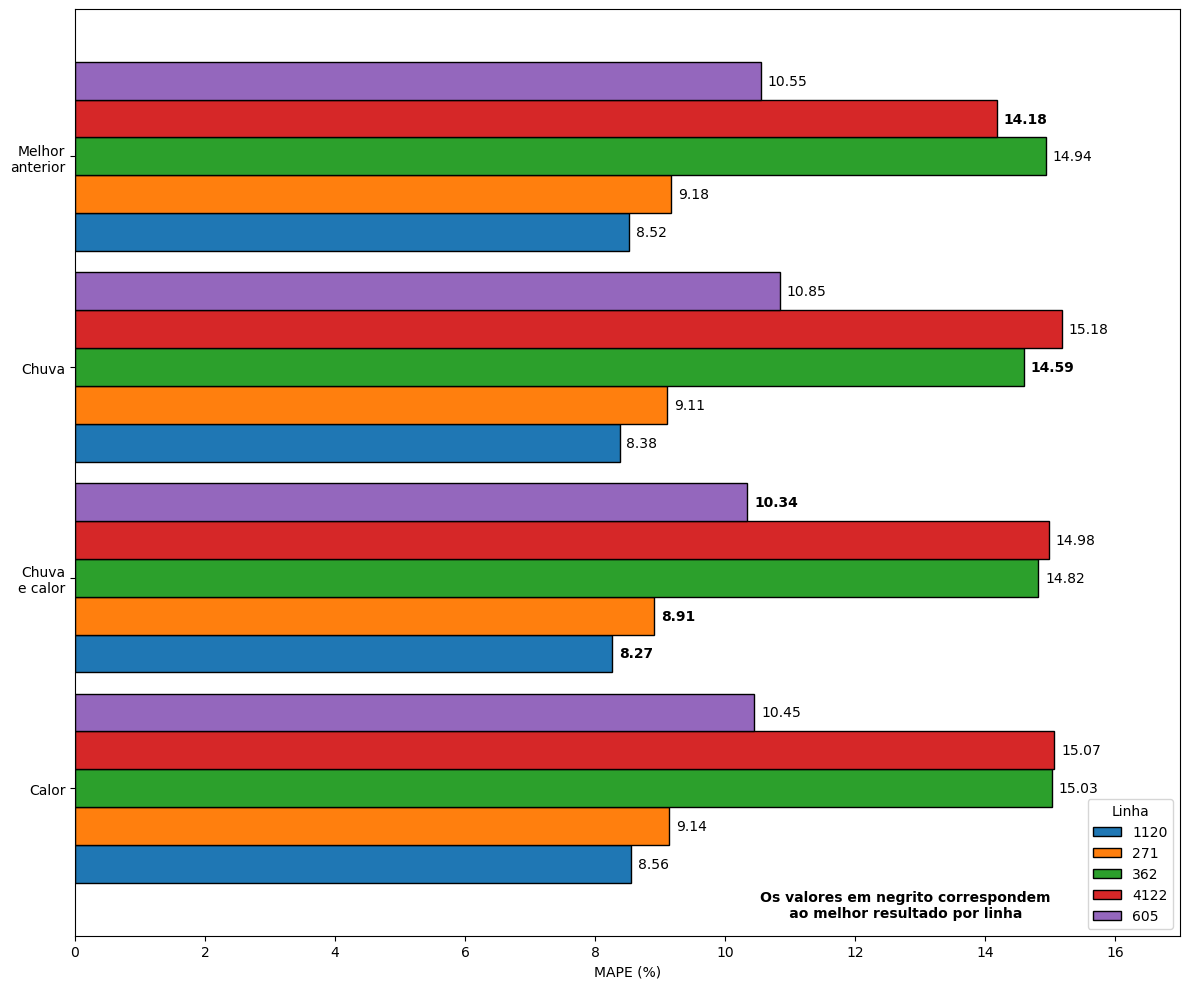

In [66]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost") & (a["Rota"] != "235") & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "XGBoost") & (a["Rota"] != "235") & (a["Teste"] == "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["Calor", "Chuva\ne calor", "Chuva", "Melhor\nanterior"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 17)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_xgb.svg")


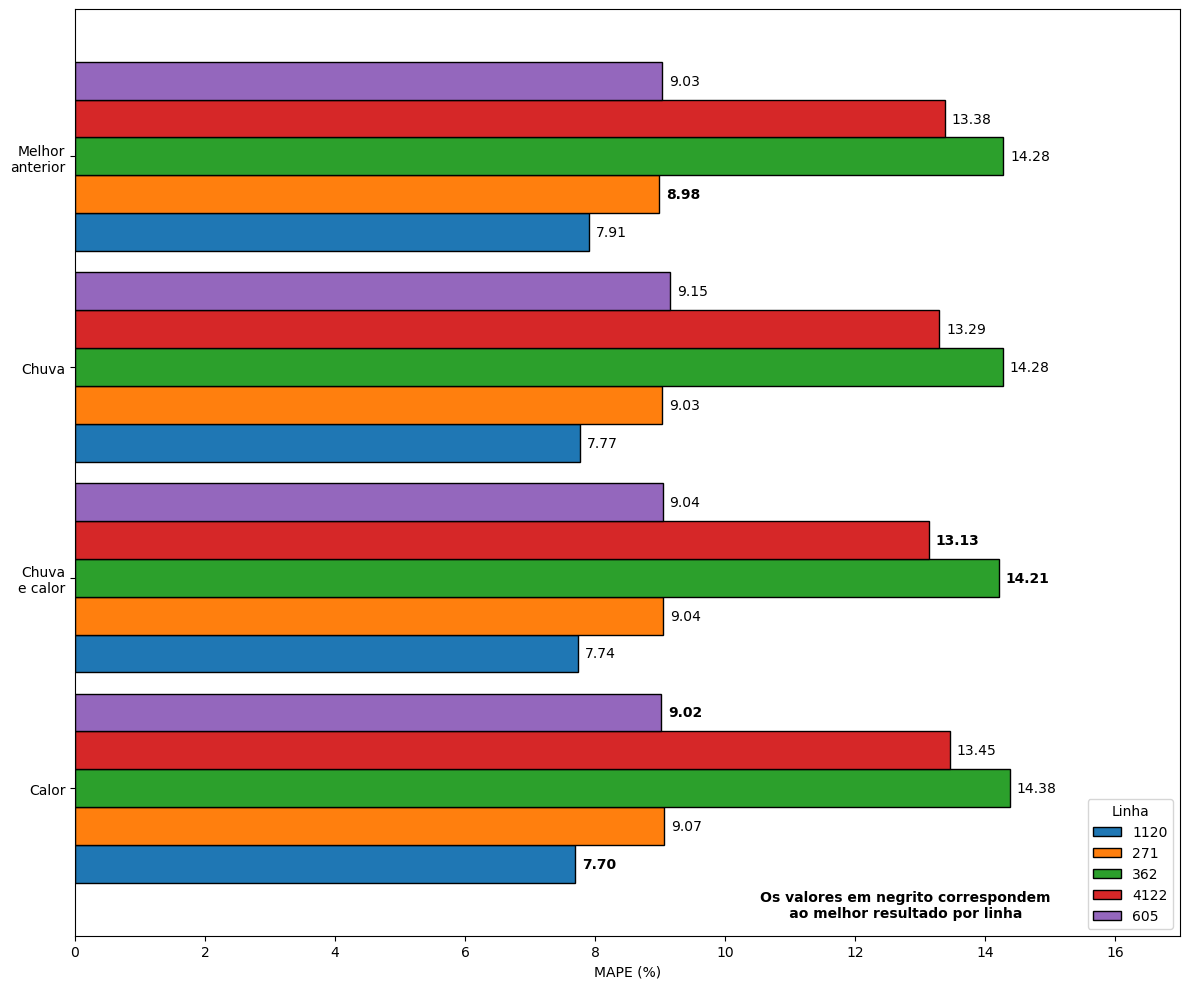

In [74]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest") & (a["Rota"] != "235") & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Random Forest") & (a["Rota"] != "235") & (a["Teste"] == "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["Calor", "Chuva\ne calor", "Chuva", "Melhor\nanterior"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 17)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_rf.svg")


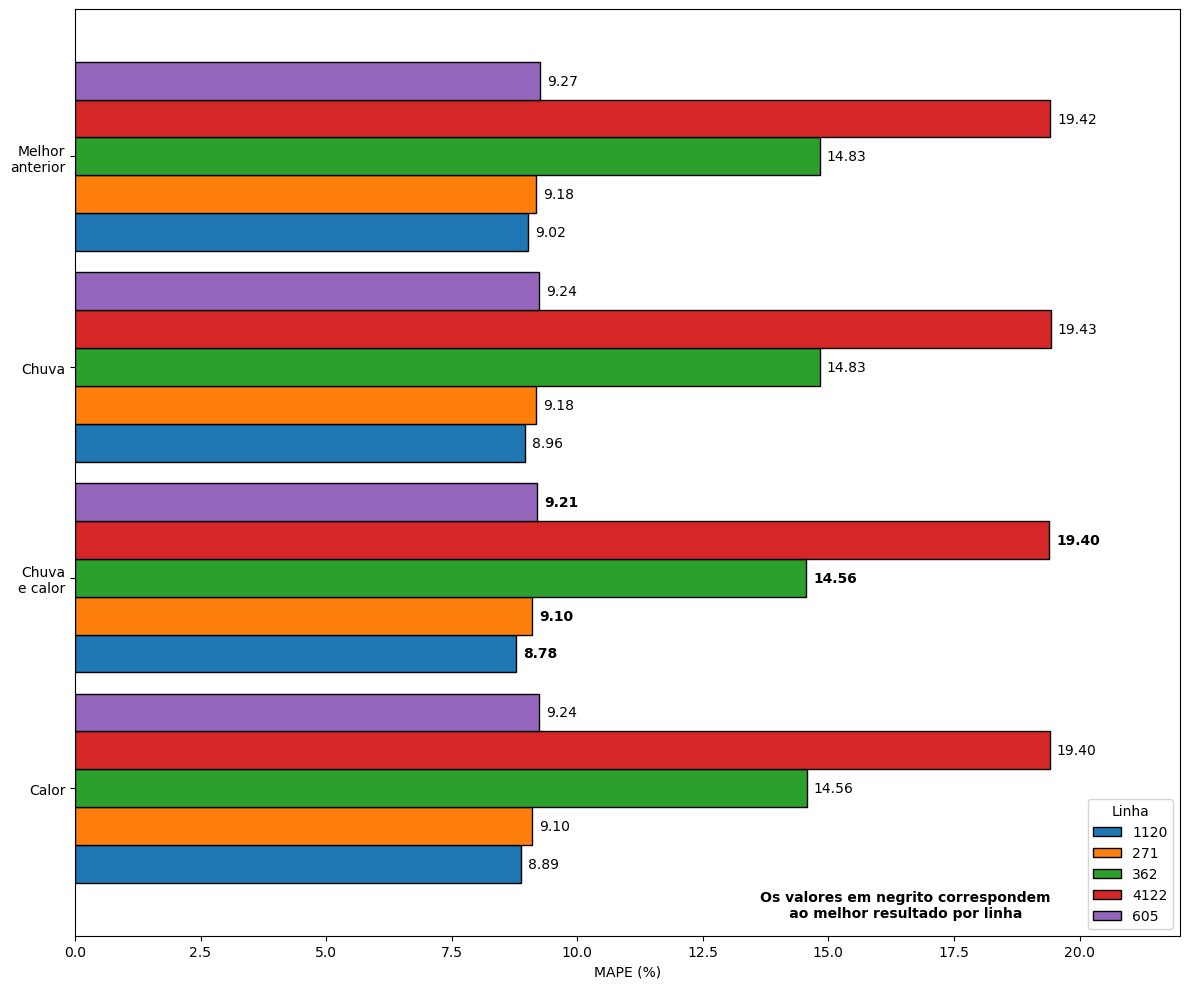

In [77]:
b = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression") & (a["Rota"] != "235") & (a["Teste"].str.contains("2 - Teste"))]
d = a[(a["Métrica"] == "MAPE") & (a["Modelo"] == "Linear Regression") & (a["Rota"] != "235") & (a["Teste"] == "3 Tempos Anterios - ['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7']")]
b = pd.concat([d, b], ignore_index=True)

b["Valor"] = b["Valor"] * 100

df_pivot = b.pivot(index='Teste', columns='Rota', values='Valor').sort_values("Teste")
df_pivot.index = ["Calor", "Chuva\ne calor", "Chuva", "Melhor\nanterior"]

plt.rcParams["figure.autolayout"] = True

ax = df_pivot.plot(kind='barh', width = 0.9, figsize=[12, 10], edgecolor="black")

min_linha = b.groupby("Rota").agg({"Valor": "min"})["Valor"].unique()

for p in ax.patches:
    value = p.get_width()
    value_f = "{:.2f}".format(value)
    if value in min_linha:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')
    else:
        ax.annotate(value_f, (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.xlabel("MAPE (%)")
plt.xlim(0, 22)

ax.legend(title="Linha", loc="lower right")
ax.text(0.62, 0.02, "Os valores em negrito correspondem\n      ao melhor resultado por linha", transform=ax.transAxes, fontsize=10, color="black", fontweight="bold")

plt.savefig("Results/resultados_clima_lr.svg")


# Teste com intervalor de treino diferentes

In [67]:
Intervalos = ['2019-01-01','2019-03-01','2019-05-01','2019-07-01','2019-09-01']

TestesNome = [
    "4 Teste de Intervalos - 1 Janeiro",
    "4 Teste de Intervalos - 2 Março",
    "4 Teste de Intervalos - 3 Maio",
    "4 Teste de Intervalos - 4 Julho",
    "4 Teste de Intervalos - 5 Setembro"
]

# Um loop para rodar os modelos uma rota por vez e um cenário por vez
rotas = df['Linha'].unique()
for rota in rotas:
    df_modelo = df.loc[df['Linha']==rota].sort_values(by=["Ini"], ascending=False)

    for i in range(len(Intervalos)):
        df_teste = df_modelo.loc[df_modelo['Ini'] > Intervalos[i]]
        df_treino = df_modelo.loc[df_modelo['Ini'] <= Intervalos[i]]
        teste_nome = TestesNome[i]

        # Não passamos a Linha pois não faz sentido já que é tudo igual, e tiramos as datas de Ini e Fim pois com elas seria apenas calcular o a duração. E o modelo XGB não aceita datetime
        x_teste = df_teste[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_teste = df_teste["DuraçãoViagem"]
        x_treino = df_treino[['Sentido','TotalGirosMean','dia_semana','hora_dia','dia_ano','DuraçãoViagem_1','DuraçãoViagemMean_d-1','DuraçãoViagemMean_d-7','Chuva','Calor']]
        y_treino = df_treino["DuraçãoViagem"]

        cria_modelo(df_teste, x_teste, y_teste, x_treino, y_treino, rota, teste_nome)

[0]	validation_0-rmse:2853.42796
[1]	validation_0-rmse:2029.20952
[2]	validation_0-rmse:1456.34563
[3]	validation_0-rmse:1059.14516
[4]	validation_0-rmse:786.05647
[5]	validation_0-rmse:598.43295
[6]	validation_0-rmse:469.93121
[7]	validation_0-rmse:380.77913
[8]	validation_0-rmse:320.00110
[9]	validation_0-rmse:271.29697
[10]	validation_0-rmse:244.48201
[11]	validation_0-rmse:227.05387
[12]	validation_0-rmse:216.48991
[13]	validation_0-rmse:197.36110
[14]	validation_0-rmse:191.69935
[15]	validation_0-rmse:186.60783
[16]	validation_0-rmse:183.09486
[17]	validation_0-rmse:171.36630
[18]	validation_0-rmse:156.22534
[19]	validation_0-rmse:140.34617
[20]	validation_0-rmse:134.75218
[21]	validation_0-rmse:131.58312
[22]	validation_0-rmse:124.62278
[23]	validation_0-rmse:116.22342
[24]	validation_0-rmse:112.55456


[25]	validation_0-rmse:106.59848
[26]	validation_0-rmse:98.96726
[27]	validation_0-rmse:96.71503
[28]	validation_0-rmse:94.36496
[29]	validation_0-rmse:92.31997
[30]	validation_0-rmse:88.56576
[31]	validation_0-rmse:85.10142
[32]	validation_0-rmse:81.70476
[33]	validation_0-rmse:78.05536
[34]	validation_0-rmse:76.63252
[35]	validation_0-rmse:73.30781
[36]	validation_0-rmse:71.58816
[37]	validation_0-rmse:70.90262
[38]	validation_0-rmse:65.12385
[39]	validation_0-rmse:63.81755
[40]	validation_0-rmse:61.33951
[41]	validation_0-rmse:56.91474
[42]	validation_0-rmse:55.47614
[43]	validation_0-rmse:52.68513
[44]	validation_0-rmse:47.72176
[45]	validation_0-rmse:47.02628
[46]	validation_0-rmse:44.51695
[47]	validation_0-rmse:44.19773
[48]	validation_0-rmse:42.87175
[49]	validation_0-rmse:42.59910
[50]	validation_0-rmse:41.30599
[51]	validation_0-rmse:40.54551
[52]	validation_0-rmse:37.23838
[53]	validation_0-rmse:33.60492
[54]	validation_0-rmse:32.76410
[55]	validation_0-rmse:31.00125
[56]	va

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2790.47041
[1]	validation_0-rmse:1983.23148
[2]	validation_0-rmse:1426.94103
[3]	validation_0-rmse:1046.26171
[4]	validation_0-rmse:788.02509
[5]	validation_0-rmse:615.44308
[6]	validation_0-rmse:500.66125
[7]	validation_0-rmse:429.70693
[8]	validation_0-rmse:384.90228
[9]	validation_0-rmse:355.90920
[10]	validation_0-rmse:340.46839
[11]	validation_0-rmse:327.35622
[12]	validation_0-rmse:319.32923
[13]	validation_0-rmse:312.93226
[14]	validation_0-rmse:305.65852
[15]	validation_0-rmse:294.17153
[16]	validation_0-rmse:285.94063
[17]	validation_0-rmse:280.12105
[18]	validation_0-rmse:269.44657
[19]	validation_0-rmse:267.99833
[20]	validation_0-rmse:261.08342
[21]	validation_0-rmse:250.38945
[22]	validation_0-rmse:244.24147
[23]	validation_0-rmse:240.33160
[24]	validation_0-rmse:232.76692
[25]	validation_0-rmse:229.64317
[26]	validation_0-rmse:227.74592
[27]	validation_0-rmse:219.04289
[28]	validation_0-rmse:216.10911
[29]	validation_0-rmse:214.13308
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2773.23599
[1]	validation_0-rmse:1970.77086
[2]	validation_0-rmse:1414.12777
[3]	validation_0-rmse:1034.23033
[4]	validation_0-rmse:778.52063
[5]	validation_0-rmse:608.20978
[6]	validation_0-rmse:495.83095
[7]	validation_0-rmse:427.25931
[8]	validation_0-rmse:382.97315
[9]	validation_0-rmse:357.39962
[10]	validation_0-rmse:339.02493
[11]	validation_0-rmse:331.08484
[12]	validation_0-rmse:324.08277
[13]	validation_0-rmse:319.00767
[14]	validation_0-rmse:312.11444
[15]	validation_0-rmse:306.17328
[16]	validation_0-rmse:297.00549
[17]	validation_0-rmse:294.06808
[18]	validation_0-rmse:289.36551
[19]	validation_0-rmse:282.97767
[20]	validation_0-rmse:276.25943
[21]	validation_0-rmse:268.13811
[22]	validation_0-rmse:264.80219
[23]	validation_0-rmse:259.41297
[24]	validation_0-rmse:252.19074
[25]	validation_0-rmse:248.10595
[26]	validation_0-rmse:246.19678
[27]	validation_0-rmse:245.24165
[28]	validation_0-rmse:244.19061
[29]	validation_0-rmse:240.07888
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2761.19465
[1]	validation_0-rmse:1958.55936
[2]	validation_0-rmse:1405.65754
[3]	validation_0-rmse:1025.23758
[4]	validation_0-rmse:770.32107
[5]	validation_0-rmse:602.19423
[6]	validation_0-rmse:491.98059
[7]	validation_0-rmse:424.26161
[8]	validation_0-rmse:380.78657
[9]	validation_0-rmse:357.39664
[10]	validation_0-rmse:340.23059
[11]	validation_0-rmse:328.16868
[12]	validation_0-rmse:321.45528
[13]	validation_0-rmse:311.49503
[14]	validation_0-rmse:304.82756
[15]	validation_0-rmse:300.01912
[16]	validation_0-rmse:297.76173
[17]	validation_0-rmse:291.85860
[18]	validation_0-rmse:288.90453
[19]	validation_0-rmse:284.03078
[20]	validation_0-rmse:279.34395
[21]	validation_0-rmse:277.67766
[22]	validation_0-rmse:276.05408
[23]	validation_0-rmse:269.42718
[24]	validation_0-rmse:262.46969
[25]	validation_0-rmse:258.25535
[26]	validation_0-rmse:255.80286
[27]	validation_0-rmse:254.75971
[28]	validation_0-rmse:249.43824
[29]	validation_0-rmse:247.15339
[30]	validation_

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[13]	validation_0-rmse:315.88071
[14]	validation_0-rmse:309.56688
[15]	validation_0-rmse:307.48722
[16]	validation_0-rmse:304.43204
[17]	validation_0-rmse:302.20196
[18]	validation_0-rmse:295.97589
[19]	validation_0-rmse:291.72574
[20]	validation_0-rmse:285.57482
[21]	validation_0-rmse:284.35896
[22]	validation_0-rmse:279.27952
[23]	validation_0-rmse:274.81961
[24]	validation_0-rmse:270.74273
[25]	validation_0-rmse:268.18421
[26]	validation_0-rmse:267.02599
[27]	validation_0-rmse:263.53939
[28]	validation_0-rmse:260.88583
[29]	validation_0-rmse:255.96722
[30]	validation_0-rmse:253.76841
[31]	validation_0-rmse:252.55675
[32]	validation_0-rmse:248.59918
[33]	validation_0-rmse:246.48046
[34]	validation_0-rmse:243.49497
[35]	validation_0-rmse:240.22416
[36]	validation_0-rmse:239.49657
[37]	validation_0-rmse:238.35571
[38]	validation_0-rmse:233.26299
[39]	validation_0-rmse:229.94887
[40]	validation_0-rmse:227.37900
[41]	validation_0-rmse:224.32030
[42]	validation_0-rmse:222.31155
[43]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[34]	validation_0-rmse:82.43440
[35]	validation_0-rmse:79.23139
[36]	validation_0-rmse:78.32494
[37]	validation_0-rmse:75.59200
[38]	validation_0-rmse:72.71764
[39]	validation_0-rmse:71.17718
[40]	validation_0-rmse:70.24228
[41]	validation_0-rmse:69.38006
[42]	validation_0-rmse:68.52326
[43]	validation_0-rmse:68.41727
[44]	validation_0-rmse:67.60755
[45]	validation_0-rmse:66.59843
[46]	validation_0-rmse:65.42589
[47]	validation_0-rmse:63.43211
[48]	validation_0-rmse:62.08918
[49]	validation_0-rmse:61.72703
[50]	validation_0-rmse:61.38698
[51]	validation_0-rmse:61.11948
[52]	validation_0-rmse:60.62592
[53]	validation_0-rmse:60.20547
[54]	validation_0-rmse:59.31442
[55]	validation_0-rmse:59.03189
[56]	validation_0-rmse:58.57281
[57]	validation_0-rmse:58.47282
[58]	validation_0-rmse:57.65318
[59]	validation_0-rmse:57.55098
[60]	validation_0-rmse:56.94769
[61]	validation_0-rmse:56.83380
[62]	validation_0-rmse:56.01737
[63]	validation_0-rmse:55.71731
[64]	validation_0-rmse:55.64690
[65]	val

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1825.20361
[1]	validation_0-rmse:1309.40231
[2]	validation_0-rmse:952.17456
[3]	validation_0-rmse:704.11623
[4]	validation_0-rmse:534.42196
[5]	validation_0-rmse:418.58433
[6]	validation_0-rmse:339.71900
[7]	validation_0-rmse:286.45996
[8]	validation_0-rmse:252.36015
[9]	validation_0-rmse:228.60464
[10]	validation_0-rmse:213.58639
[11]	validation_0-rmse:203.62900
[12]	validation_0-rmse:196.21917
[13]	validation_0-rmse:191.08881
[14]	validation_0-rmse:187.05555
[15]	validation_0-rmse:177.54906
[16]	validation_0-rmse:174.95962
[17]	validation_0-rmse:172.04477
[18]	validation_0-rmse:165.37476
[19]	validation_0-rmse:162.35218
[20]	validation_0-rmse:160.98049
[21]	validation_0-rmse:158.77574
[22]	validation_0-rmse:155.57503
[23]	validation_0-rmse:152.57486
[24]	validation_0-rmse:150.85163
[25]	validation_0-rmse:145.91536
[26]	validation_0-rmse:144.51286
[27]	validation_0-rmse:143.55837
[28]	validation_0-rmse:141.40307
[29]	validation_0-rmse:139.81450
[30]	validation_0-

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1914.26096
[1]	validation_0-rmse:1368.82248
[2]	validation_0-rmse:991.63185
[3]	validation_0-rmse:730.79811
[4]	validation_0-rmse:554.38783
[5]	validation_0-rmse:437.15242
[6]	validation_0-rmse:359.25102
[7]	validation_0-rmse:311.66158
[8]	validation_0-rmse:277.03466
[9]	validation_0-rmse:255.11172
[10]	validation_0-rmse:240.16879
[11]	validation_0-rmse:228.95585
[12]	validation_0-rmse:222.29334
[13]	validation_0-rmse:218.11378
[14]	validation_0-rmse:213.34639
[15]	validation_0-rmse:205.81240
[16]	validation_0-rmse:199.10701
[17]	validation_0-rmse:195.83612
[18]	validation_0-rmse:193.31765
[19]	validation_0-rmse:191.70769
[20]	validation_0-rmse:188.35959
[21]	validation_0-rmse:186.80031
[22]	validation_0-rmse:182.08724
[23]	validation_0-rmse:181.63198
[24]	validation_0-rmse:179.37748
[25]	validation_0-rmse:173.87102
[26]	validation_0-rmse:172.04217
[27]	validation_0-rmse:168.10744
[28]	validation_0-rmse:165.09883
[29]	validation_0-rmse:164.69465
[30]	validation_0-

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1945.55298
[1]	validation_0-rmse:1390.77575
[2]	validation_0-rmse:1006.70049
[3]	validation_0-rmse:741.74140
[4]	validation_0-rmse:565.00690
[5]	validation_0-rmse:447.69644
[6]	validation_0-rmse:371.43123
[7]	validation_0-rmse:321.08181
[8]	validation_0-rmse:290.51957
[9]	validation_0-rmse:271.56844
[10]	validation_0-rmse:258.48838
[11]	validation_0-rmse:249.15745
[12]	validation_0-rmse:241.58478
[13]	validation_0-rmse:235.54885
[14]	validation_0-rmse:232.75126
[15]	validation_0-rmse:229.21043
[16]	validation_0-rmse:221.55935
[17]	validation_0-rmse:216.35959
[18]	validation_0-rmse:210.87235
[19]	validation_0-rmse:209.37379
[20]	validation_0-rmse:207.48547
[21]	validation_0-rmse:206.19975
[22]	validation_0-rmse:203.37602
[23]	validation_0-rmse:202.57515
[24]	validation_0-rmse:201.24532
[25]	validation_0-rmse:199.64212
[26]	validation_0-rmse:198.31603
[27]	validation_0-rmse:196.19407
[28]	validation_0-rmse:194.38071
[29]	validation_0-rmse:191.42488
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[3]	validation_0-rmse:747.40213
[4]	validation_0-rmse:568.19451
[5]	validation_0-rmse:450.19161
[6]	validation_0-rmse:375.84232
[7]	validation_0-rmse:326.72072
[8]	validation_0-rmse:297.85173
[9]	validation_0-rmse:277.79104
[10]	validation_0-rmse:266.93813
[11]	validation_0-rmse:260.61324
[12]	validation_0-rmse:253.58936
[13]	validation_0-rmse:248.68588
[14]	validation_0-rmse:244.97173
[15]	validation_0-rmse:239.97449
[16]	validation_0-rmse:235.31712
[17]	validation_0-rmse:230.33521
[18]	validation_0-rmse:225.05950
[19]	validation_0-rmse:221.97487
[20]	validation_0-rmse:217.95241
[21]	validation_0-rmse:214.26035
[22]	validation_0-rmse:212.82766
[23]	validation_0-rmse:209.95568
[24]	validation_0-rmse:208.04499
[25]	validation_0-rmse:206.58635
[26]	validation_0-rmse:206.13006
[27]	validation_0-rmse:204.93065
[28]	validation_0-rmse:203.78982
[29]	validation_0-rmse:202.10776
[30]	validation_0-rmse:200.34838
[31]	validation_0-rmse:196.97462
[32]	validation_0-rmse:194.73294
[33]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[15]	validation_0-rmse:129.30385
[16]	validation_0-rmse:128.57189
[17]	validation_0-rmse:126.57374
[18]	validation_0-rmse:125.41023
[19]	validation_0-rmse:123.67594
[20]	validation_0-rmse:122.45663
[21]	validation_0-rmse:120.58917
[22]	validation_0-rmse:118.62308
[23]	validation_0-rmse:116.96311
[24]	validation_0-rmse:115.30343
[25]	validation_0-rmse:114.34126
[26]	validation_0-rmse:111.76724
[27]	validation_0-rmse:109.74353
[28]	validation_0-rmse:109.19590
[29]	validation_0-rmse:107.05604
[30]	validation_0-rmse:106.35500
[31]	validation_0-rmse:104.38966
[32]	validation_0-rmse:103.66635
[33]	validation_0-rmse:102.84381
[34]	validation_0-rmse:101.63179
[35]	validation_0-rmse:100.43409
[36]	validation_0-rmse:99.07405
[37]	validation_0-rmse:98.32308
[38]	validation_0-rmse:97.74981
[39]	validation_0-rmse:96.40277
[40]	validation_0-rmse:95.90263
[41]	validation_0-rmse:93.93235
[42]	validation_0-rmse:93.15220
[43]	validation_0-rmse:92.48001
[44]	validation_0-rmse:90.63859
[45]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1031.72590
[1]	validation_0-rmse:734.12799
[2]	validation_0-rmse:528.91773
[3]	validation_0-rmse:390.06280
[4]	validation_0-rmse:297.65160
[5]	validation_0-rmse:238.96691
[6]	validation_0-rmse:202.30263
[7]	validation_0-rmse:179.52021
[8]	validation_0-rmse:167.64226
[9]	validation_0-rmse:159.14793
[10]	validation_0-rmse:154.52938
[11]	validation_0-rmse:152.33284
[12]	validation_0-rmse:148.16854
[13]	validation_0-rmse:146.47808
[14]	validation_0-rmse:144.68490
[15]	validation_0-rmse:143.30311
[16]	validation_0-rmse:142.73401
[17]	validation_0-rmse:140.97306
[18]	validation_0-rmse:139.78729
[19]	validation_0-rmse:138.97769
[20]	validation_0-rmse:138.43485
[21]	validation_0-rmse:137.28406
[22]	validation_0-rmse:135.84831
[23]	validation_0-rmse:134.48040
[24]	validation_0-rmse:132.80917
[25]	validation_0-rmse:132.46409
[26]	validation_0-rmse:131.42788
[27]	validation_0-rmse:129.66646
[28]	validation_0-rmse:128.60889
[29]	validation_0-rmse:127.62890
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1024.93551
[1]	validation_0-rmse:729.03764
[2]	validation_0-rmse:525.30356
[3]	validation_0-rmse:387.11328
[4]	validation_0-rmse:295.95596
[5]	validation_0-rmse:237.78824
[6]	validation_0-rmse:201.21617
[7]	validation_0-rmse:181.21046
[8]	validation_0-rmse:168.17425
[9]	validation_0-rmse:161.42061
[10]	validation_0-rmse:156.25687
[11]	validation_0-rmse:154.02083
[12]	validation_0-rmse:152.59934
[13]	validation_0-rmse:150.69541
[14]	validation_0-rmse:149.75244
[15]	validation_0-rmse:147.90546
[16]	validation_0-rmse:146.80136
[17]	validation_0-rmse:145.38796
[18]	validation_0-rmse:144.61735
[19]	validation_0-rmse:142.38722
[20]	validation_0-rmse:141.95319
[21]	validation_0-rmse:140.85554
[22]	validation_0-rmse:139.97536
[23]	validation_0-rmse:138.51893
[24]	validation_0-rmse:138.25306
[25]	validation_0-rmse:137.81671
[26]	validation_0-rmse:136.77454
[27]	validation_0-rmse:136.29837
[28]	validation_0-rmse:134.99221
[29]	validation_0-rmse:133.91522
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1017.17095
[1]	validation_0-rmse:723.12679
[2]	validation_0-rmse:520.83278
[3]	validation_0-rmse:383.51201
[4]	validation_0-rmse:292.20753
[5]	validation_0-rmse:234.28560
[6]	validation_0-rmse:199.06628
[7]	validation_0-rmse:179.09754
[8]	validation_0-rmse:168.02140
[9]	validation_0-rmse:161.84344
[10]	validation_0-rmse:158.29698
[11]	validation_0-rmse:155.49418
[12]	validation_0-rmse:152.33581
[13]	validation_0-rmse:150.90136
[14]	validation_0-rmse:150.11765
[15]	validation_0-rmse:148.29793
[16]	validation_0-rmse:147.85030
[17]	validation_0-rmse:147.01313
[18]	validation_0-rmse:144.53269
[19]	validation_0-rmse:144.05055
[20]	validation_0-rmse:143.03573
[21]	validation_0-rmse:142.00967
[22]	validation_0-rmse:141.59417
[23]	validation_0-rmse:140.57458
[24]	validation_0-rmse:139.84086
[25]	validation_0-rmse:138.80853
[26]	validation_0-rmse:137.16270
[27]	validation_0-rmse:136.37989
[28]	validation_0-rmse:135.88126
[29]	validation_0-rmse:135.62714
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:1011.72839
[1]	validation_0-rmse:719.20186
[2]	validation_0-rmse:517.81112
[3]	validation_0-rmse:381.29744
[4]	validation_0-rmse:290.83129
[5]	validation_0-rmse:233.63395
[6]	validation_0-rmse:198.39670
[7]	validation_0-rmse:178.84629
[8]	validation_0-rmse:167.32404
[9]	validation_0-rmse:159.78451
[10]	validation_0-rmse:155.68786
[11]	validation_0-rmse:153.93635
[12]	validation_0-rmse:152.52805
[13]	validation_0-rmse:150.97449
[14]	validation_0-rmse:150.56501
[15]	validation_0-rmse:150.02233
[16]	validation_0-rmse:147.80508
[17]	validation_0-rmse:146.69519
[18]	validation_0-rmse:146.26236
[19]	validation_0-rmse:145.96464
[20]	validation_0-rmse:145.09906
[21]	validation_0-rmse:144.52948
[22]	validation_0-rmse:144.03062
[23]	validation_0-rmse:142.70106
[24]	validation_0-rmse:141.87839
[25]	validation_0-rmse:141.20693
[26]	validation_0-rmse:140.75094
[27]	validation_0-rmse:140.20816
[28]	validation_0-rmse:139.25232
[29]	validation_0-rmse:138.46882
[30]	validation_0-r

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:598.92098
[1]	validation_0-rmse:434.31258
[2]	validation_0-rmse:322.38867
[3]	validation_0-rmse:247.25466
[4]	validation_0-rmse:195.89425
[5]	validation_0-rmse:161.37309
[6]	validation_0-rmse:138.76351
[7]	validation_0-rmse:124.94225
[8]	validation_0-rmse:116.07748
[9]	validation_0-rmse:107.86981
[10]	validation_0-rmse:102.93615
[11]	validation_0-rmse:100.85835
[12]	validation_0-rmse:97.48214
[13]	validation_0-rmse:93.49071
[14]	validation_0-rmse:91.83820
[15]	validation_0-rmse:91.38972
[16]	validation_0-rmse:87.67944
[17]	validation_0-rmse:86.48234
[18]	validation_0-rmse:83.91416
[19]	validation_0-rmse:83.51831
[20]	validation_0-rmse:81.28741
[21]	validation_0-rmse:79.78815
[22]	validation_0-rmse:79.18870
[23]	validation_0-rmse:76.44150
[24]	validation_0-rmse:76.01839
[25]	validation_0-rmse:73.68379
[26]	validation_0-rmse:70.83088
[27]	validation_0-rmse:70.24869
[28]	validation_0-rmse:68.26988
[29]	validation_0-rmse:66.99792
[30]	validation_0-rmse:66.78167
[31]	v

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:609.30960
[1]	validation_0-rmse:441.35241
[2]	validation_0-rmse:327.13501
[3]	validation_0-rmse:251.39373
[4]	validation_0-rmse:201.51534
[5]	validation_0-rmse:169.41425
[6]	validation_0-rmse:149.43393
[7]	validation_0-rmse:136.76325
[8]	validation_0-rmse:128.92231
[9]	validation_0-rmse:123.18296
[10]	validation_0-rmse:119.93627
[11]	validation_0-rmse:116.86895
[12]	validation_0-rmse:115.40376
[13]	validation_0-rmse:113.02464
[14]	validation_0-rmse:110.90138
[15]	validation_0-rmse:108.74789
[16]	validation_0-rmse:108.10377
[17]	validation_0-rmse:105.73099
[18]	validation_0-rmse:105.08727
[19]	validation_0-rmse:103.82107
[20]	validation_0-rmse:102.24348
[21]	validation_0-rmse:100.99485
[22]	validation_0-rmse:99.32597
[23]	validation_0-rmse:98.52046
[24]	validation_0-rmse:96.45338
[25]	validation_0-rmse:94.64815
[26]	validation_0-rmse:92.57836
[27]	validation_0-rmse:91.61814
[28]	validation_0-rmse:90.63489
[29]	validation_0-rmse:89.50298
[30]	validation_0-rmse:89.03

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:607.11745
[1]	validation_0-rmse:439.02629
[2]	validation_0-rmse:325.43420
[3]	validation_0-rmse:249.95847
[4]	validation_0-rmse:201.19844
[5]	validation_0-rmse:170.45572
[6]	validation_0-rmse:151.90064
[7]	validation_0-rmse:140.51951
[8]	validation_0-rmse:134.19201
[9]	validation_0-rmse:130.05809
[10]	validation_0-rmse:127.00577
[11]	validation_0-rmse:125.17560
[12]	validation_0-rmse:121.91156
[13]	validation_0-rmse:120.15145
[14]	validation_0-rmse:118.66126
[15]	validation_0-rmse:116.58442
[16]	validation_0-rmse:115.68437
[17]	validation_0-rmse:113.83565
[18]	validation_0-rmse:113.47391
[19]	validation_0-rmse:112.56094
[20]	validation_0-rmse:110.68009
[21]	validation_0-rmse:109.65141
[22]	validation_0-rmse:109.08026
[23]	validation_0-rmse:107.52458
[24]	validation_0-rmse:106.96430
[25]	validation_0-rmse:106.61644
[26]	validation_0-rmse:105.64173
[27]	validation_0-rmse:105.19100
[28]	validation_0-rmse:104.38978
[29]	validation_0-rmse:103.24573
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:605.01413
[1]	validation_0-rmse:437.13582
[2]	validation_0-rmse:323.56179
[3]	validation_0-rmse:248.44135
[4]	validation_0-rmse:200.12027
[5]	validation_0-rmse:170.30276
[6]	validation_0-rmse:152.81001
[7]	validation_0-rmse:142.52518
[8]	validation_0-rmse:135.83074
[9]	validation_0-rmse:131.40571
[10]	validation_0-rmse:128.85833
[11]	validation_0-rmse:126.83839
[12]	validation_0-rmse:125.67512
[13]	validation_0-rmse:124.09258
[14]	validation_0-rmse:123.28892
[15]	validation_0-rmse:121.90762
[16]	validation_0-rmse:120.61395
[17]	validation_0-rmse:118.63608
[18]	validation_0-rmse:116.69545
[19]	validation_0-rmse:116.20959
[20]	validation_0-rmse:114.73970
[21]	validation_0-rmse:114.35104
[22]	validation_0-rmse:113.62809
[23]	validation_0-rmse:112.74912
[24]	validation_0-rmse:111.59896
[25]	validation_0-rmse:110.75058
[26]	validation_0-rmse:109.42813
[27]	validation_0-rmse:108.29569
[28]	validation_0-rmse:107.64509
[29]	validation_0-rmse:107.13156
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:602.42001
[1]	validation_0-rmse:435.27463
[2]	validation_0-rmse:322.20331
[3]	validation_0-rmse:247.50451
[4]	validation_0-rmse:200.06315
[5]	validation_0-rmse:171.11900
[6]	validation_0-rmse:153.48523
[7]	validation_0-rmse:143.47272
[8]	validation_0-rmse:137.70424
[9]	validation_0-rmse:134.43821
[10]	validation_0-rmse:132.17845
[11]	validation_0-rmse:130.21137
[12]	validation_0-rmse:128.16059
[13]	validation_0-rmse:127.66126
[14]	validation_0-rmse:126.84709
[15]	validation_0-rmse:126.08332
[16]	validation_0-rmse:125.64428
[17]	validation_0-rmse:124.69978
[18]	validation_0-rmse:124.29095
[19]	validation_0-rmse:122.40981
[20]	validation_0-rmse:122.07011
[21]	validation_0-rmse:120.96571
[22]	validation_0-rmse:120.53936
[23]	validation_0-rmse:119.21498
[24]	validation_0-rmse:118.22477
[25]	validation_0-rmse:117.83762
[26]	validation_0-rmse:117.52820
[27]	validation_0-rmse:116.28525
[28]	validation_0-rmse:115.46922
[29]	validation_0-rmse:114.33303
[30]	validation_0-rm

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1707.04003
[2]	validation_0-rmse:1243.60228
[3]	validation_0-rmse:926.20878
[4]	validation_0-rmse:705.73689
[5]	validation_0-rmse:551.55253
[6]	validation_0-rmse:441.33732
[7]	validation_0-rmse:368.37623
[8]	validation_0-rmse:315.02341
[9]	validation_0-rmse:279.55603
[10]	validation_0-rmse:240.57341
[11]	validation_0-rmse:219.53741
[12]	validation_0-rmse:203.29917
[13]	validation_0-rmse:188.93783
[14]	validation_0-rmse:179.69585
[15]	validation_0-rmse:162.45567
[16]	validation_0-rmse:155.76203
[17]	validation_0-rmse:152.22921
[18]	validation_0-rmse:147.60290
[19]	validation_0-rmse:134.26956
[20]	validation_0-rmse:131.84919
[21]	validation_0-rmse:122.69402
[22]	validation_0-rmse:120.98743
[23]	validation_0-rmse:113.68184
[24]	validation_0-rmse:112.13889
[25]	validation_0-rmse:105.04682
[26]	validation_0-rmse:103.51413
[27]	validation_0-rmse:96.69626
[28]	validation_0-rmse:95.59608
[29]	validation_0-rmse:92.67459
[30]	validation_0-rmse:86.64707
[31]	validation_0-rms

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2357.23405
[1]	validation_0-rmse:1691.95330
[2]	validation_0-rmse:1234.42891
[3]	validation_0-rmse:919.66500
[4]	validation_0-rmse:709.23838
[5]	validation_0-rmse:569.89233
[6]	validation_0-rmse:480.20882
[7]	validation_0-rmse:424.72376
[8]	validation_0-rmse:378.24821
[9]	validation_0-rmse:352.10088
[10]	validation_0-rmse:335.07000
[11]	validation_0-rmse:324.54637
[12]	validation_0-rmse:303.72120
[13]	validation_0-rmse:296.47997
[14]	validation_0-rmse:290.21136
[15]	validation_0-rmse:286.07627
[16]	validation_0-rmse:272.08118
[17]	validation_0-rmse:255.83423
[18]	validation_0-rmse:251.80423
[19]	validation_0-rmse:241.44535
[20]	validation_0-rmse:229.10307
[21]	validation_0-rmse:223.32526
[22]	validation_0-rmse:218.83234
[23]	validation_0-rmse:214.25863
[24]	validation_0-rmse:206.51331
[25]	validation_0-rmse:204.32397
[26]	validation_0-rmse:201.54609
[27]	validation_0-rmse:197.89627
[28]	validation_0-rmse:185.49473
[29]	validation_0-rmse:183.51510
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2324.03308
[1]	validation_0-rmse:1671.69341
[2]	validation_0-rmse:1225.29579
[3]	validation_0-rmse:919.79562
[4]	validation_0-rmse:715.77388
[5]	validation_0-rmse:583.28486
[6]	validation_0-rmse:500.63469
[7]	validation_0-rmse:441.58641
[8]	validation_0-rmse:408.02443
[9]	validation_0-rmse:381.25473
[10]	validation_0-rmse:359.66621
[11]	validation_0-rmse:349.77023
[12]	validation_0-rmse:341.17547
[13]	validation_0-rmse:332.17107
[14]	validation_0-rmse:326.66352
[15]	validation_0-rmse:318.92234
[16]	validation_0-rmse:315.27330
[17]	validation_0-rmse:312.04683
[18]	validation_0-rmse:302.59069
[19]	validation_0-rmse:297.73882
[20]	validation_0-rmse:288.89641
[21]	validation_0-rmse:284.20291
[22]	validation_0-rmse:272.58409
[23]	validation_0-rmse:270.85953
[24]	validation_0-rmse:267.42923
[25]	validation_0-rmse:263.33055
[26]	validation_0-rmse:258.10950
[27]	validation_0-rmse:250.67542
[28]	validation_0-rmse:246.15750
[29]	validation_0-rmse:238.83528
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[0]	validation_0-rmse:2281.00142
[1]	validation_0-rmse:1639.86250
[2]	validation_0-rmse:1199.15207
[3]	validation_0-rmse:897.98920
[4]	validation_0-rmse:696.00520
[5]	validation_0-rmse:564.90996
[6]	validation_0-rmse:484.35826
[7]	validation_0-rmse:432.10543
[8]	validation_0-rmse:393.05266
[9]	validation_0-rmse:372.44041
[10]	validation_0-rmse:360.41070
[11]	validation_0-rmse:344.69909
[12]	validation_0-rmse:332.49057
[13]	validation_0-rmse:321.54614
[14]	validation_0-rmse:319.07020
[15]	validation_0-rmse:311.02802
[16]	validation_0-rmse:304.28570
[17]	validation_0-rmse:295.73753
[18]	validation_0-rmse:290.05792
[19]	validation_0-rmse:288.76010
[20]	validation_0-rmse:285.07425
[21]	validation_0-rmse:275.41371
[22]	validation_0-rmse:271.29205
[23]	validation_0-rmse:266.55367
[24]	validation_0-rmse:261.68991
[25]	validation_0-rmse:257.54479
[26]	validation_0-rmse:249.25889
[27]	validation_0-rmse:248.26597
[28]	validation_0-rmse:246.74067
[29]	validation_0-rmse:243.21166
[30]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[11]	validation_0-rmse:350.78831
[12]	validation_0-rmse:338.72718
[13]	validation_0-rmse:332.36779
[14]	validation_0-rmse:327.52072
[15]	validation_0-rmse:325.65510
[16]	validation_0-rmse:321.71601
[17]	validation_0-rmse:314.14843
[18]	validation_0-rmse:307.21378
[19]	validation_0-rmse:302.12942
[20]	validation_0-rmse:297.44569
[21]	validation_0-rmse:292.33186
[22]	validation_0-rmse:288.86312
[23]	validation_0-rmse:284.55890
[24]	validation_0-rmse:280.17460
[25]	validation_0-rmse:275.85668
[26]	validation_0-rmse:274.35626
[27]	validation_0-rmse:272.02681
[28]	validation_0-rmse:266.60489
[29]	validation_0-rmse:264.90650
[30]	validation_0-rmse:262.88490
[31]	validation_0-rmse:257.08295
[32]	validation_0-rmse:250.56158
[33]	validation_0-rmse:246.46924
[34]	validation_0-rmse:241.57625
[35]	validation_0-rmse:237.27104
[36]	validation_0-rmse:234.61249
[37]	validation_0-rmse:233.24634
[38]	validation_0-rmse:230.92933
[39]	validation_0-rmse:226.93998
[40]	validation_0-rmse:224.08435
[41]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[68]	validation_0-rmse:24.70903
[69]	validation_0-rmse:24.51920
[70]	validation_0-rmse:24.43683
[71]	validation_0-rmse:24.16009
[72]	validation_0-rmse:24.11705
[73]	validation_0-rmse:23.97690
[74]	validation_0-rmse:23.78235
[75]	validation_0-rmse:23.72108
[76]	validation_0-rmse:23.53088
[77]	validation_0-rmse:23.46412
[78]	validation_0-rmse:23.43115
[79]	validation_0-rmse:23.41101
[80]	validation_0-rmse:23.40359
[81]	validation_0-rmse:23.34793
[82]	validation_0-rmse:23.25461
[83]	validation_0-rmse:23.19954
[84]	validation_0-rmse:23.16128
[85]	validation_0-rmse:23.15019
[86]	validation_0-rmse:23.09592
[87]	validation_0-rmse:23.04311
[88]	validation_0-rmse:23.03920
[89]	validation_0-rmse:23.03133
[90]	validation_0-rmse:23.02192
[91]	validation_0-rmse:23.01918
[92]	validation_0-rmse:23.01566
[93]	validation_0-rmse:22.99989
[94]	validation_0-rmse:22.99888
[95]	validation_0-rmse:22.99656
[96]	validation_0-rmse:22.97724
[97]	validation_0-rmse:22.96728
[98]	validation_0-rmse:22.96485
[99]	val

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[1]	validation_0-rmse:1620.84520
[2]	validation_0-rmse:1160.54840
[3]	validation_0-rmse:842.99580
[4]	validation_0-rmse:626.69099
[5]	validation_0-rmse:478.65330
[6]	validation_0-rmse:380.93567
[7]	validation_0-rmse:319.55073
[8]	validation_0-rmse:276.55748
[9]	validation_0-rmse:246.66111
[10]	validation_0-rmse:230.83069
[11]	validation_0-rmse:217.27863
[12]	validation_0-rmse:202.52814
[13]	validation_0-rmse:197.29123
[14]	validation_0-rmse:195.07298
[15]	validation_0-rmse:191.93041
[16]	validation_0-rmse:180.51816
[17]	validation_0-rmse:174.10097
[18]	validation_0-rmse:163.54431
[19]	validation_0-rmse:162.41589
[20]	validation_0-rmse:154.81522
[21]	validation_0-rmse:152.03096
[22]	validation_0-rmse:145.96159
[23]	validation_0-rmse:142.19585
[24]	validation_0-rmse:132.94529
[25]	validation_0-rmse:131.60709
[26]	validation_0-rmse:129.91651
[27]	validation_0-rmse:124.03550
[28]	validation_0-rmse:119.90592
[29]	validation_0-rmse:115.85147
[30]	validation_0-rmse:113.18674
[31]	validation_0

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[8]	validation_0-rmse:293.82839
[9]	validation_0-rmse:264.60947
[10]	validation_0-rmse:250.82605
[11]	validation_0-rmse:237.75689
[12]	validation_0-rmse:231.87889
[13]	validation_0-rmse:225.64010
[14]	validation_0-rmse:214.69289
[15]	validation_0-rmse:211.37562
[16]	validation_0-rmse:197.75560
[17]	validation_0-rmse:194.56374
[18]	validation_0-rmse:187.85677
[19]	validation_0-rmse:182.55882
[20]	validation_0-rmse:174.70855
[21]	validation_0-rmse:170.58358
[22]	validation_0-rmse:164.95673
[23]	validation_0-rmse:162.78979
[24]	validation_0-rmse:153.59674
[25]	validation_0-rmse:152.00458
[26]	validation_0-rmse:150.49095
[27]	validation_0-rmse:143.33184
[28]	validation_0-rmse:141.52520
[29]	validation_0-rmse:138.30266
[30]	validation_0-rmse:135.26766
[31]	validation_0-rmse:133.54921
[32]	validation_0-rmse:127.92898
[33]	validation_0-rmse:122.28621
[34]	validation_0-rmse:121.39098
[35]	validation_0-rmse:118.16855
[36]	validation_0-rmse:116.49195
[37]	validation_0-rmse:114.65476
[38]	validat

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[20]	validation_0-rmse:203.58418
[21]	validation_0-rmse:201.84762
[22]	validation_0-rmse:200.48510
[23]	validation_0-rmse:198.43489
[24]	validation_0-rmse:195.64299
[25]	validation_0-rmse:192.27200
[26]	validation_0-rmse:186.10312
[27]	validation_0-rmse:182.52693
[28]	validation_0-rmse:179.89092
[29]	validation_0-rmse:176.61242
[30]	validation_0-rmse:175.15585
[31]	validation_0-rmse:172.97424
[32]	validation_0-rmse:171.14101
[33]	validation_0-rmse:170.31560
[34]	validation_0-rmse:166.27993
[35]	validation_0-rmse:163.38547
[36]	validation_0-rmse:161.28423
[37]	validation_0-rmse:157.32686
[38]	validation_0-rmse:153.46994
[39]	validation_0-rmse:150.83099
[40]	validation_0-rmse:147.49643
[41]	validation_0-rmse:146.33207
[42]	validation_0-rmse:142.90946
[43]	validation_0-rmse:139.65585
[44]	validation_0-rmse:139.11647
[45]	validation_0-rmse:137.37697
[46]	validation_0-rmse:135.61136
[47]	validation_0-rmse:135.08218
[48]	validation_0-rmse:134.08426
[49]	validation_0-rmse:133.24543
[50]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

[25]	validation_0-rmse:211.03468
[26]	validation_0-rmse:208.11146
[27]	validation_0-rmse:206.72239
[28]	validation_0-rmse:204.23517
[29]	validation_0-rmse:201.15853
[30]	validation_0-rmse:199.42827
[31]	validation_0-rmse:195.57697
[32]	validation_0-rmse:194.81548
[33]	validation_0-rmse:192.15888
[34]	validation_0-rmse:189.05279
[35]	validation_0-rmse:187.48457
[36]	validation_0-rmse:185.61852
[37]	validation_0-rmse:183.73918
[38]	validation_0-rmse:179.12003
[39]	validation_0-rmse:176.83818
[40]	validation_0-rmse:176.19516
[41]	validation_0-rmse:174.95153
[42]	validation_0-rmse:170.18743
[43]	validation_0-rmse:165.10361
[44]	validation_0-rmse:161.51962
[45]	validation_0-rmse:159.00090
[46]	validation_0-rmse:154.96150
[47]	validation_0-rmse:153.69178
[48]	validation_0-rmse:151.67026
[49]	validation_0-rmse:151.07569
[50]	validation_0-rmse:150.74312
[51]	validation_0-rmse:148.46531
[52]	validation_0-rmse:148.20842
[53]	validation_0-rmse:145.59510
[54]	validation_0-rmse:144.28786
[55]	valid

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeXGB}'] = modelo_xgb.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste[f'{TesteNomeRF}'] = modelo_rf.predict(x_teste)
C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3363479619.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [68]:
a = pd.DataFrame(metrics, columns=['Teste','Rota','Modelo','Métrica','Valor', 'Tempo de treino', 'Tempo de previsão'])
a.loc[a['Métrica'] == 'RMSE'].sort_values(by='Valor')

,Teste,Rota,Modelo,Métrica,Valor,Tempo de treino,Tempo de previsão
632,4 Teste de Intervalos - 3 Maio,362,Random Forest,RMSE,151.810172,0.983925,0.45393
476,"2 - Teste clima - ['Sentido','TotalGirosMean',...",362,Random Forest,RMSE,153.683982,1.512799,0.31545
634,4 Teste de Intervalos - 3 Maio,362,Linear Regression,RMSE,154.150919,0.151500,0.99700
482,"2 - Teste clima - ['Sentido','TotalGirosMean',...",362,Random Forest,RMSE,154.437525,1.464594,0.31555
628,4 Teste de Intervalos - 2 Março,362,Linear Regression,RMSE,154.532498,0.348900,0.21970
...,...,...,...,...,...,...,...
82,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Linear Regression,RMSE,861.481548,0.203600,0.20210
78,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,XGBoost,RMSE,866.977726,0.195787,0.17460
80,"1 Teste de Colunas - ['dia_semana','hora_dia',...",235,Random Forest,RMSE,889.844841,0.374796,0.11485
74,"1 Teste de Colunas - ['TotalGirosMean','dia_se...",235,Random Forest,RMSE,895.468309,0.468638,0.14549


C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\2387268729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]


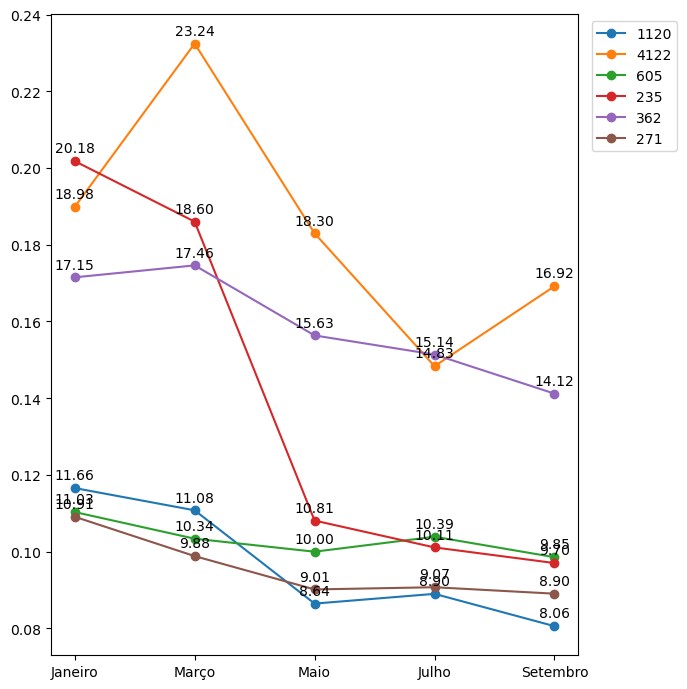

<Figure size 640x480 with 0 Axes>

In [71]:
b = a[(a["Modelo"] == "XGBoost") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

plt.savefig("Results/resultados_intervalo_treino_xgb.svg")

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\3590681933.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]


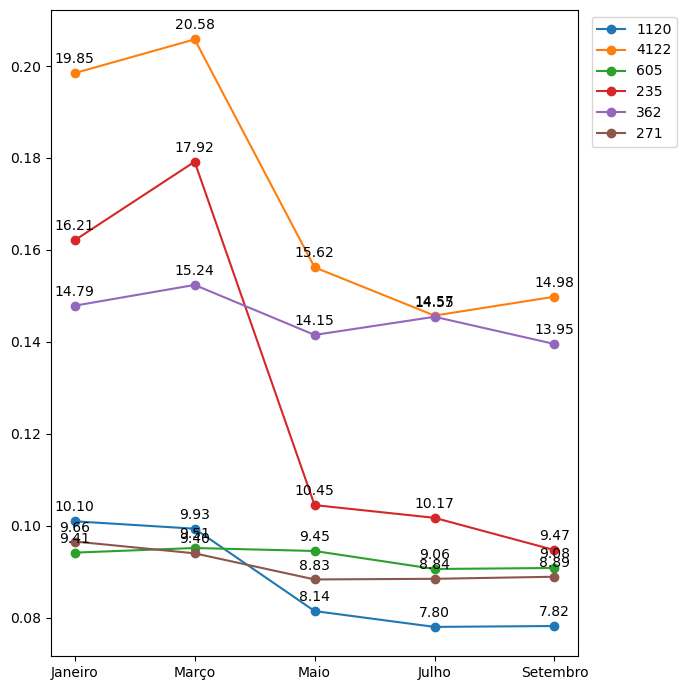

<Figure size 640x480 with 0 Axes>

In [72]:
b = a[(a["Modelo"] == "Random Forest") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

plt.savefig("Results/resultados_intervalo_treino_rf.svg")

C:\Users\leovi\AppData\Local\Temp\ipykernel_38416\1103799855.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]


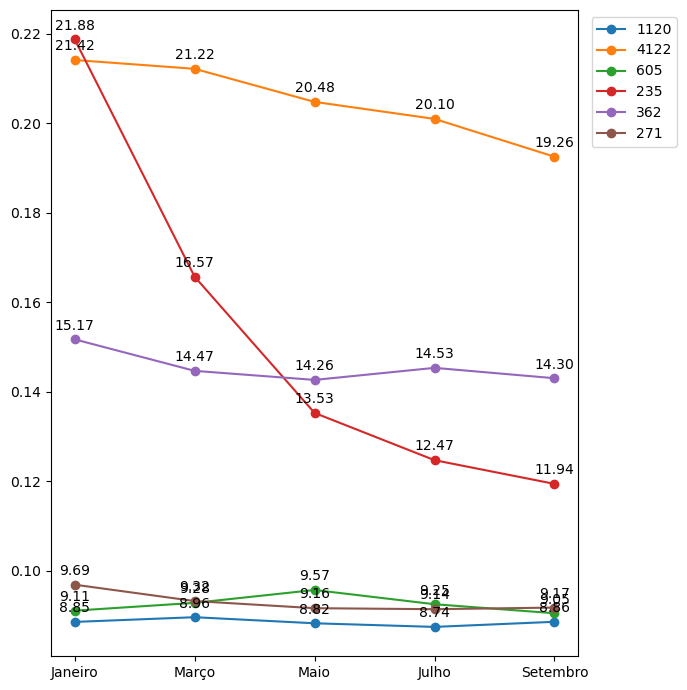

<Figure size 640x480 with 0 Axes>

In [73]:
b = a[(a["Modelo"] == "Linear Regression") & (a["Métrica"] == "MAPE") & (a["Teste"].str.contains("4 Teste"))].sort_values("Teste")


plt.figure(figsize=[7, 7])
for rota in b["Rota"].unique():
    c = b[b["Rota"] == rota]
    c["Teste"] = ["Janeiro", "Março", "Maio", "Julho", "Setembro"]
    ax = plt.plot(c["Teste"], c["Valor"], marker="o", label=rota)

    for i in range(len(c["Teste"])):
        value_f = "{:.2f}".format(c["Valor"].iloc[i] * 100)
        plt.text(c["Teste"].iloc[i], c["Valor"].iloc[i] + 0.0015, value_f, ha='center', va="bottom")

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

plt.savefig("Results/resultados_intervalo_treino_lr.svg")

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Treino do Modelo XGB
modelo_xgb = xgb.XGBRegressor()
modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

#Treino do Modelo RF
modelo_rf = RandomForestRegressor()
modelo_rf.fit(x_treino, y_treino)

#Treino do Modelo LR
modelo_lr = LinearRegression()
modelo_lr.fit(x_treino, y_treino)

#Predição do XGB e salvamento do tempo
prev_xgb = modelo_xgb.predict(x_teste)

#Predição do RF e salvamento do tempo
prev_rf = modelo_rf.predict(x_teste)

#Predição do LR e salvamento do tempo
prev_lr = modelo_lr.predict(x_teste)
